### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime, timedelta
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
import torch.backends.cudnn as cudnn

In [61]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### SIR model simulation

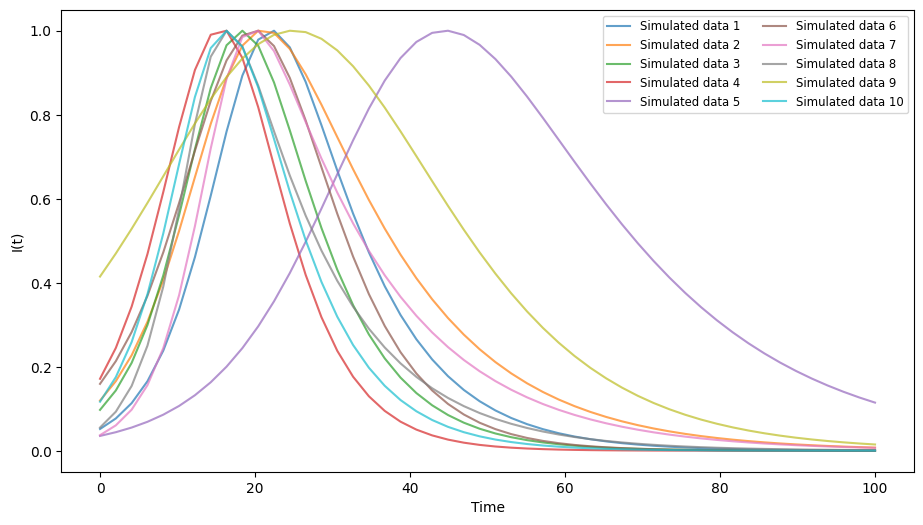

In [147]:
# Generate and plot multiple SIR datasets using NumPy and Matplotlib
def generate_sir_data_numpy(beta, gamma, S0, I0, R0, t_eval):
    S, I, R = S0, I0, R0
    S_list, I_list, R_list = [S], [I], [R]
    dt = t_eval[1] - t_eval[0]
    for _ in t_eval[1:]:
        dS_dt = -beta * S * I
        dI_dt = beta * S * I - gamma * I
        dR_dt = gamma * I

        S += dS_dt * dt
        I += dI_dt * dt
        R += dR_dt * dt

        S_list.append(S)
        I_list.append(I)
        R_list.append(R)

    return np.array(S_list), np.array(I_list), np.array(R_list)

# Parameters
num_datasets = 10
t_eval = np.linspace(0, 100, 50)
datasets = []

for _ in range(num_datasets):
    beta = np.random.uniform(0.2, 0.5)  # Random beta
    gamma = np.random.uniform(0.05, 0.2)  # Random gamma
    S0 = np.random.uniform(0.8, 0.95)  # Initial susceptible fraction
    I0 = np.random.uniform(0.01, 0.05)  # Initial infected fraction
    R0 = 1 - S0 - I0

    S, I, R = generate_sir_data_numpy(beta, gamma, S0, I0, R0, t_eval)
    I = I / max(I)
    datasets.append((t_eval, I))

# Plot the datasets
plt.figure(figsize=(11, 6))
for i, (t, I) in enumerate(datasets):
    plt.plot(t, I, label=f"Simulated data {i + 1}", alpha=0.7)

#plt.title("Simulated SIR Infection Datasets")
plt.xlabel("Time")
plt.ylabel("I(t)")
plt.legend(loc='upper right', ncol=2, fontsize='small')
#plt.grid()
plt.show()

### Model

In [45]:
# Define the PINN model
class PINN(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=2, output_dim=1):
        super(PINN, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.layers = num_layers

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=0.1,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(0)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :]) # Shape: (batch_size, hidden_dim)
        return out

### Loss functions for pre-training

In [171]:
# Loss functions
def residual_loss(I_pred, beta, gamma, t, N):

    I_np = I_pred.detach().cpu().numpy()
    t_np = t.detach().cpu().numpy().squeeze()

    # Compute numerical derivative dI/dt
    dI_dt = np.zeros_like(I_np)
    dt = t_np[1] - t_np[0]  # Assume uniform timestep

    for i in range(1, len(I_np) - 1):
        dI_dt[i] = (I_np[i + 1] - I_np[i - 1]) / (2 * dt)
    dI_dt[0] = (I_np[1] - I_np[0]) / dt
    dI_dt[-1] = (I_np[-1] - I_np[-2]) / dt

    dI_dt = torch.tensor(dI_dt, dtype=torch.float32, device=I_pred.device)

    # Compute S and R
    R = torch.cumsum(gamma * I_pred, dim=0) * dt
    S = N - I_pred - R

    # Residuals
    residual_I = dI_dt[-1] + beta * S * I_pred[-1] - gamma * I_pred[-1]
    return torch.mean(residual_I**2)

# def residual_loss(I_pred, beta, gamma, t, N):
#     """
#     Residual loss calculation for predictions only.
#     """
#     # Compute numerical derivative dI/dt using PyTorch operations to retain the graph
#     dt = t[1] - t[0]  # Assume uniform timestep
#     dI_dt = torch.zeros_like(I_pred)
#     dI_dt[1:-1] = (I_pred[2:] - I_pred[:-2]) / (2 * dt)
#     dI_dt[0] = (I_pred[1] - I_pred[0]) / dt  # Forward difference for the first point
#     dI_dt[-1] = (I_pred[-1] - I_pred[-2]) / dt  # Backward difference for the last point

#     # Compute S and R
#     R = torch.cumsum(gamma * I_pred, dim=0) * dt
#     S = N - I_pred - R

#     # Residuals
#     residual_I = dI_dt - beta * S * I_pred + gamma * I_pred
#     return torch.mean(residual_I**2)

def data_loss(pred, target):
    return torch.mean((pred - target) ** 2)

### Old loss functions

In [31]:
# Defining the loss functions
def MSE_loss(y_true, y_pred):
    return torch.mean((y_true - y_pred) ** 2)

def SIR_loss(model, t, beta, gamma):
    t = t.requires_grad_(True)  # Enable gradient computation for time tensor

    # Forward pass through the model
    x = model(t)

    # Compute gradients
    dx_dt = torch.autograd.grad(
        x, t, grad_outputs=torch.ones_like(x), create_graph=True
    )[0]  # First derivative

    # SIR model loss: dI/dt = beta * I - gamma * I
    sir_loss = dx_dt + beta * torch.exp(x) - gamma * torch.exp(x)

    # Return the squared loss
    return torch.mean(sir_loss ** 2)

### Early Stopping

In [56]:
class EarlyStopping:
    def __init__(self, model, patience, beta, gamma):
        self.patience = patience
        self.model = model
        self.beta = beta
        self.gamma = gamma
        
        self.best_loss = np.inf
        self.wait = 0

        self.best_model = None
        self.bests_weights = None
        self.bestBeta = None
        self.bestGamma = None
        self.bestMu = None

    def check_early_stopping(self, current_loss, epoch):
        if current_loss < self.best_loss:
            self.best_loss = current_loss.cpu().item() if torch.is_tensor(current_loss) else current_loss
            self.wait = 0

            self.best_model = self.model
            self.best_weights = self.model.state_dict()
            self.bestBeta = self.beta
            self.bestGamma = self.gamma
        else:
            self.wait += 1
        
        if self.wait >= self.patience:
            print(f"Early stopping at epoch {epoch}.")
            self.model.load_state_dict(self.best_weights)
            return True
        return False

### Plotting validation result

In [273]:
def plot_predictions(data, test_start_point, predicted_values):
    """
    Plot predictions and training results.
    """
    # Ensure the save directory exists
    #if not os.path.exists(save_path):
    #    os.makedirs(save_path)

    data = data.cpu().numpy()

    predictions = np.append(np.array([None]*test_start_point), predicted_values)

    fig, ax1 = plt.subplots(figsize=(9, 5))

    # Training Data
    ax1.plot(data, 'ko', markersize=6, label='SIR simulation data')

    # Predicted values
    ax1.plot(predictions, color="orangered", label="Predicted by PINN")

    # Format x-axis
    ax1.set_xlabel("Time")
    ax1.set_ylabel("I(t)", color="k")
    ax1.tick_params(axis='y', labelcolor="k")
    ax1.legend(loc="upper right")

    # Plotting
    plt.tight_layout()
    plt.show()
    plt.close()

### Prediction for validation

In [71]:
def autoregressive_predict(model, given_data, steps):
    model.eval()
    input_sequence = list(given_data)
    predictions = torch.tensor([])

    with torch.no_grad():
        for _ in range(steps):
            input_tensor = torch.tensor(input_sequence, dtype=torch.float32).view(-1, 1).to(device)
            predicted = model(input_tensor).squeeze()
            predictions = np.append(predictions, predicted.cpu().numpy())
            input_sequence.append(predicted)
    model.train()
    return predictions

### Pre-training

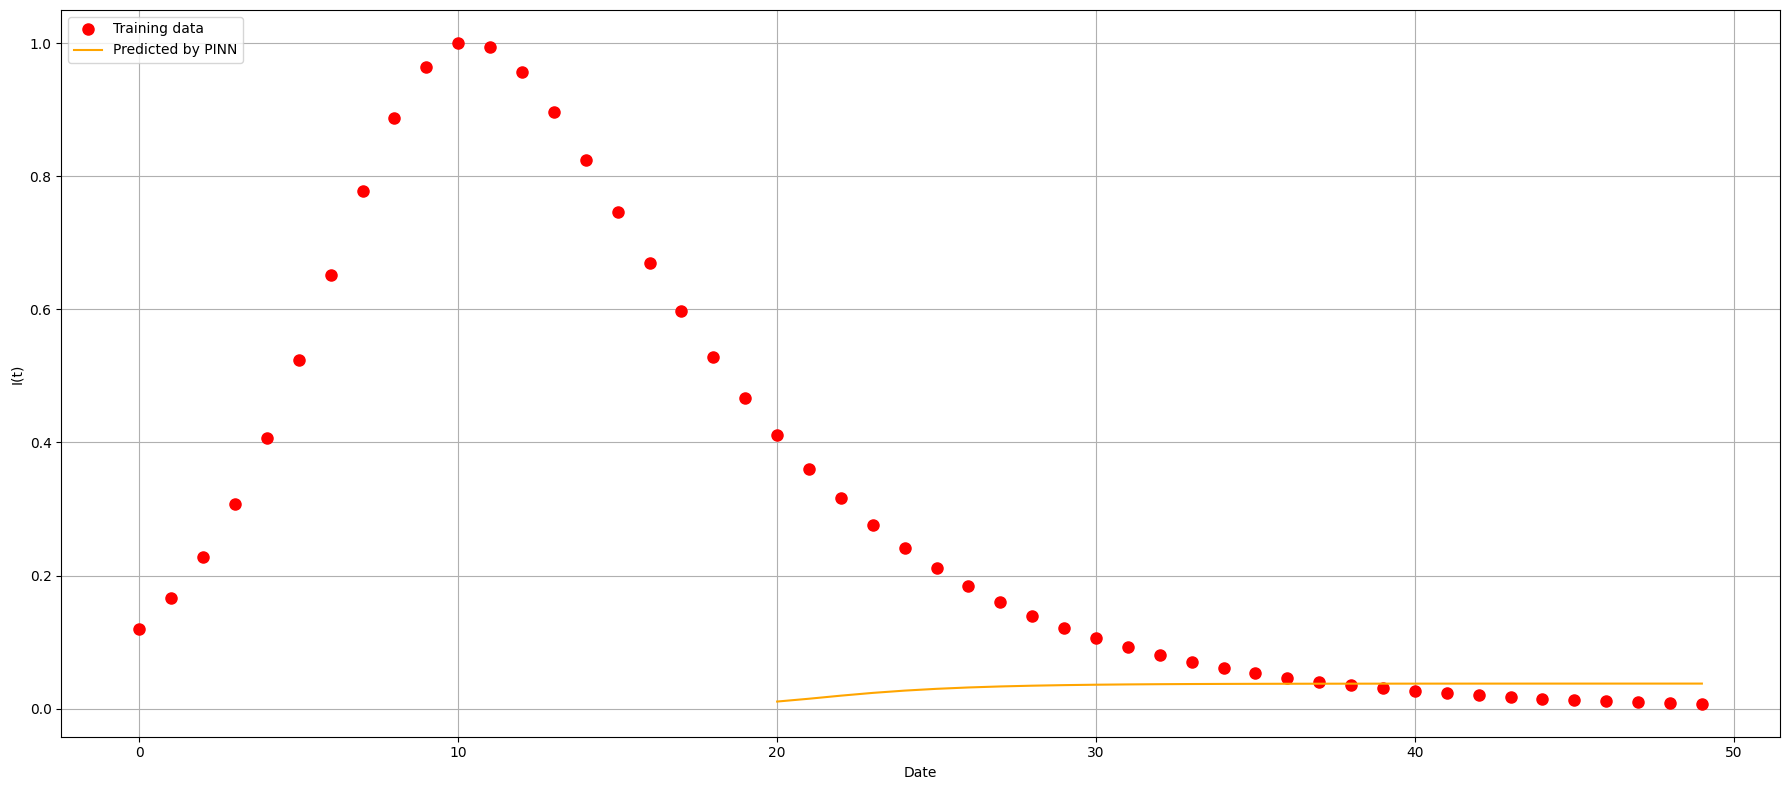

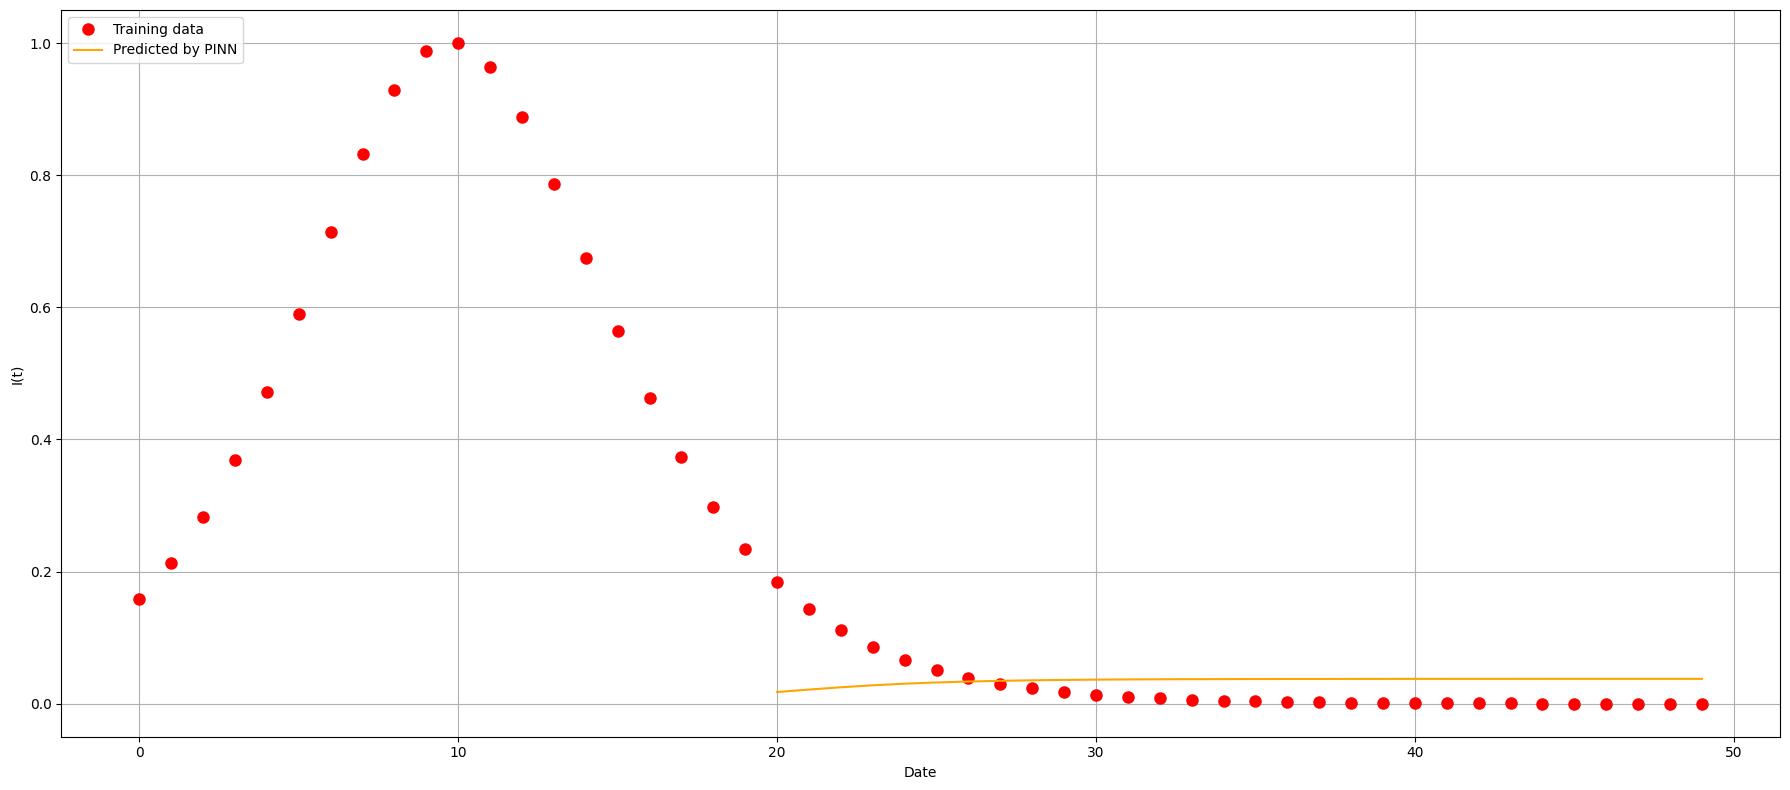

Epoch 0, Total Loss: 14.0122, SIR Loss: 4.268188037756545, MSE Loss: 9.744028365575575, Beta: 0.3647, Gamma: 0.1459
Epoch 10, Total Loss: 0.1668, SIR Loss: 0.031227416664944812, MSE Loss: 0.13554308761113348, Beta: 0.0183, Gamma: -0.0123
Epoch 20, Total Loss: 0.1379, SIR Loss: 0.032652293379347226, MSE Loss: 0.10525130308950695, Beta: 0.0005, Gamma: -0.0073
Epoch 30, Total Loss: 0.1527, SIR Loss: 0.03278160756919857, MSE Loss: 0.11990607405144763, Beta: -0.0020, Gamma: -0.0075
Epoch 40, Total Loss: 0.0779, SIR Loss: 0.032760167993385485, MSE Loss: 0.04517374784046606, Beta: -0.0006, Gamma: -0.0086


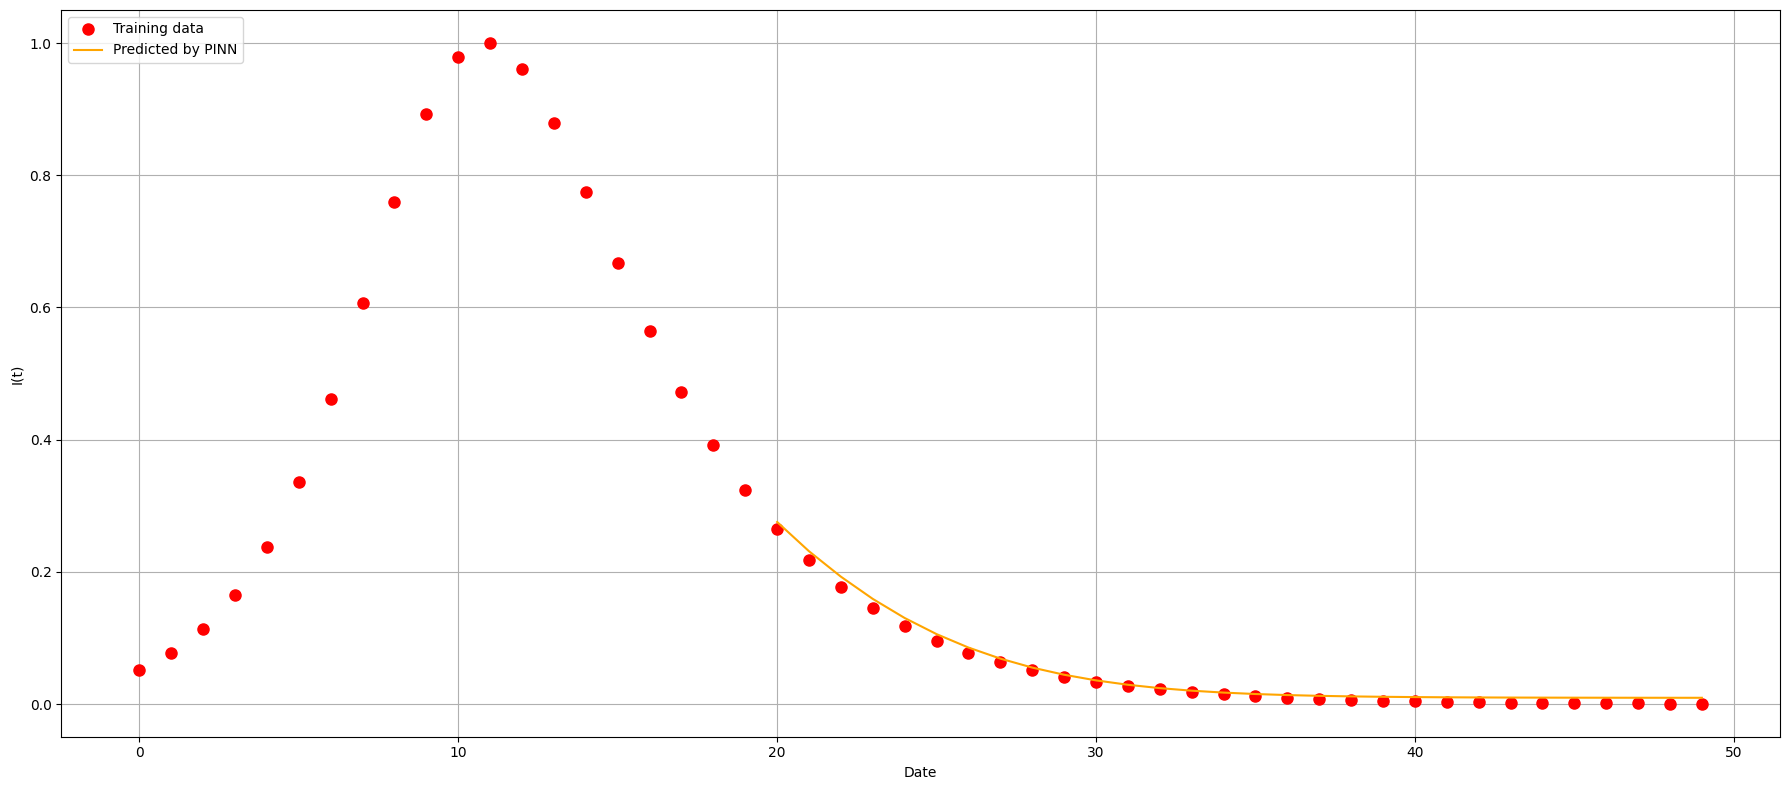

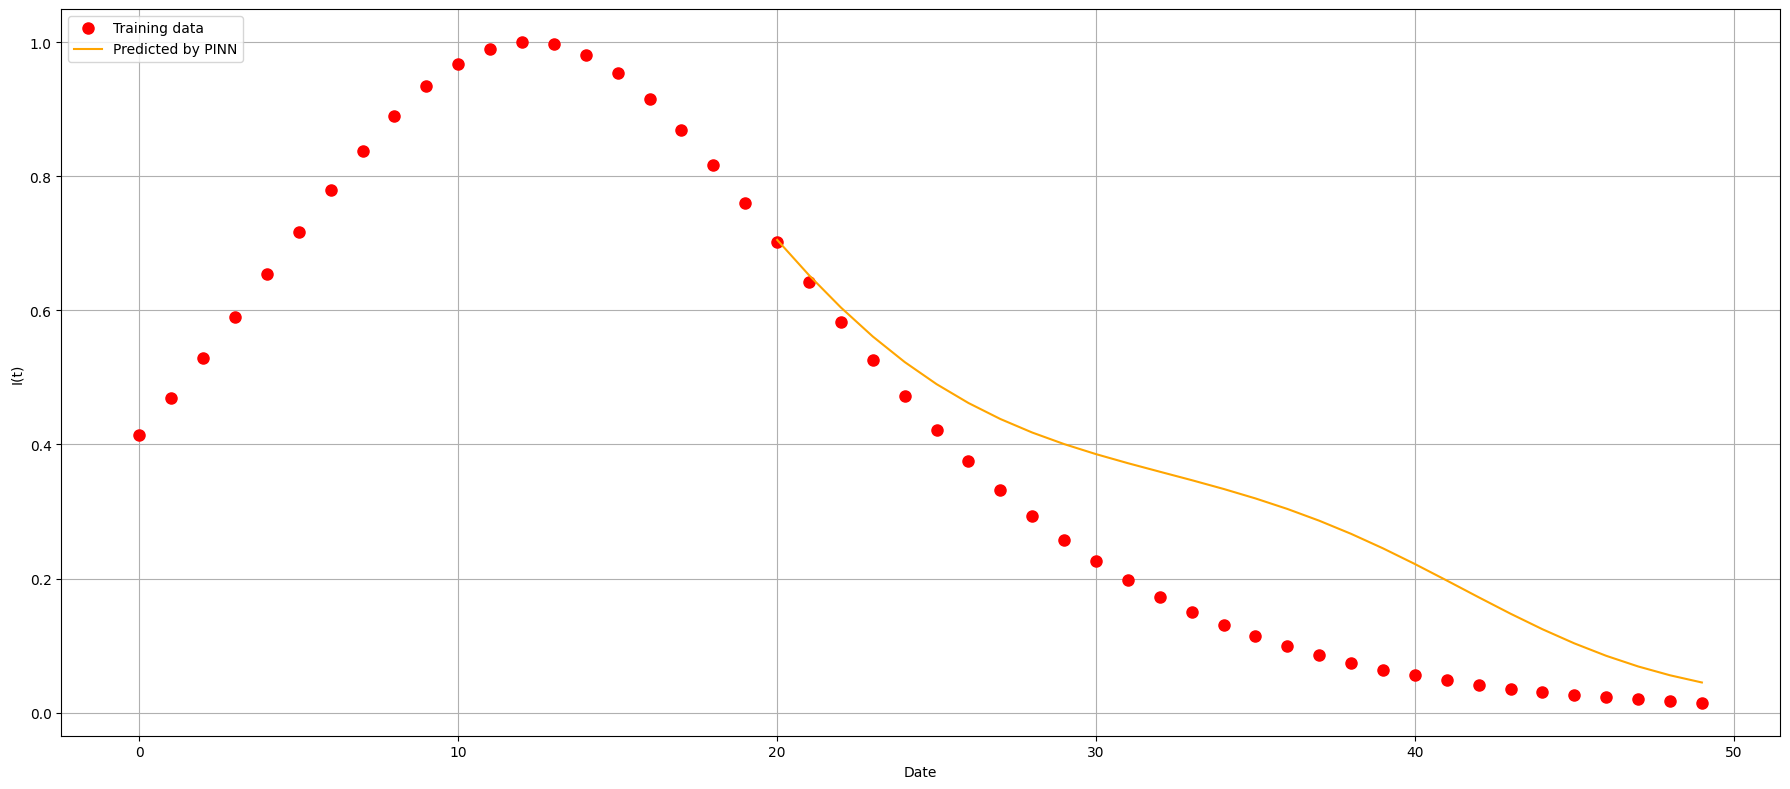

Epoch 50, Total Loss: 0.0890, SIR Loss: 0.03274324489472794, MSE Loss: 0.056242790014451406, Beta: -0.0005, Gamma: -0.0087
Epoch 60, Total Loss: 0.0520, SIR Loss: 0.032658713197286825, MSE Loss: 0.01932422983842287, Beta: 0.0019, Gamma: -0.0084
Epoch 70, Total Loss: 0.0587, SIR Loss: 0.03270848214975501, MSE Loss: 0.02601772471421777, Beta: 0.0020, Gamma: -0.0085
Epoch 80, Total Loss: 0.0707, SIR Loss: 0.03262122560204683, MSE Loss: 0.0381225395111553, Beta: 0.0021, Gamma: -0.0085
Epoch 90, Total Loss: 0.0674, SIR Loss: 0.03261452825267558, MSE Loss: 0.0347756880640233, Beta: 0.0031, Gamma: -0.0085


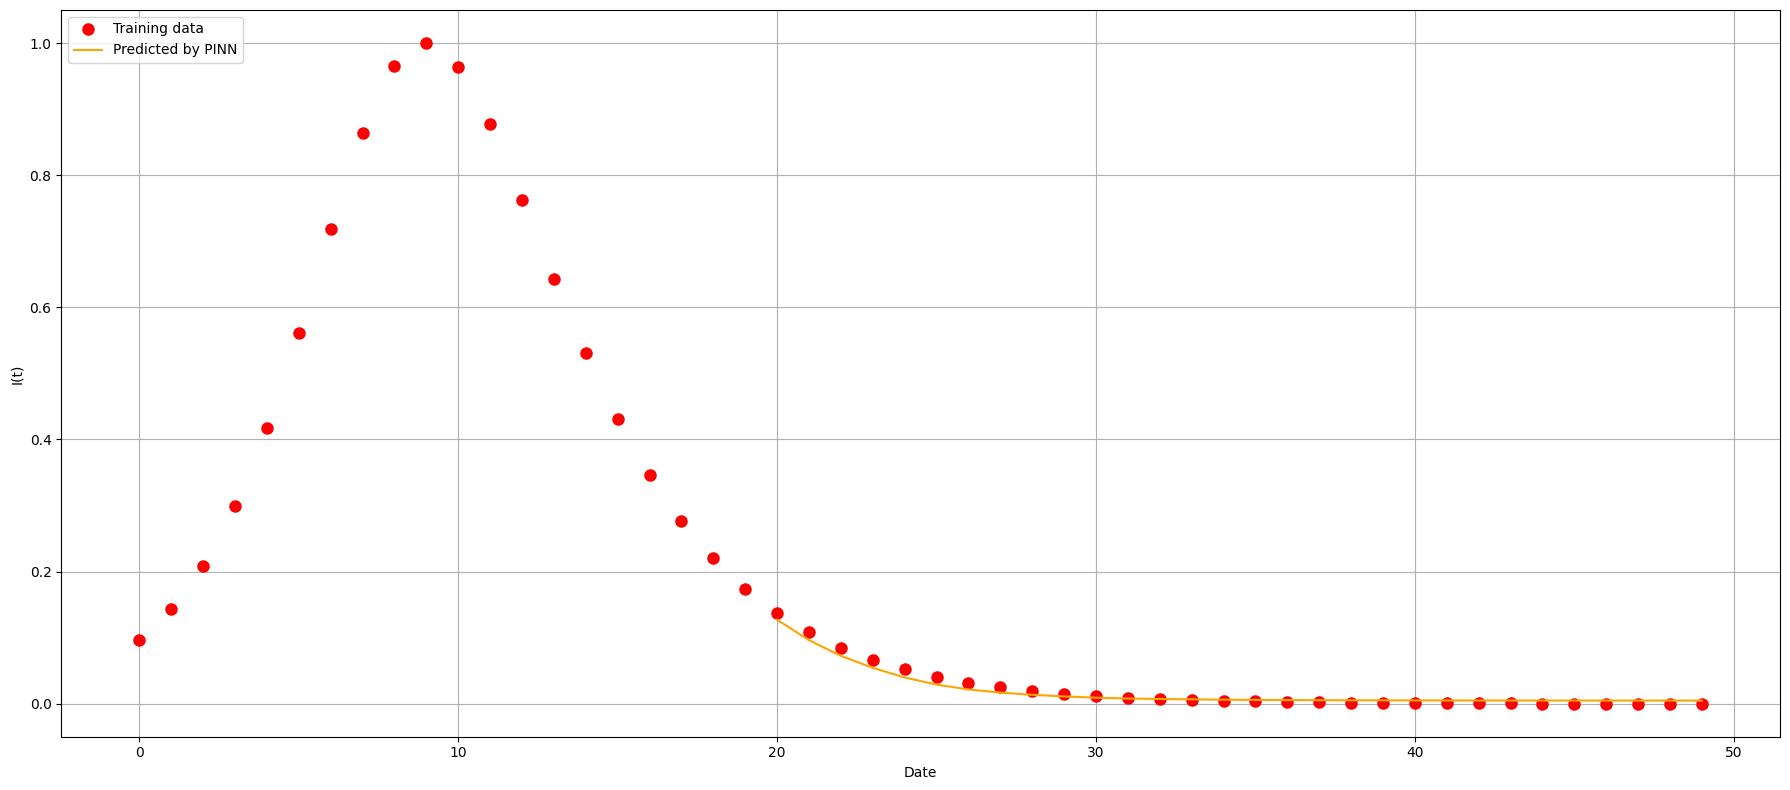

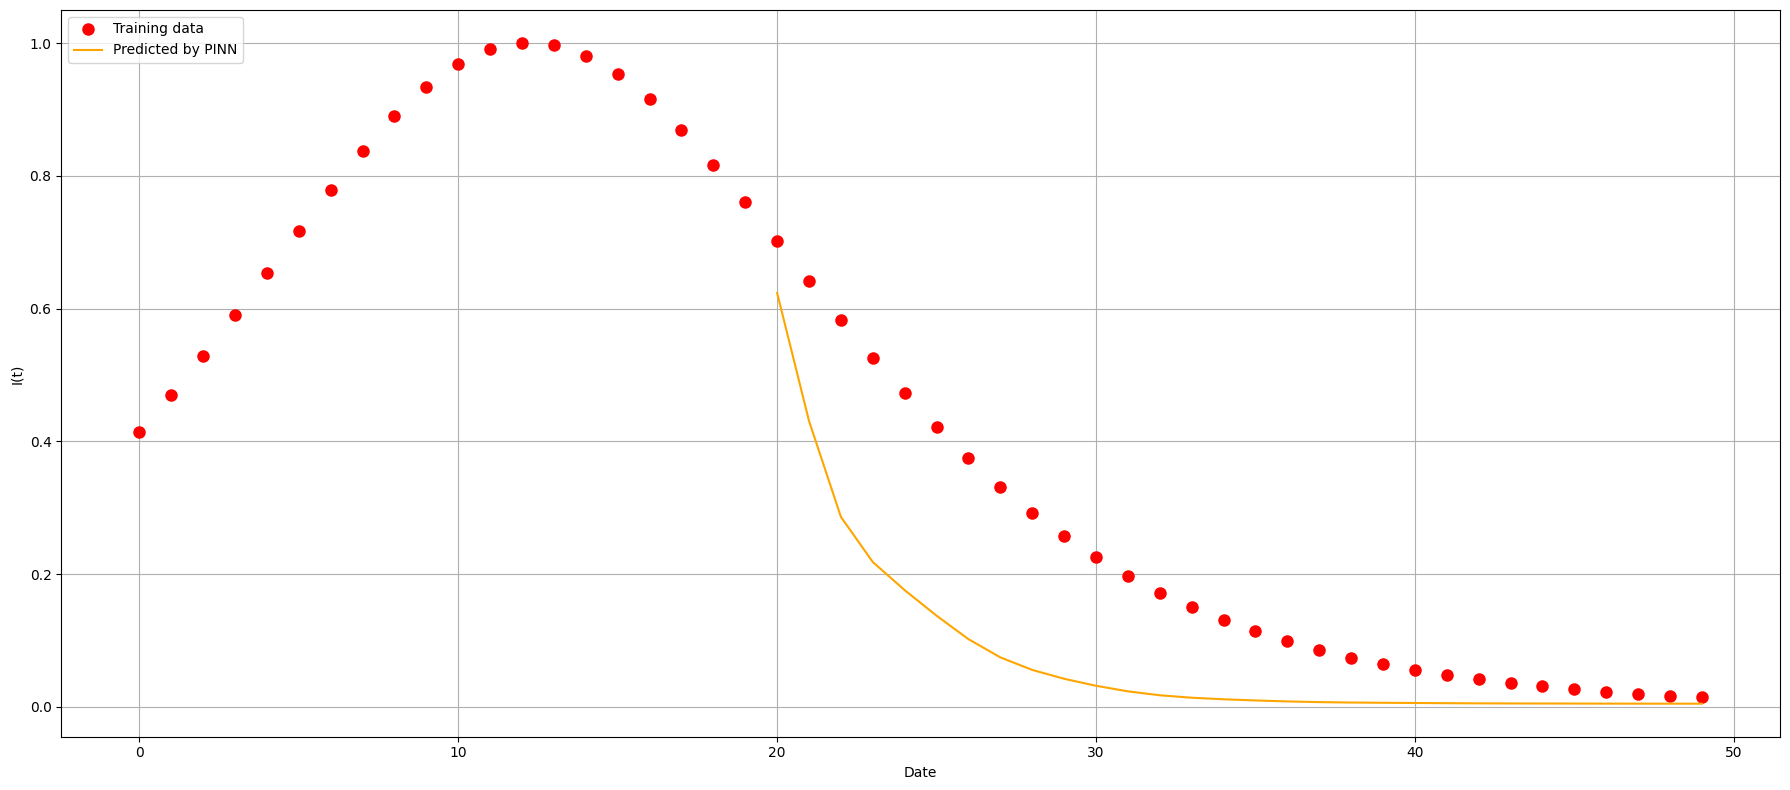

Epoch 100, Total Loss: 0.0625, SIR Loss: 0.032643004319922085, MSE Loss: 0.0298128551302136, Beta: 0.0038, Gamma: -0.0081
Epoch 110, Total Loss: 0.0510, SIR Loss: 0.03260304294740899, MSE Loss: 0.018396628905868375, Beta: 0.0032, Gamma: -0.0088
Epoch 120, Total Loss: 0.0508, SIR Loss: 0.03261859199673552, MSE Loss: 0.01815134065807196, Beta: 0.0020, Gamma: -0.0083
Epoch 130, Total Loss: 0.0466, SIR Loss: 0.032631309190703464, MSE Loss: 0.013933167483561187, Beta: 0.0020, Gamma: -0.0085
Epoch 140, Total Loss: 0.0557, SIR Loss: 0.03269783021764872, MSE Loss: 0.022977579180788243, Beta: 0.0037, Gamma: -0.0078


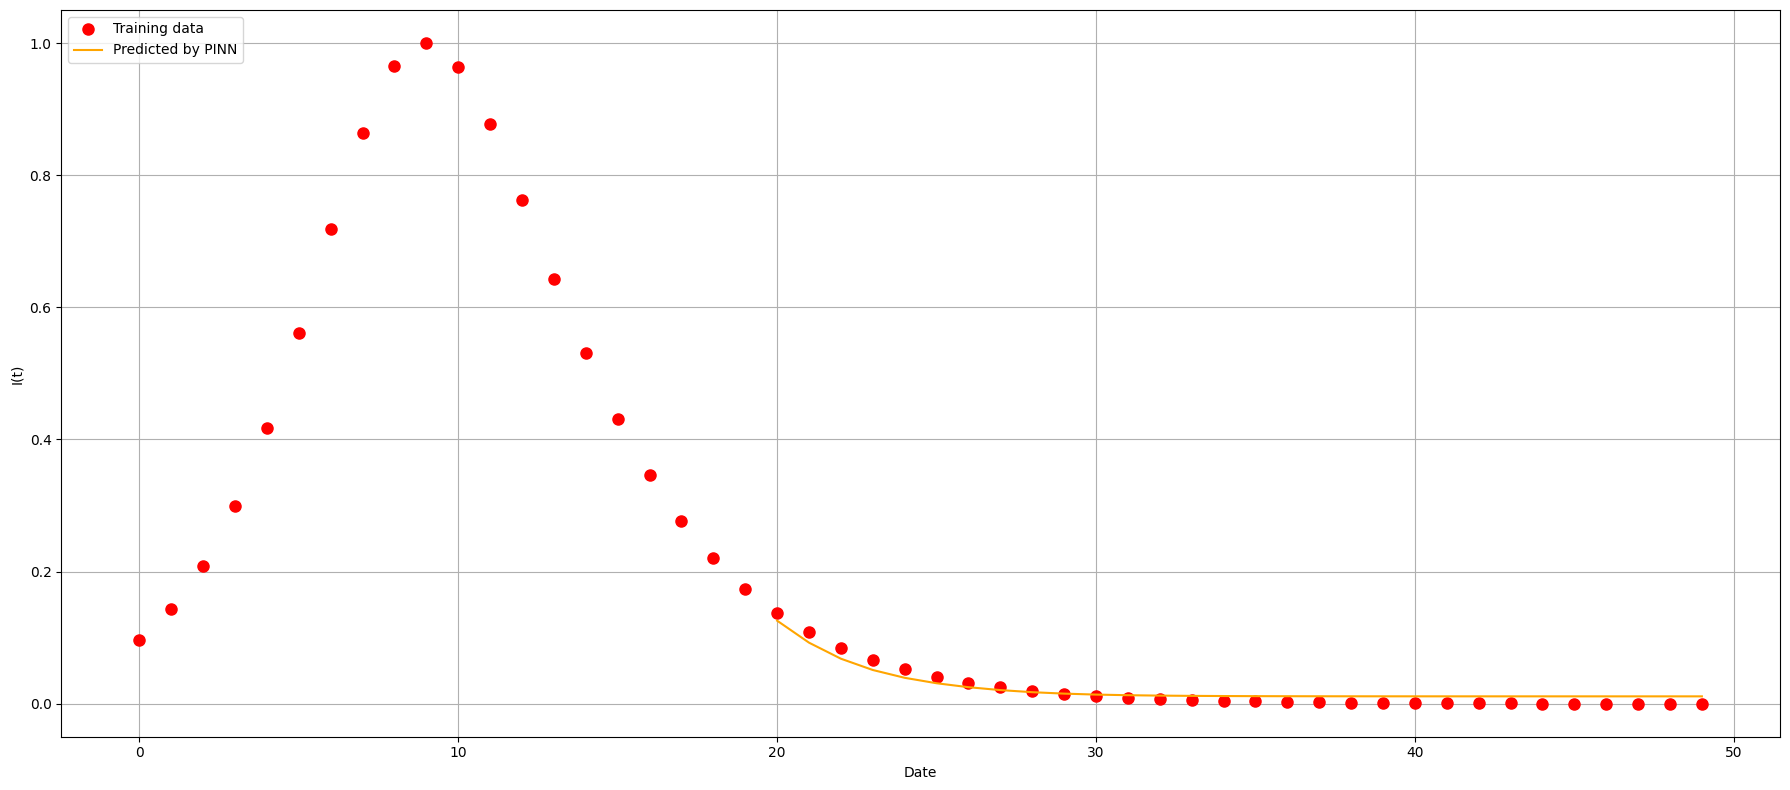

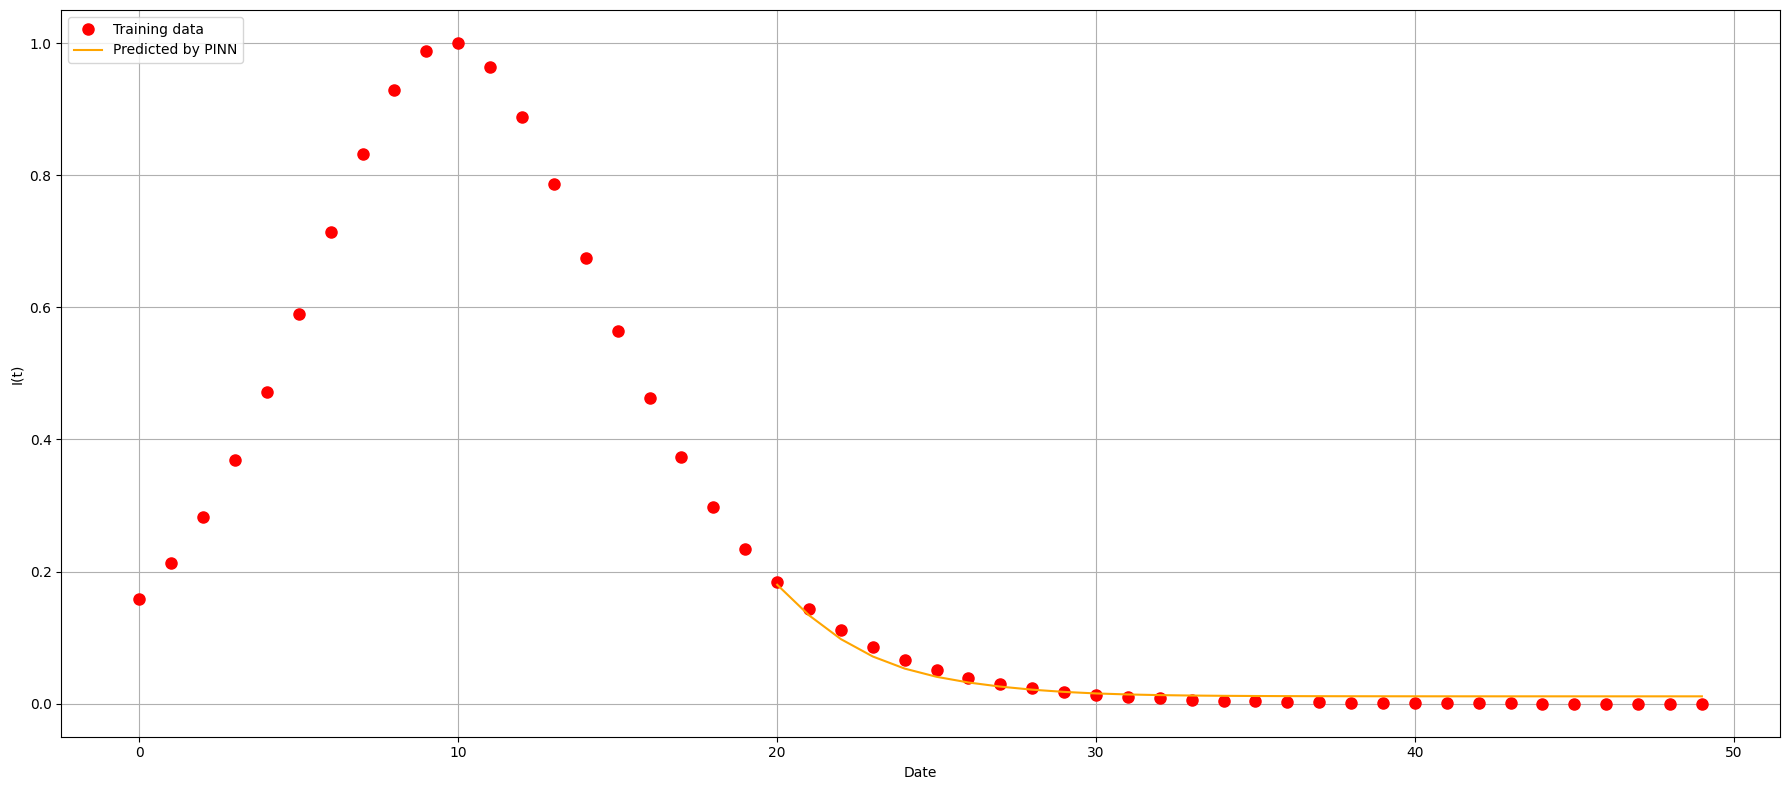

Epoch 150, Total Loss: 0.0432, SIR Loss: 0.03262391433883213, MSE Loss: 0.010534830513231475, Beta: 0.0027, Gamma: -0.0084
Epoch 160, Total Loss: 0.0560, SIR Loss: 0.032638575245884364, MSE Loss: 0.023351469688563407, Beta: 0.0019, Gamma: -0.0082
Epoch 170, Total Loss: 0.0678, SIR Loss: 0.03265589289714275, MSE Loss: 0.035168130822938994, Beta: 0.0014, Gamma: -0.0081
Epoch 180, Total Loss: 0.0489, SIR Loss: 0.03264470152496189, MSE Loss: 0.016252506919726774, Beta: 0.0021, Gamma: -0.0085
Epoch 190, Total Loss: 0.0397, SIR Loss: 0.03269205097843483, MSE Loss: 0.006988510588381254, Beta: 0.0033, Gamma: -0.0084


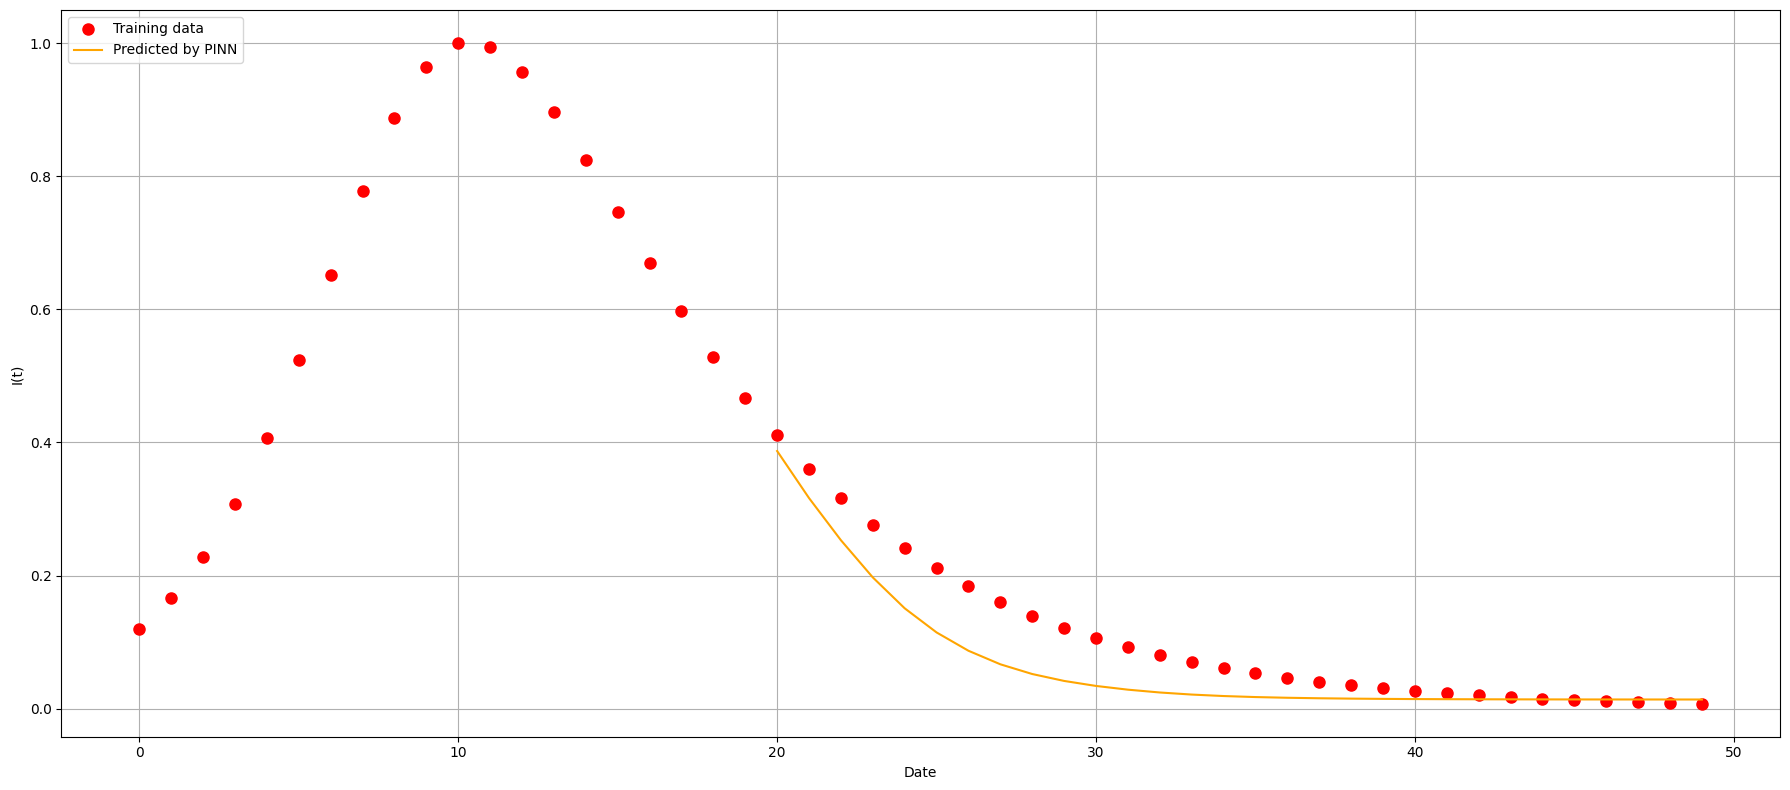

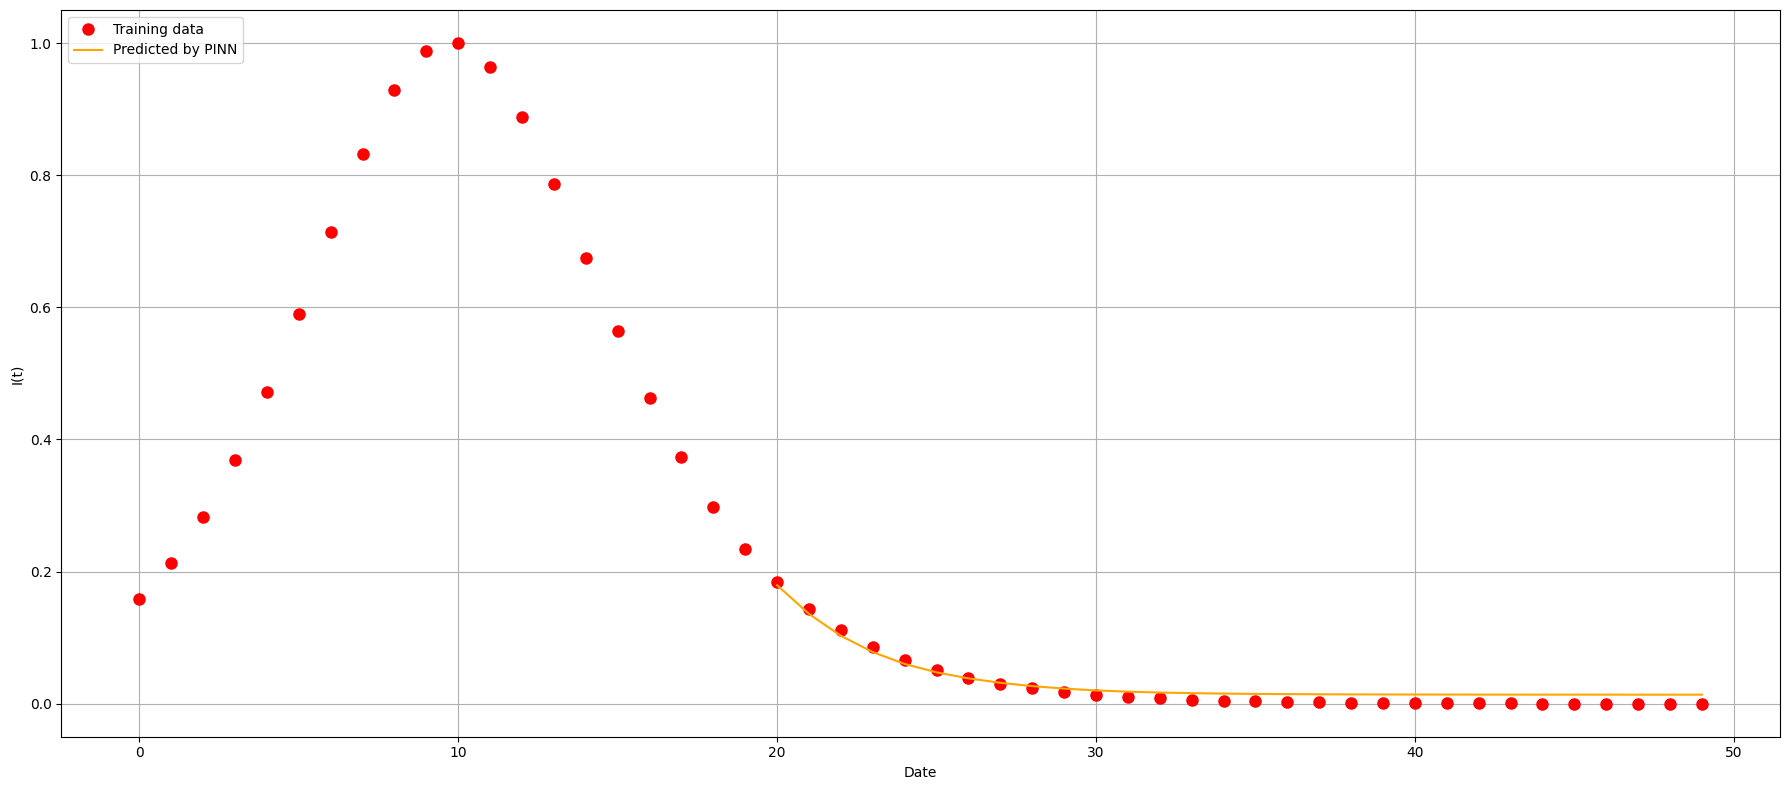

Epoch 200, Total Loss: 0.0399, SIR Loss: 0.03265735695952128, MSE Loss: 0.007271030238579321, Beta: 0.0019, Gamma: -0.0084
Epoch 210, Total Loss: 0.0411, SIR Loss: 0.03262207620629437, MSE Loss: 0.008477481518323105, Beta: 0.0019, Gamma: -0.0087
Epoch 220, Total Loss: 0.0402, SIR Loss: 0.03262913837171796, MSE Loss: 0.0075436670790726326, Beta: 0.0021, Gamma: -0.0087
Epoch 230, Total Loss: 0.0444, SIR Loss: 0.03266331011845312, MSE Loss: 0.011731544260116555, Beta: 0.0015, Gamma: -0.0083
Epoch 240, Total Loss: 0.0411, SIR Loss: 0.03267922915954246, MSE Loss: 0.00840386993622883, Beta: 0.0019, Gamma: -0.0086


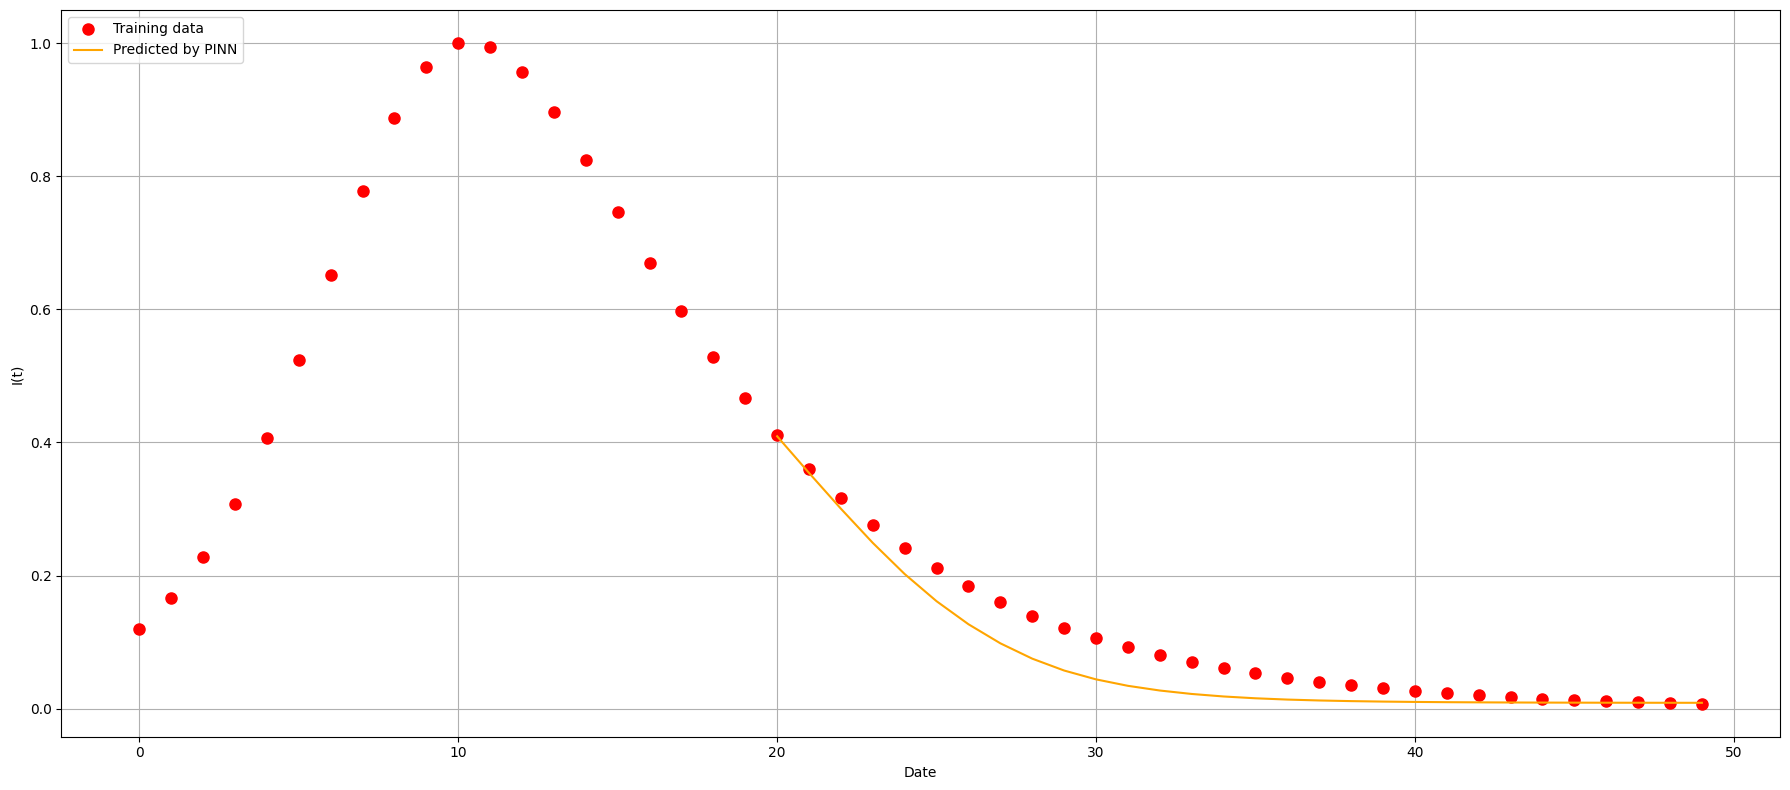

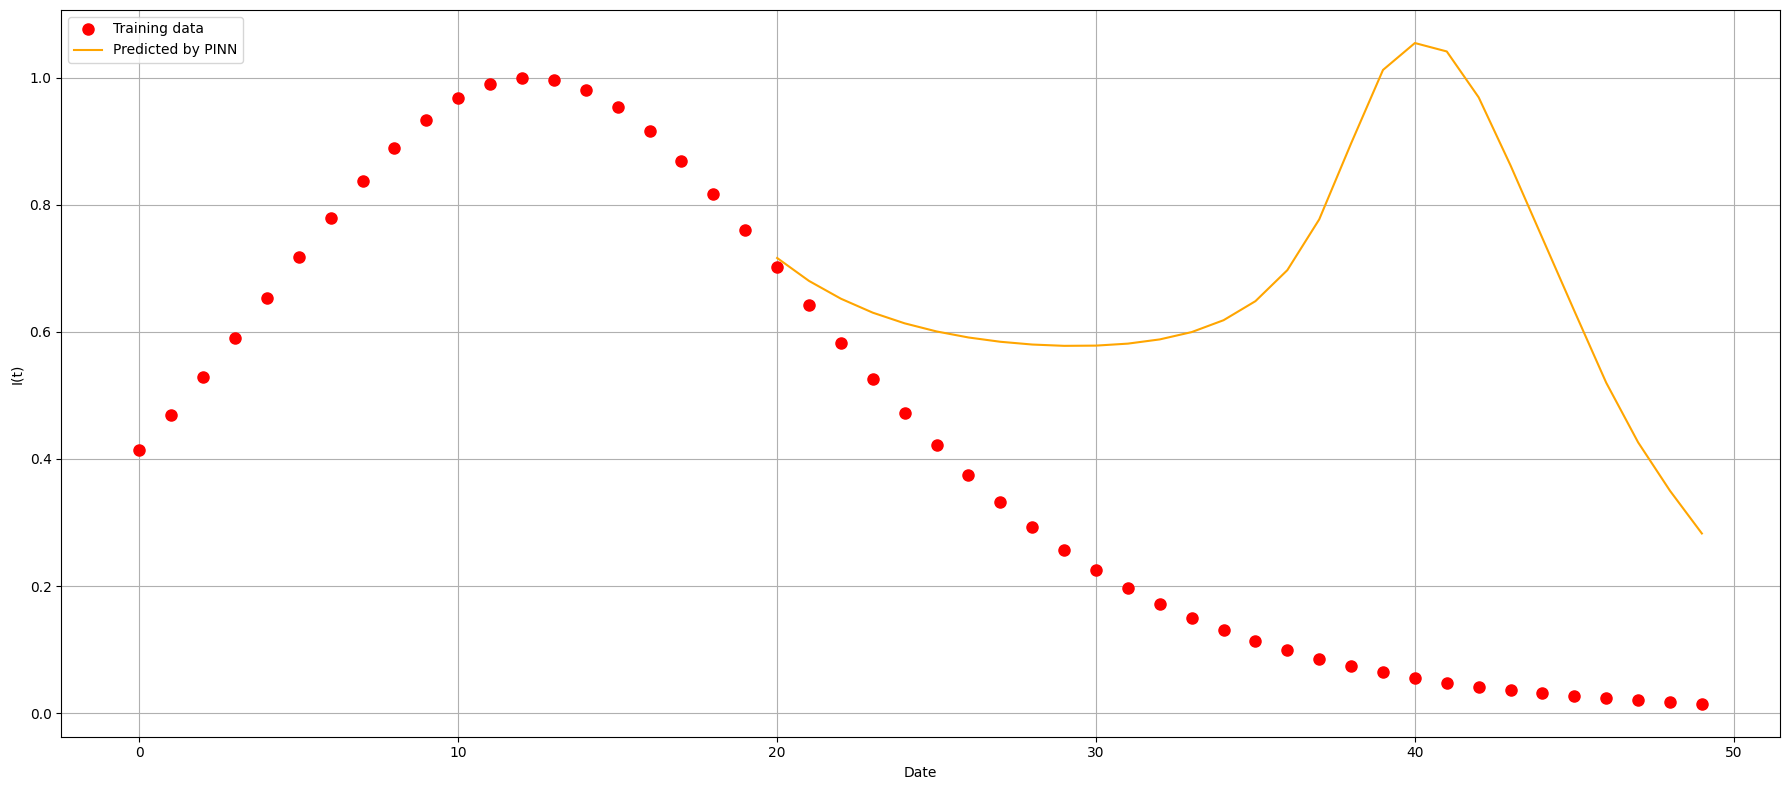

Epoch 250, Total Loss: 0.0504, SIR Loss: 0.03267517503178473, MSE Loss: 0.017689090537724116, Beta: 0.0027, Gamma: -0.0083
Epoch 260, Total Loss: 0.0401, SIR Loss: 0.03261143609934904, MSE Loss: 0.007536457412045961, Beta: 0.0021, Gamma: -0.0086
Epoch 270, Total Loss: 0.0398, SIR Loss: 0.03266236823732703, MSE Loss: 0.0070908667626449805, Beta: 0.0029, Gamma: -0.0084
Epoch 280, Total Loss: 0.0379, SIR Loss: 0.03265199751960674, MSE Loss: 0.005208597388024061, Beta: 0.0026, Gamma: -0.0084
Epoch 290, Total Loss: 0.0458, SIR Loss: 0.03264482571783369, MSE Loss: 0.013195719220111191, Beta: 0.0016, Gamma: -0.0086


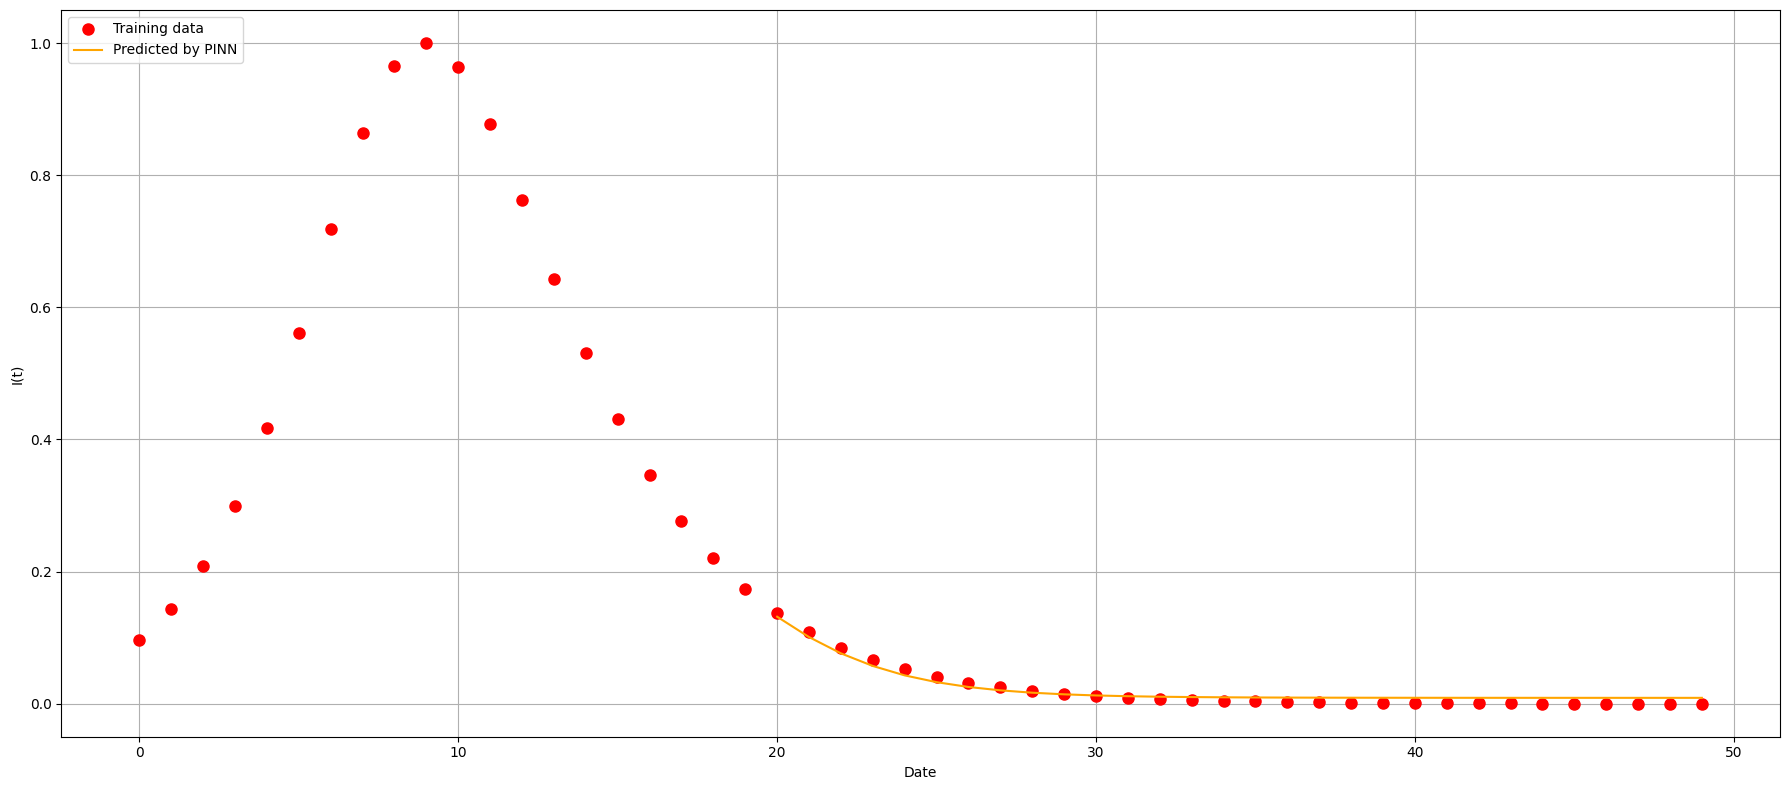

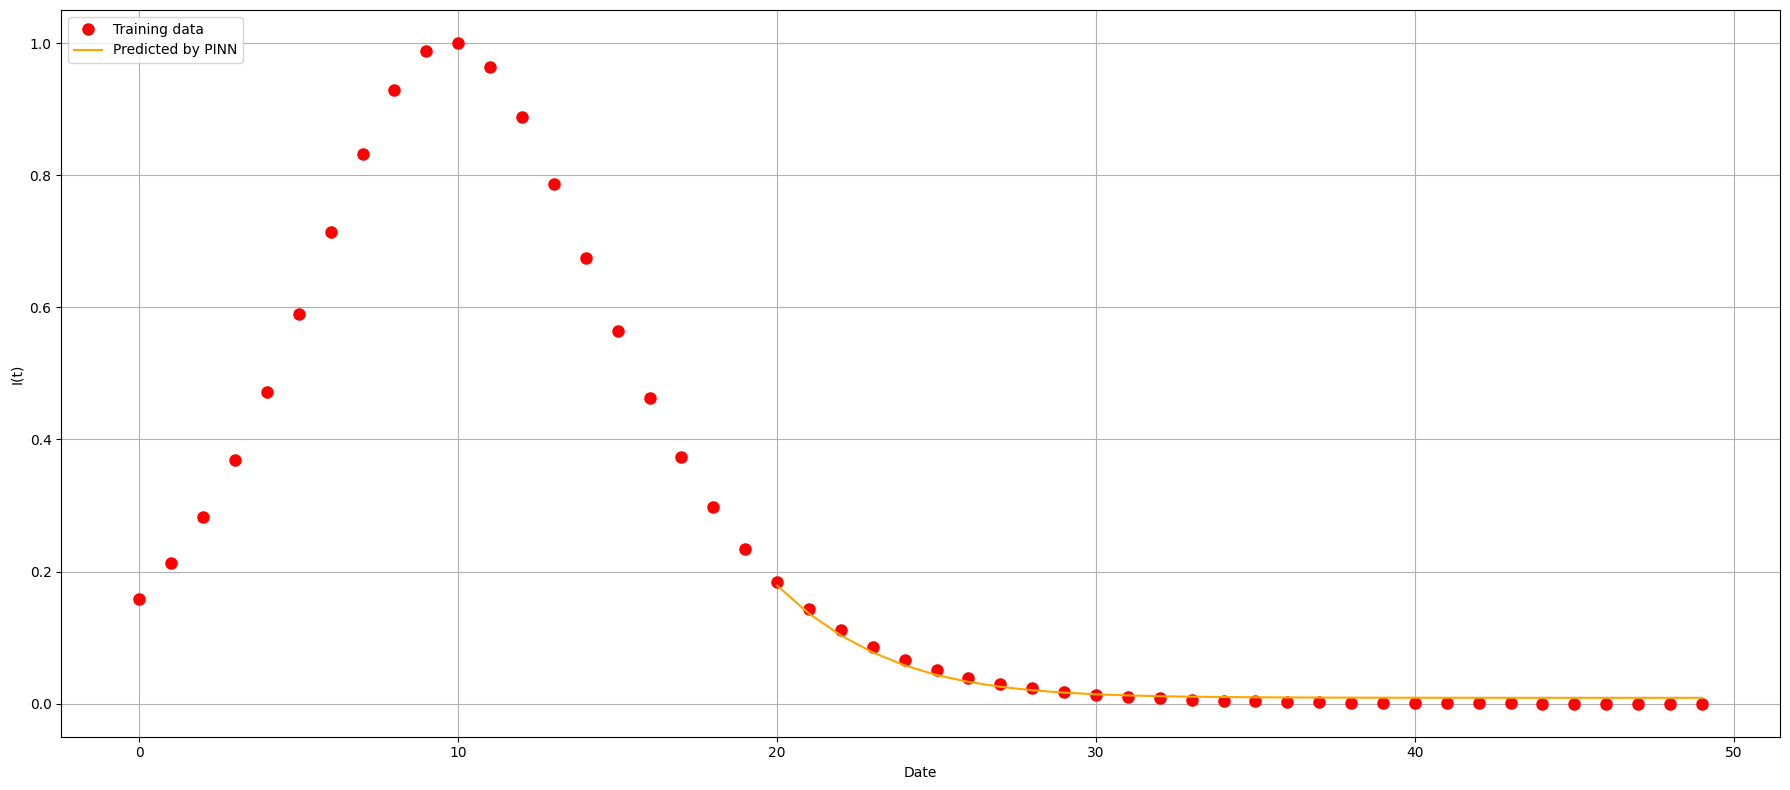

Epoch 300, Total Loss: 0.0376, SIR Loss: 0.03266761743161821, MSE Loss: 0.004964610813198838, Beta: 0.0026, Gamma: -0.0084
Epoch 310, Total Loss: 0.0374, SIR Loss: 0.03265320210359171, MSE Loss: 0.004740817434069078, Beta: 0.0022, Gamma: -0.0084
Epoch 320, Total Loss: 0.0400, SIR Loss: 0.0326275805412395, MSE Loss: 0.007394582362890256, Beta: 0.0020, Gamma: -0.0086
Epoch 330, Total Loss: 0.0417, SIR Loss: 0.032651936753245236, MSE Loss: 0.009002395185896734, Beta: 0.0020, Gamma: -0.0084
Epoch 340, Total Loss: 0.0396, SIR Loss: 0.03263887599298136, MSE Loss: 0.006967786118885311, Beta: 0.0018, Gamma: -0.0086


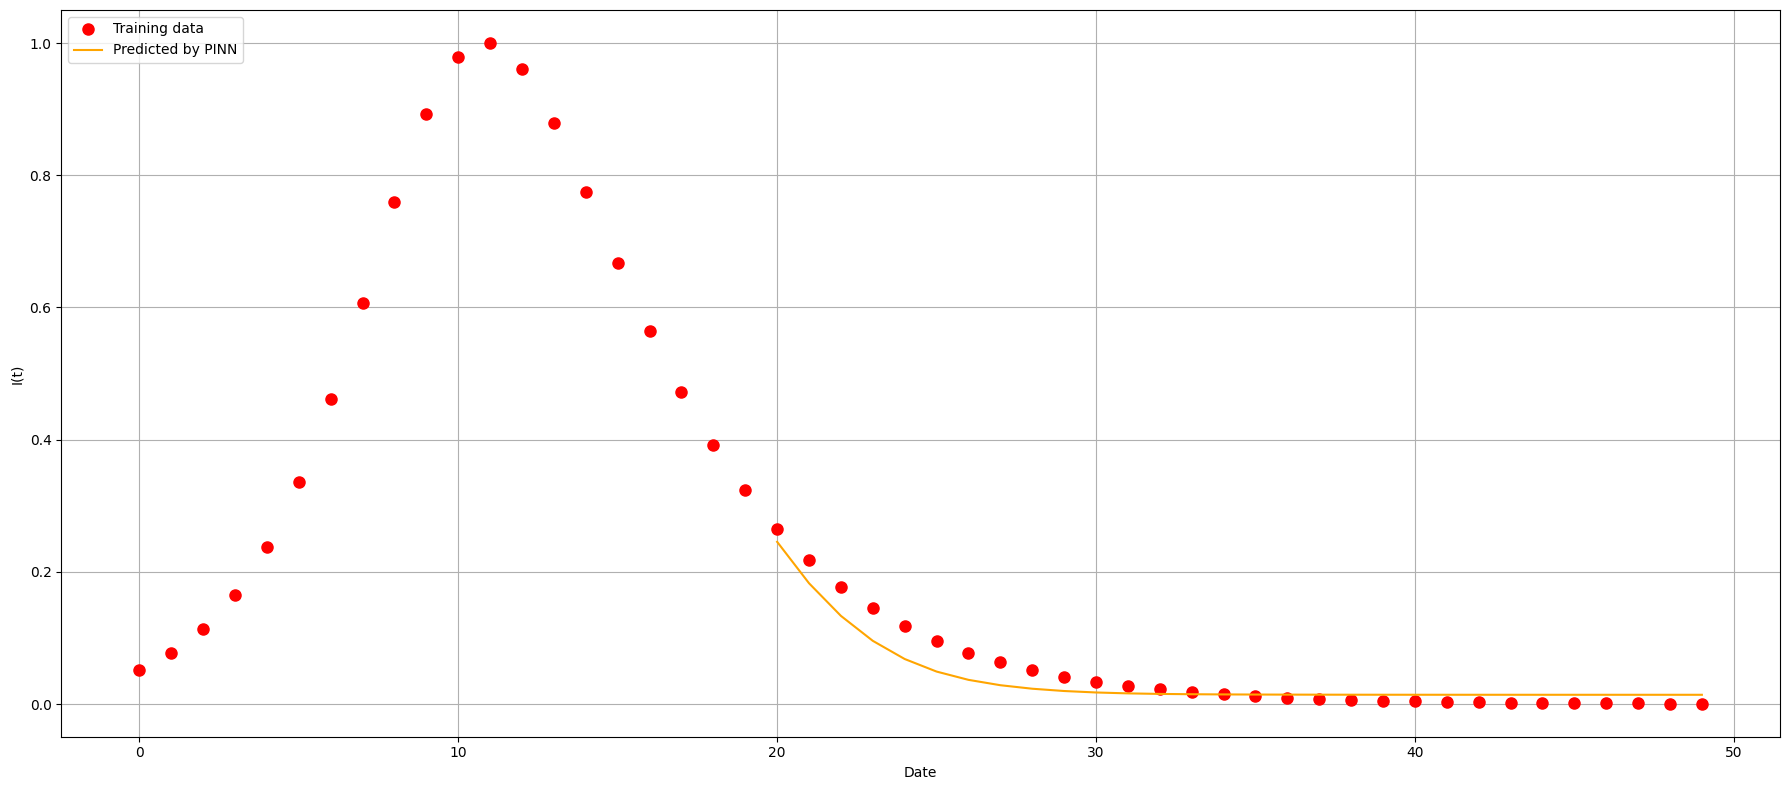

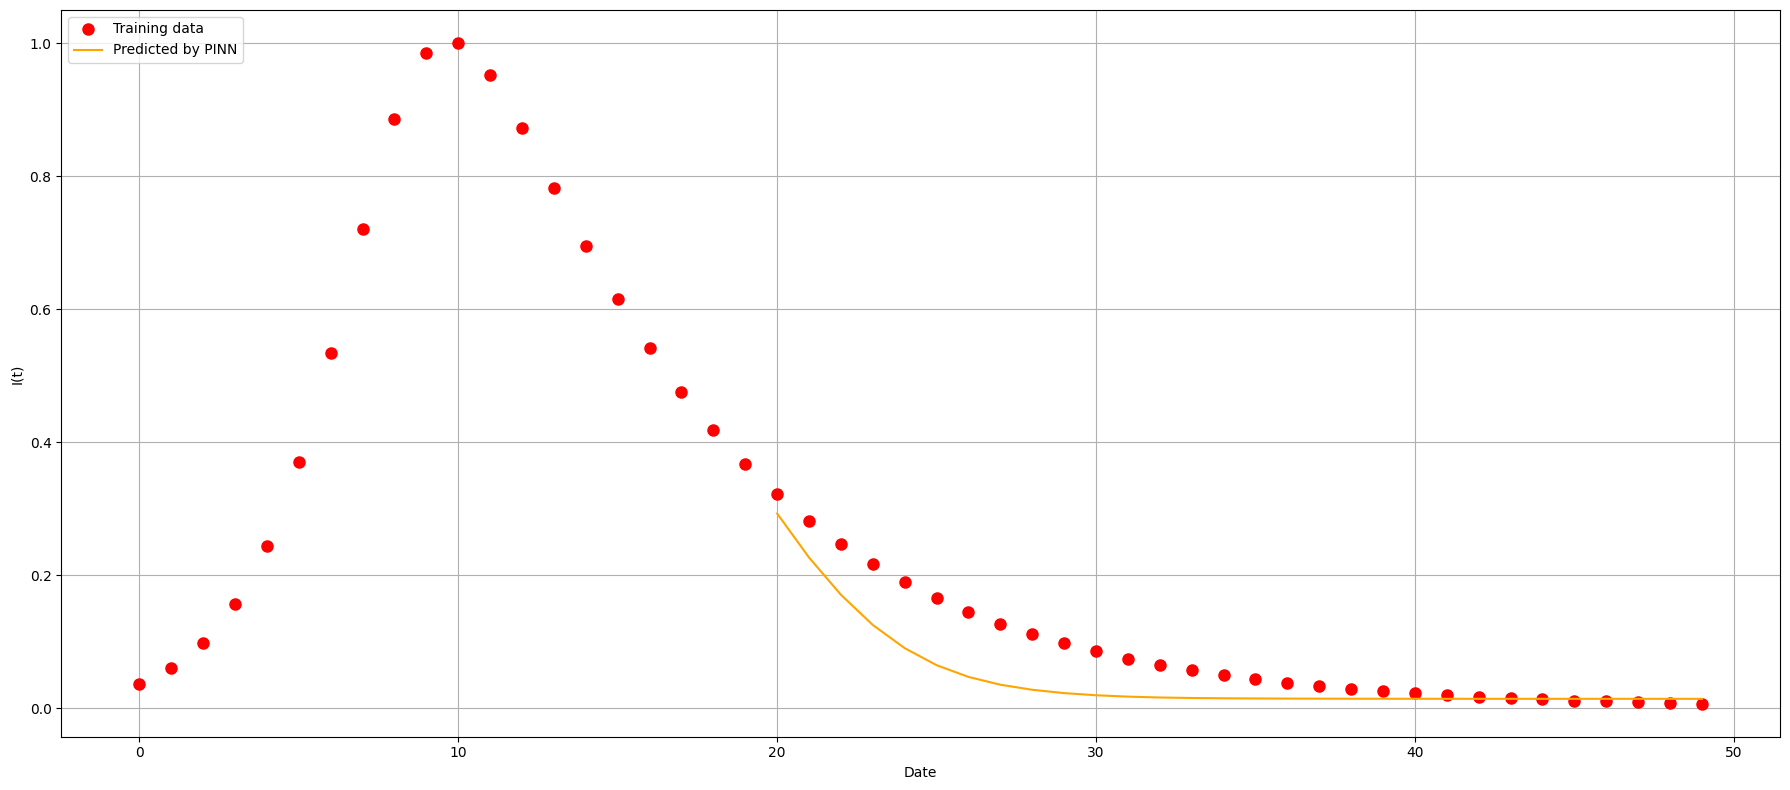

Epoch 350, Total Loss: 0.0393, SIR Loss: 0.032643933095253305, MSE Loss: 0.006607939142506925, Beta: 0.0024, Gamma: -0.0085
Epoch 360, Total Loss: 0.0385, SIR Loss: 0.032633284457379445, MSE Loss: 0.005889467924055739, Beta: 0.0020, Gamma: -0.0085
Epoch 370, Total Loss: 0.0384, SIR Loss: 0.032648474030025416, MSE Loss: 0.0057993490815377415, Beta: 0.0023, Gamma: -0.0086
Epoch 380, Total Loss: 0.0400, SIR Loss: 0.03261250787874379, MSE Loss: 0.007409625812134996, Beta: 0.0019, Gamma: -0.0088
Epoch 390, Total Loss: 0.0467, SIR Loss: 0.03261897677894959, MSE Loss: 0.014084257943691673, Beta: 0.0017, Gamma: -0.0085


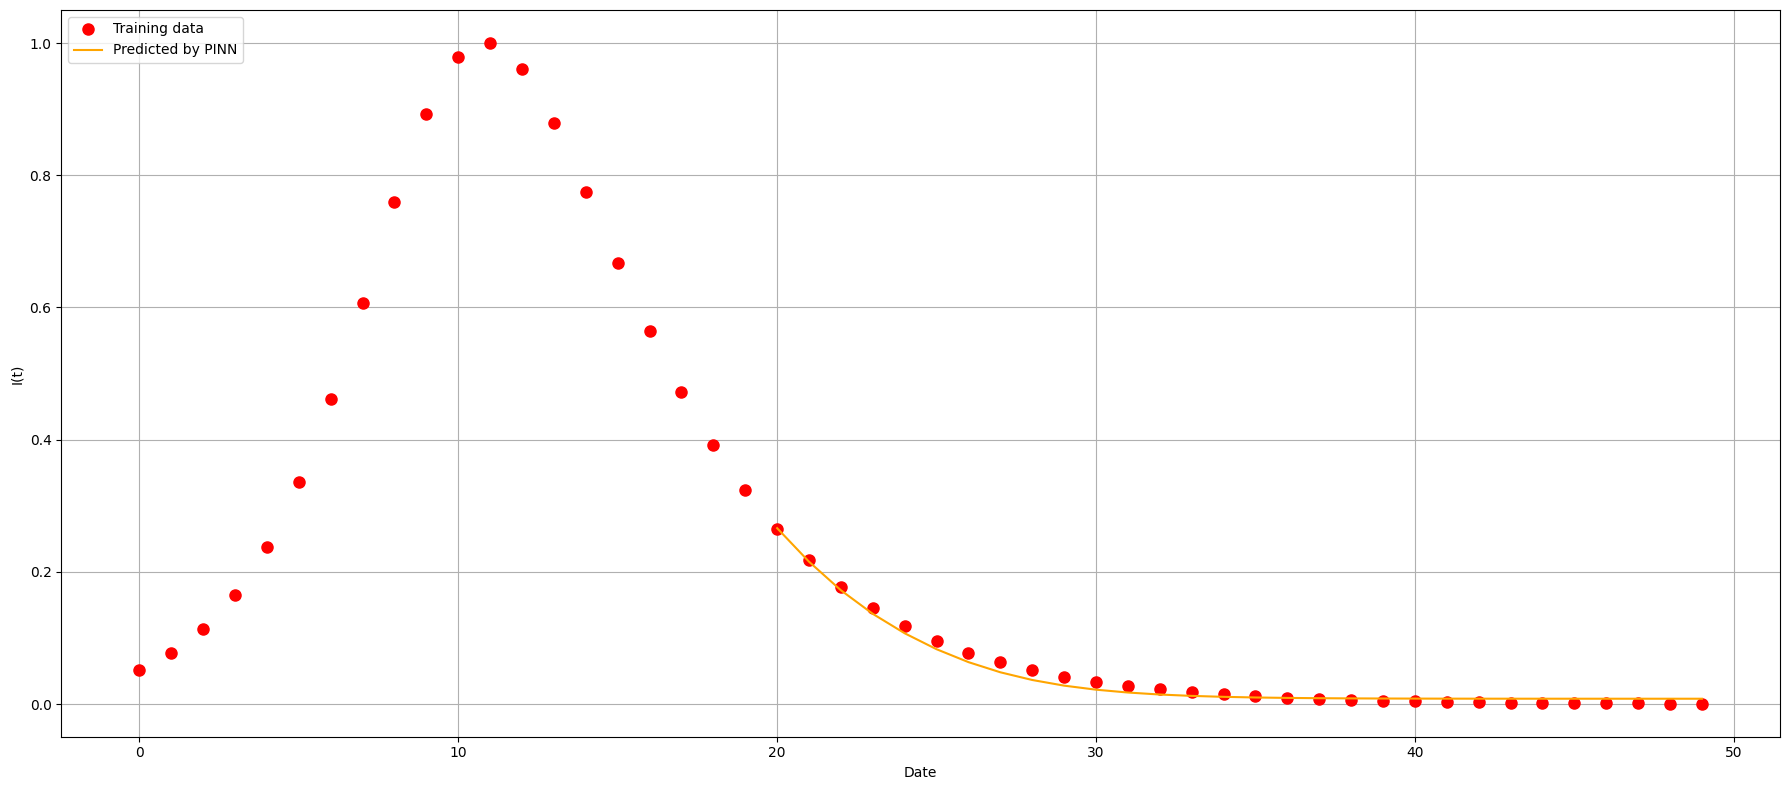

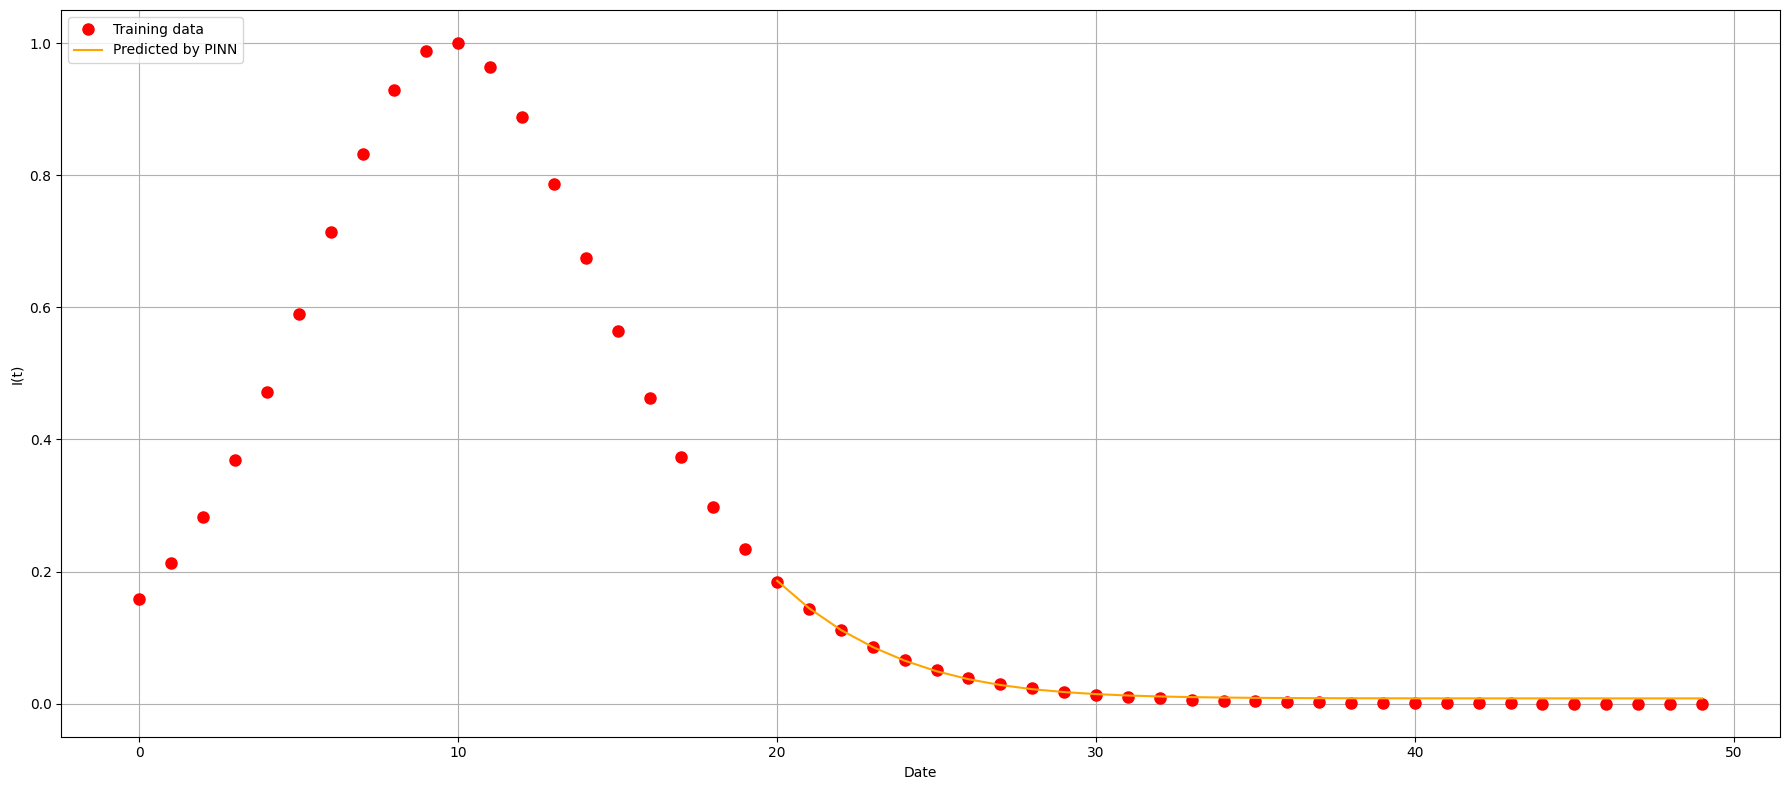

Epoch 400, Total Loss: 0.0382, SIR Loss: 0.03265917479146354, MSE Loss: 0.005510788167721557, Beta: 0.0027, Gamma: -0.0083
Epoch 410, Total Loss: 0.0436, SIR Loss: 0.03264486966688705, MSE Loss: 0.011001190678230277, Beta: 0.0011, Gamma: -0.0088
Epoch 420, Total Loss: 0.0367, SIR Loss: 0.0326592692827338, MSE Loss: 0.004002162084505659, Beta: 0.0026, Gamma: -0.0086
Epoch 430, Total Loss: 0.0451, SIR Loss: 0.03267725129812567, MSE Loss: 0.012440782904430148, Beta: 0.0030, Gamma: -0.0081
Epoch 440, Total Loss: 0.0377, SIR Loss: 0.032652501774664486, MSE Loss: 0.005037270092232126, Beta: 0.0029, Gamma: -0.0086


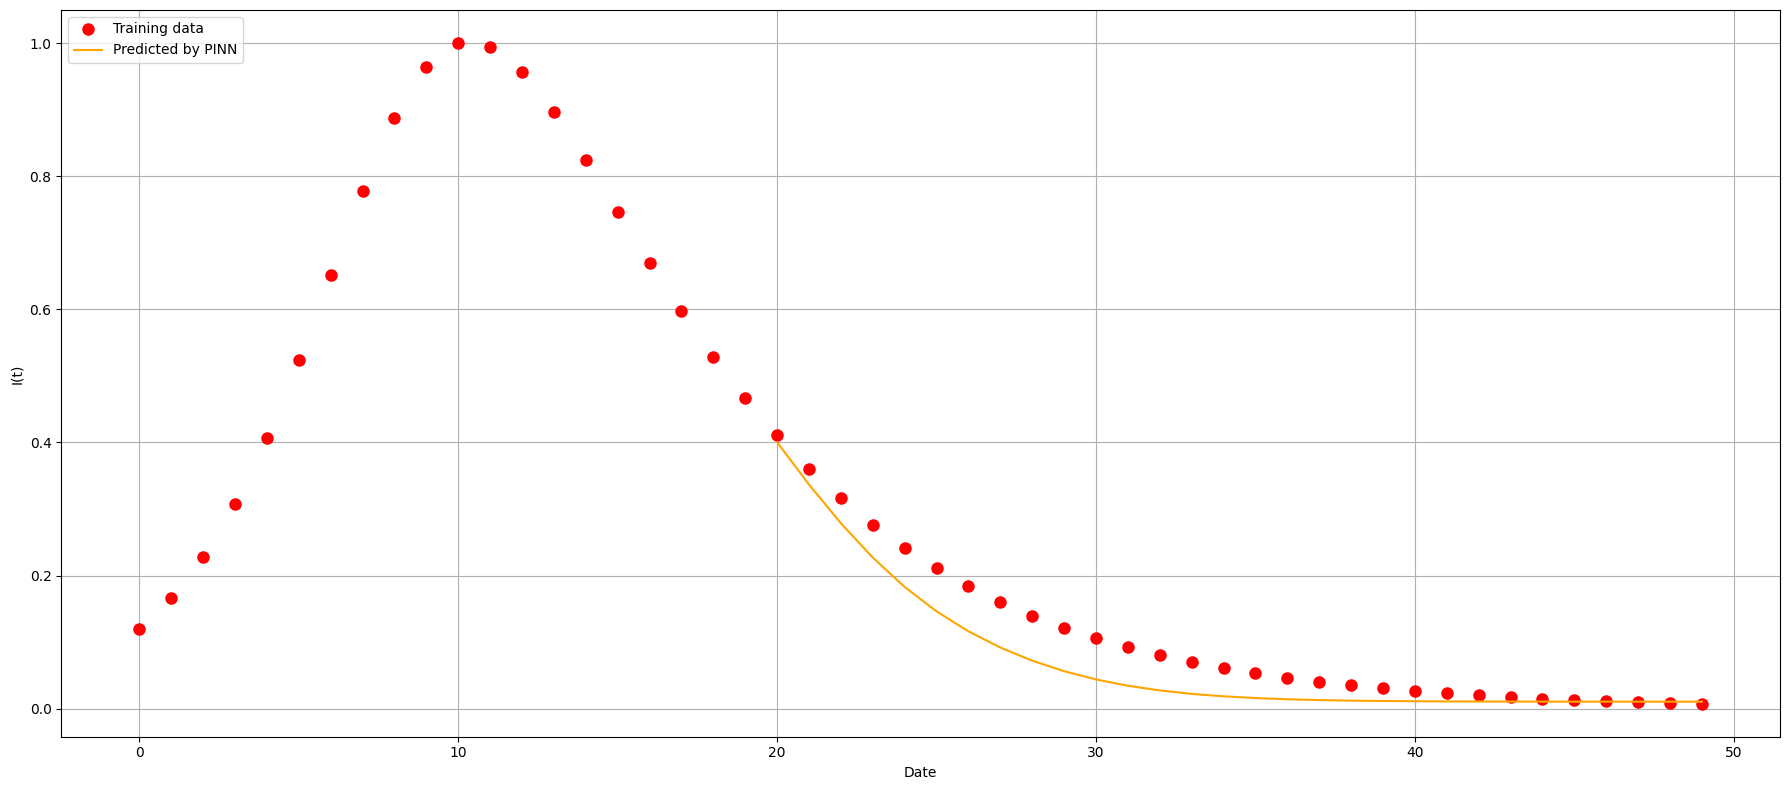

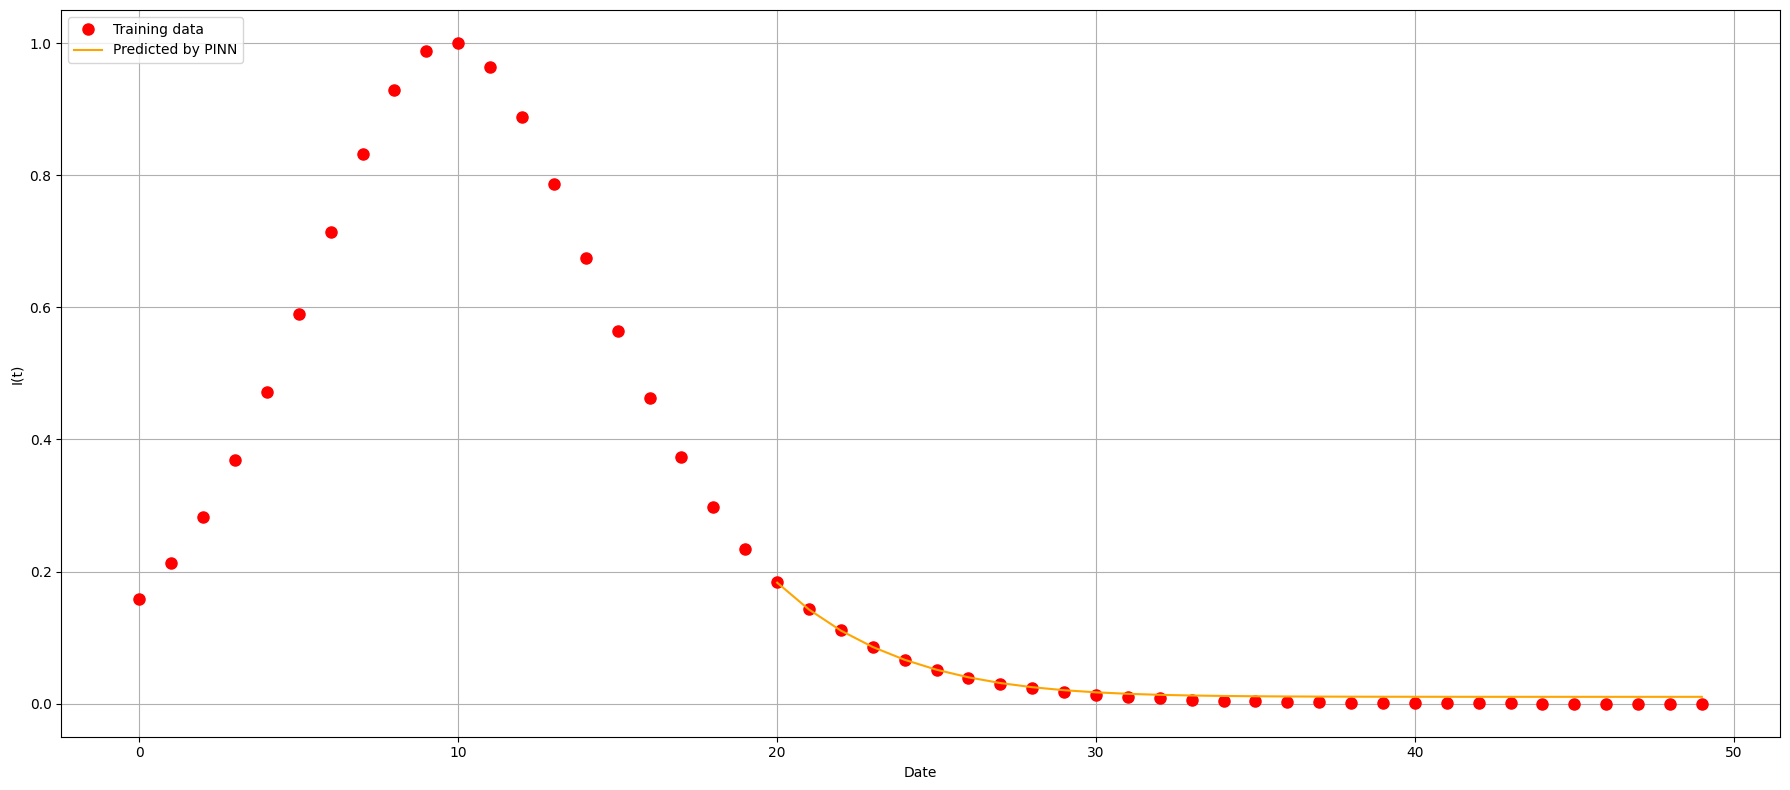

Epoch 450, Total Loss: 0.0380, SIR Loss: 0.03269225085608439, MSE Loss: 0.0052713657090781105, Beta: 0.0030, Gamma: -0.0082
Epoch 460, Total Loss: 0.0363, SIR Loss: 0.032637389605716806, MSE Loss: 0.0036987439457515426, Beta: 0.0022, Gamma: -0.0085
Epoch 470, Total Loss: 0.0366, SIR Loss: 0.03266828991534433, MSE Loss: 0.0038986050043596566, Beta: 0.0024, Gamma: -0.0085
Epoch 480, Total Loss: 0.0430, SIR Loss: 0.03262372410366475, MSE Loss: 0.010349199286047028, Beta: 0.0026, Gamma: -0.0086
Epoch 490, Total Loss: 0.0366, SIR Loss: 0.03265071539116669, MSE Loss: 0.003976778546227711, Beta: 0.0035, Gamma: -0.0084


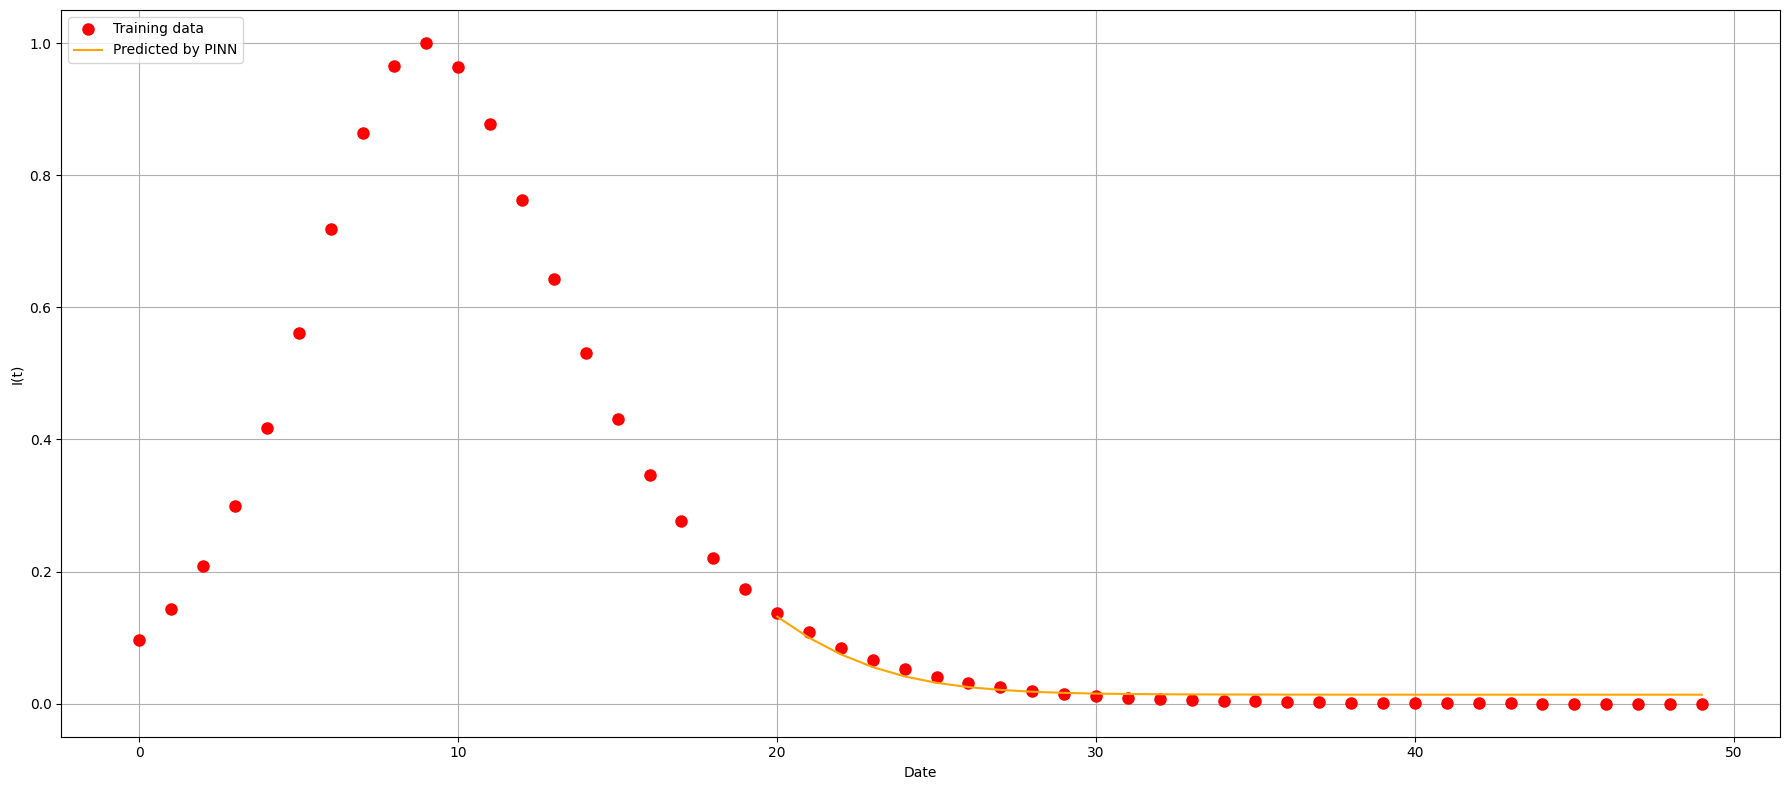

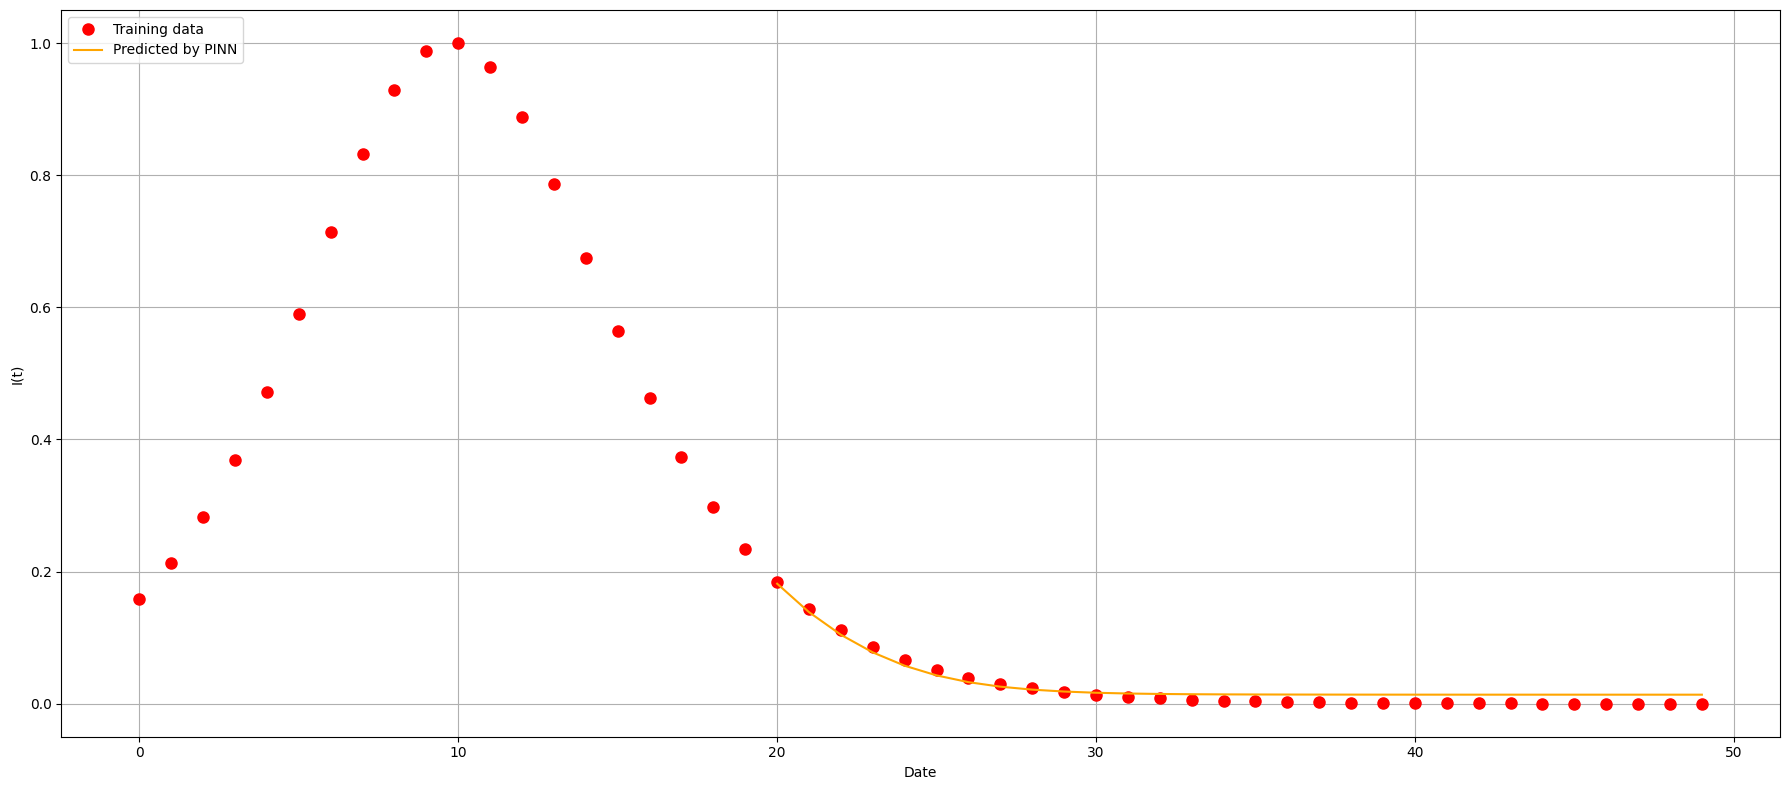

Epoch 500, Total Loss: 0.0406, SIR Loss: 0.03264063956763907, MSE Loss: 0.007915411917425974, Beta: 0.0023, Gamma: -0.0085
Epoch 510, Total Loss: 0.0405, SIR Loss: 0.032628263352830214, MSE Loss: 0.007847028024250701, Beta: 0.0021, Gamma: -0.0085
Epoch 520, Total Loss: 0.0375, SIR Loss: 0.032638760195226324, MSE Loss: 0.004834801929502325, Beta: 0.0022, Gamma: -0.0085
Epoch 530, Total Loss: 0.0374, SIR Loss: 0.03261101504150441, MSE Loss: 0.0048035323542164835, Beta: 0.0025, Gamma: -0.0086
Epoch 540, Total Loss: 0.0366, SIR Loss: 0.03263689691177312, MSE Loss: 0.00396705520371469, Beta: 0.0029, Gamma: -0.0086


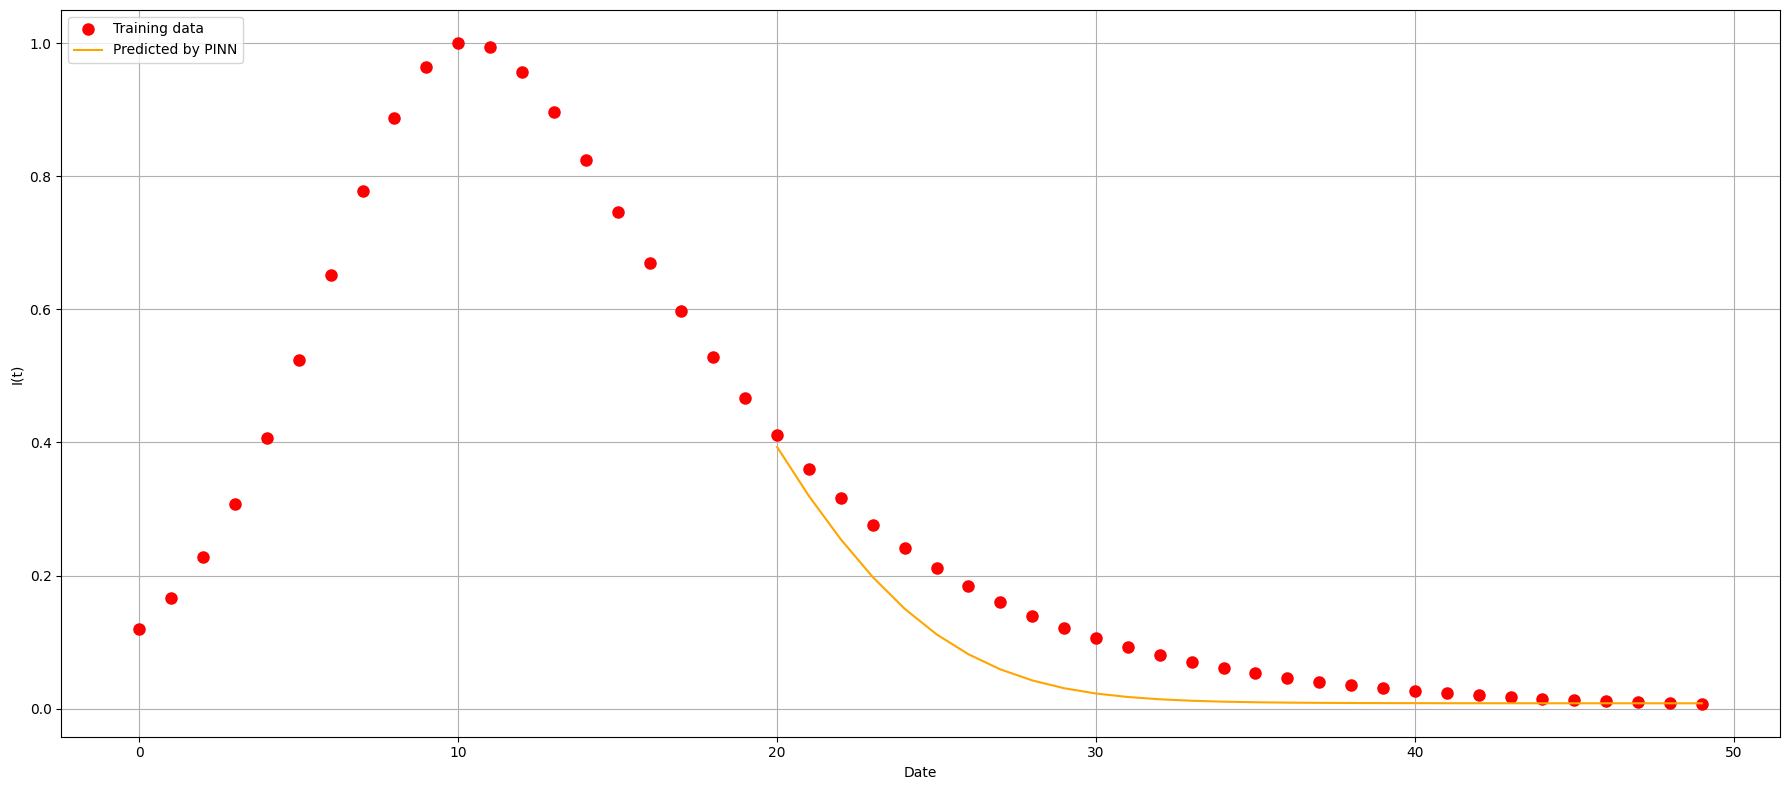

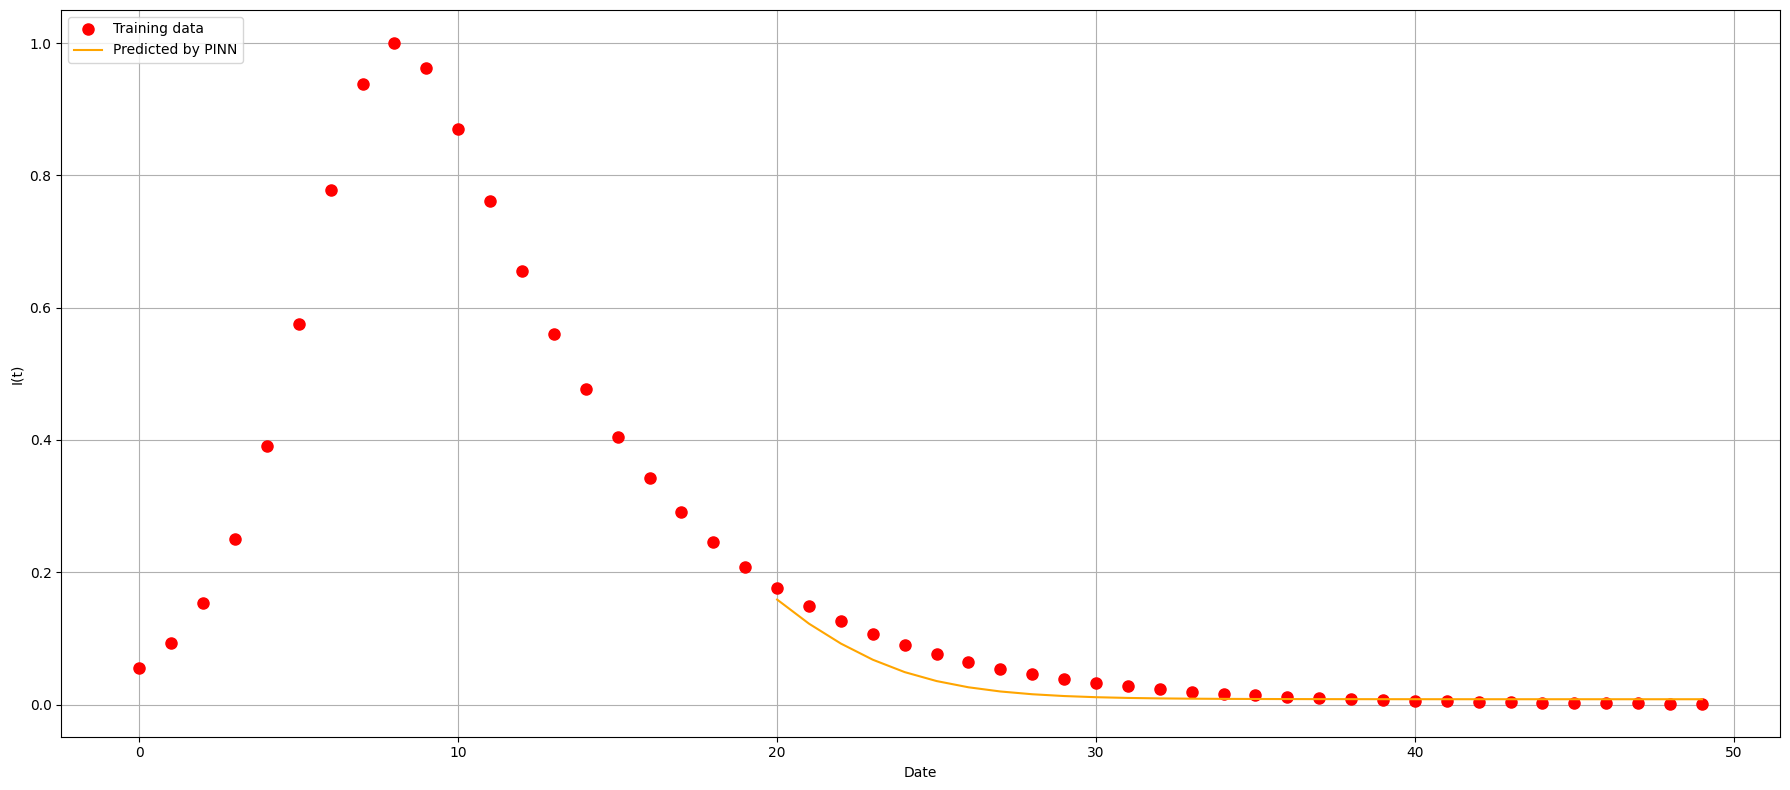

Epoch 550, Total Loss: 0.0397, SIR Loss: 0.032613211474224586, MSE Loss: 0.007045952854660835, Beta: 0.0019, Gamma: -0.0088
Epoch 560, Total Loss: 0.0402, SIR Loss: 0.03265097051806064, MSE Loss: 0.007584553229265943, Beta: 0.0031, Gamma: -0.0084
Epoch 570, Total Loss: 0.0418, SIR Loss: 0.032641508161021036, MSE Loss: 0.009122599725828108, Beta: 0.0024, Gamma: -0.0085
Epoch 580, Total Loss: 0.0359, SIR Loss: 0.03266113685401113, MSE Loss: 0.0032039182146040403, Beta: 0.0026, Gamma: -0.0085
Epoch 590, Total Loss: 0.0428, SIR Loss: 0.032588871764857315, MSE Loss: 0.010254691338691302, Beta: 0.0018, Gamma: -0.0089


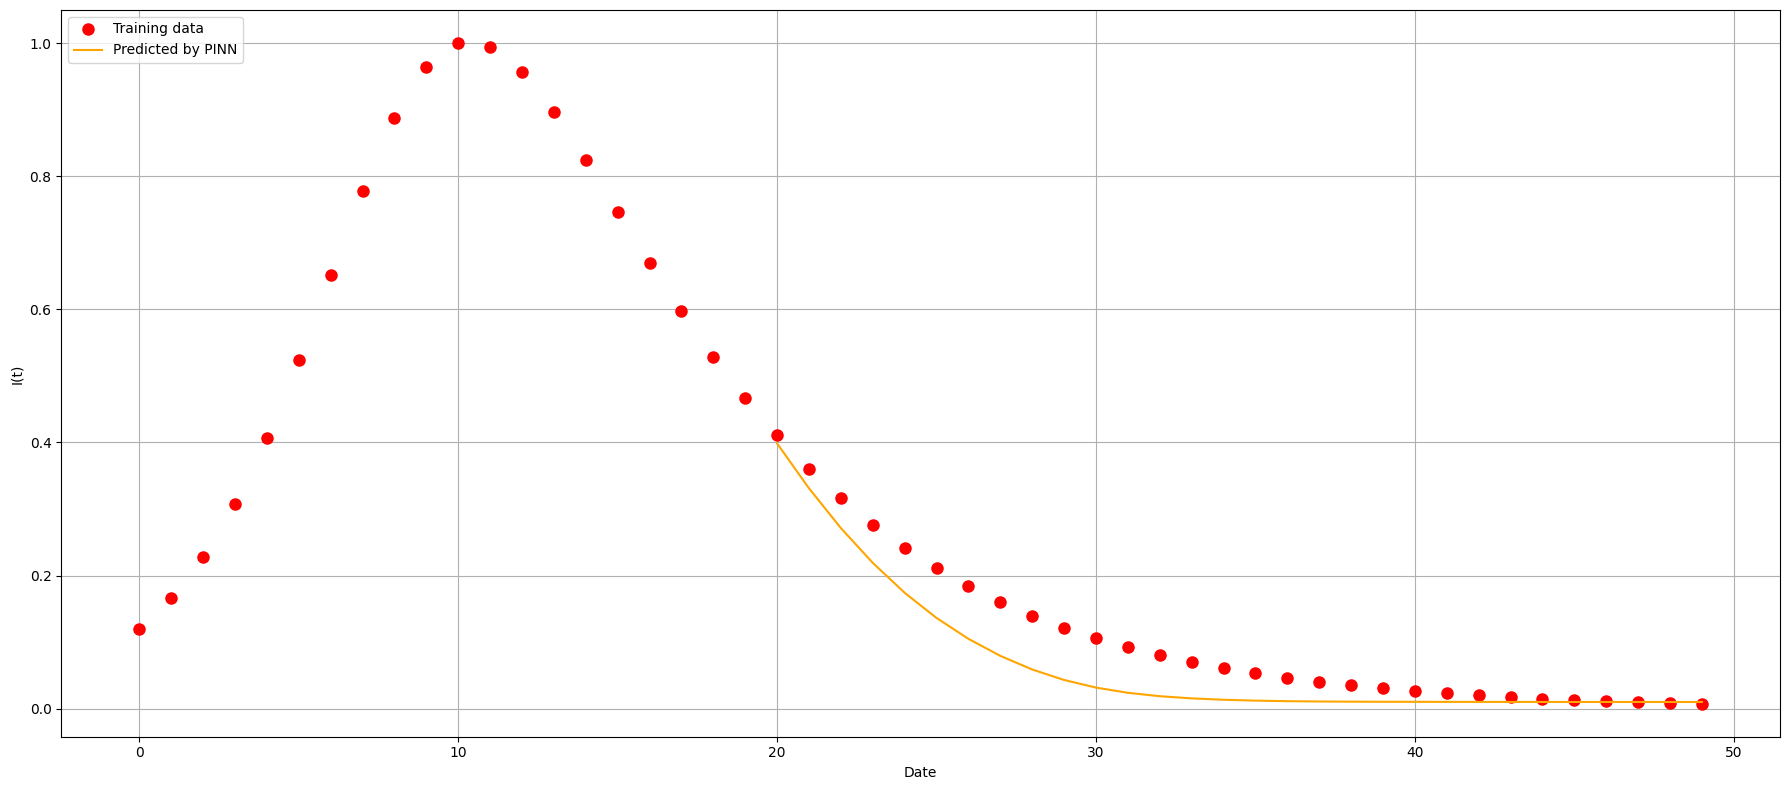

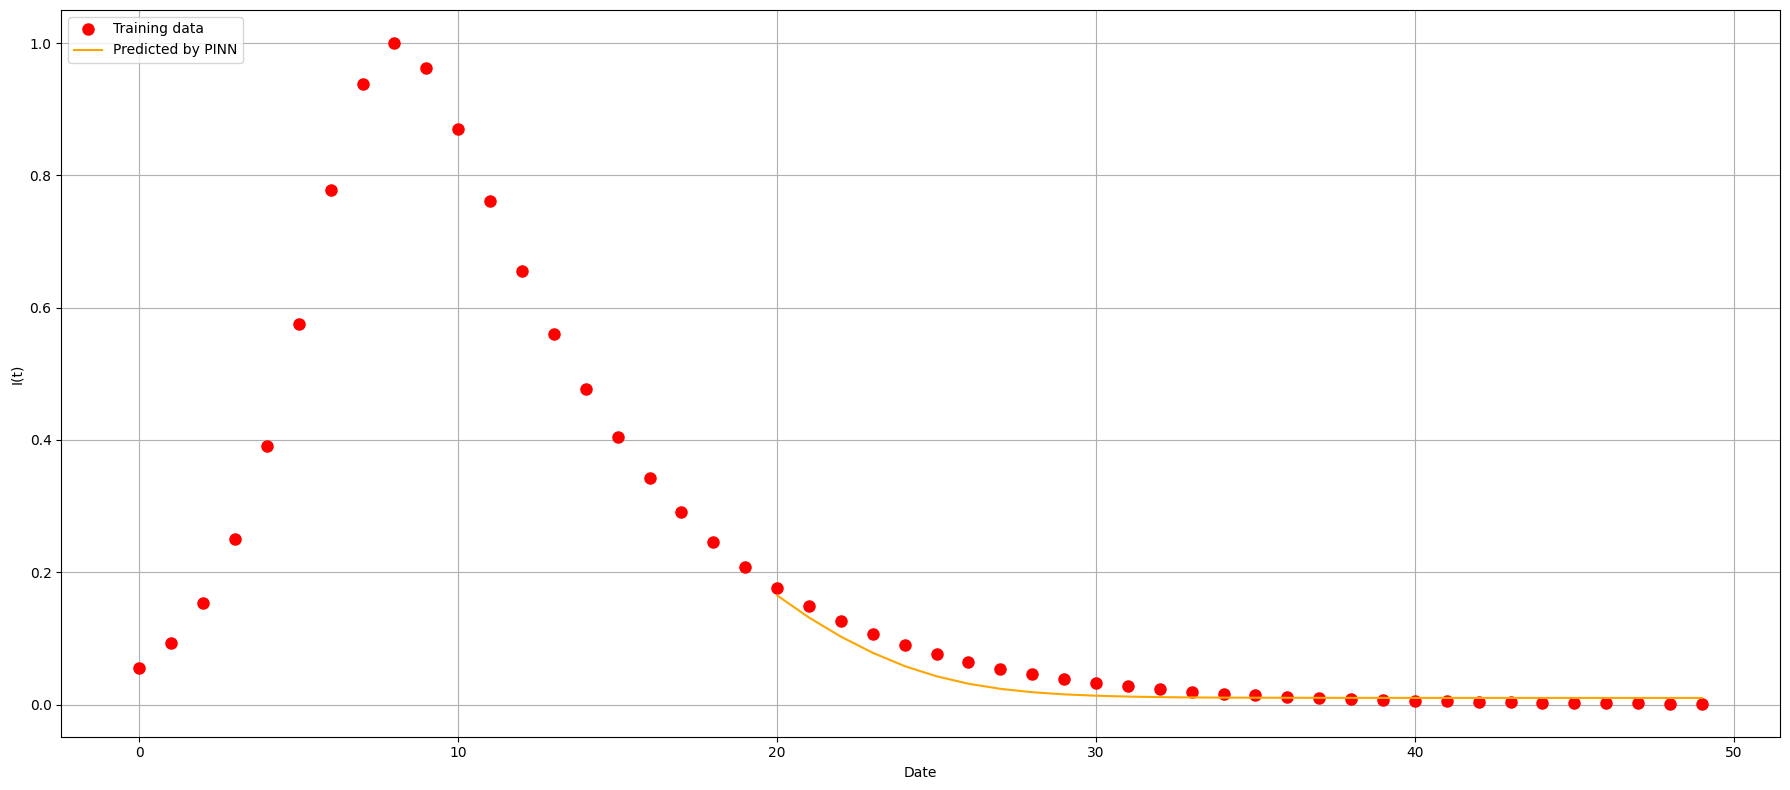

Epoch 600, Total Loss: 0.0363, SIR Loss: 0.03265809846630905, MSE Loss: 0.0036667219092936056, Beta: 0.0029, Gamma: -0.0085
Epoch 610, Total Loss: 0.0369, SIR Loss: 0.03264410879742033, MSE Loss: 0.004205997221398722, Beta: 0.0029, Gamma: -0.0085
Epoch 620, Total Loss: 0.0363, SIR Loss: 0.032637870814538145, MSE Loss: 0.0037014860016206935, Beta: 0.0025, Gamma: -0.0087
Epoch 630, Total Loss: 0.0366, SIR Loss: 0.0326060347033474, MSE Loss: 0.004037528448461014, Beta: 0.0027, Gamma: -0.0086
Epoch 640, Total Loss: 0.0408, SIR Loss: 0.03270924890341664, MSE Loss: 0.008051672197978707, Beta: 0.0033, Gamma: -0.0080


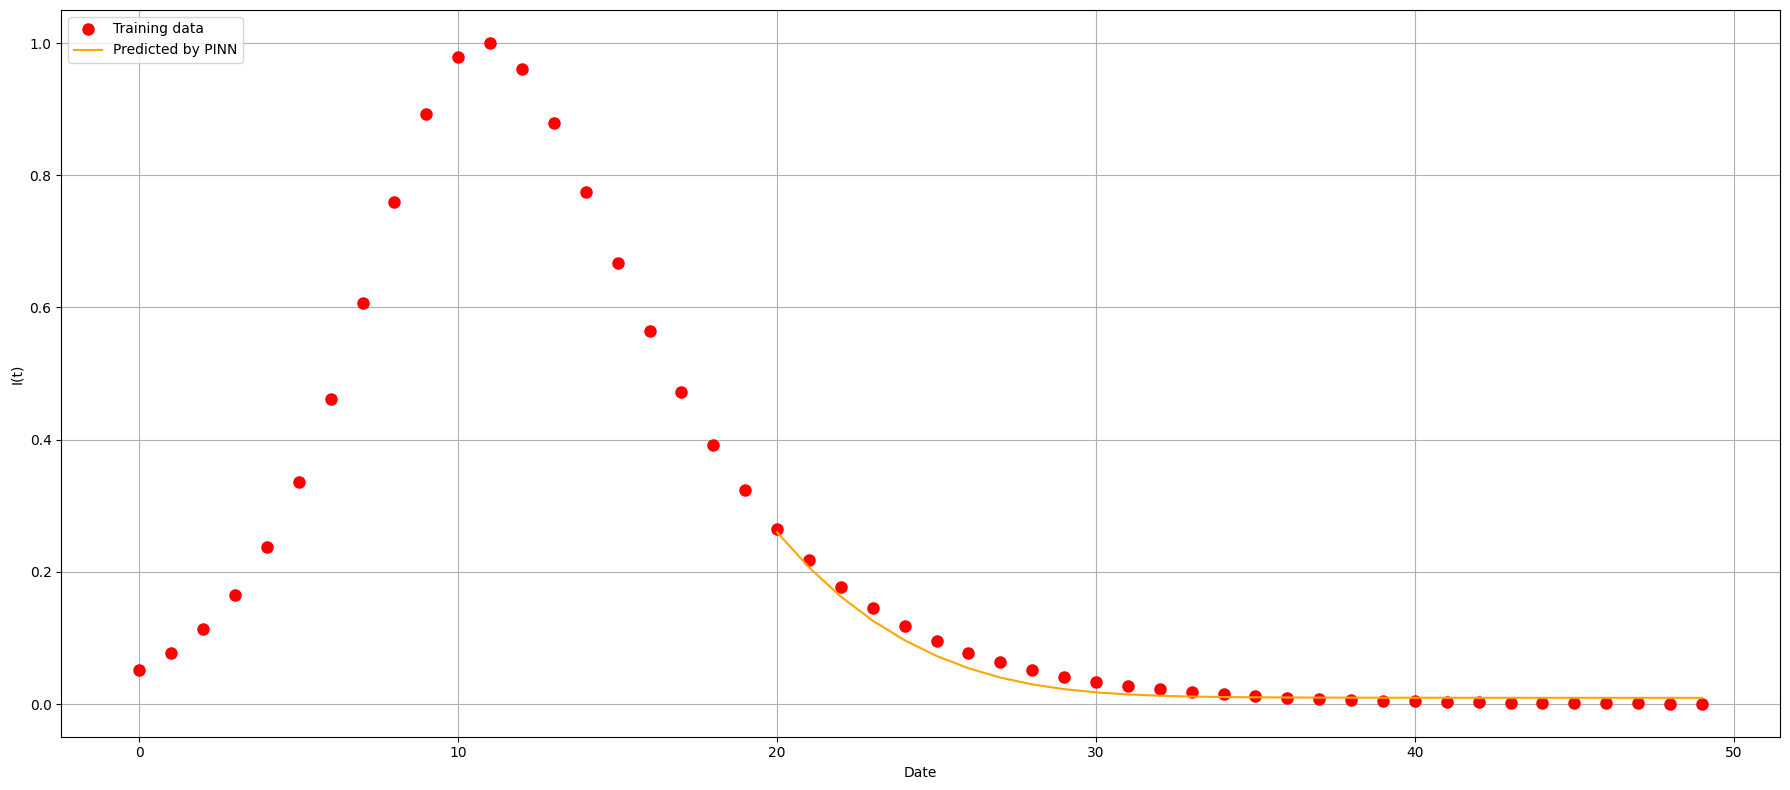

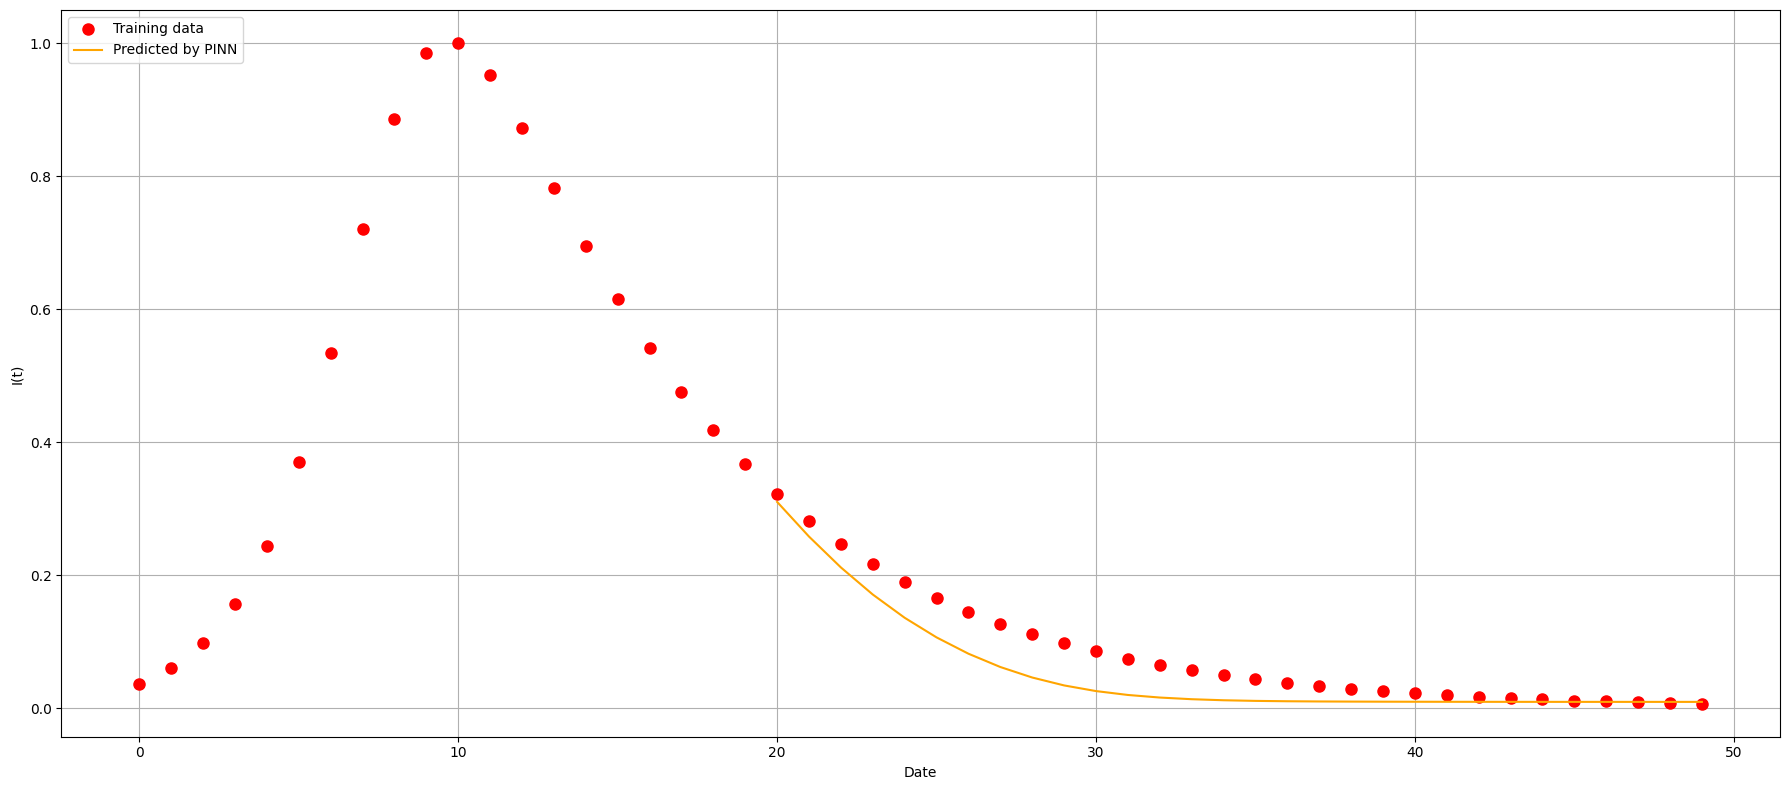

Epoch 650, Total Loss: 0.0373, SIR Loss: 0.0326256194040631, MSE Loss: 0.00466479602597884, Beta: 0.0022, Gamma: -0.0085
Epoch 660, Total Loss: 0.0380, SIR Loss: 0.03269065527797317, MSE Loss: 0.005314234977838073, Beta: 0.0033, Gamma: -0.0084
Epoch 670, Total Loss: 0.0383, SIR Loss: 0.03265636458793556, MSE Loss: 0.005613615007008861, Beta: 0.0027, Gamma: -0.0085
Epoch 680, Total Loss: 0.0385, SIR Loss: 0.03266772403904226, MSE Loss: 0.005865920238755188, Beta: 0.0033, Gamma: -0.0081
Epoch 690, Total Loss: 0.0384, SIR Loss: 0.03258635237922043, MSE Loss: 0.00580662941084035, Beta: 0.0021, Gamma: -0.0087


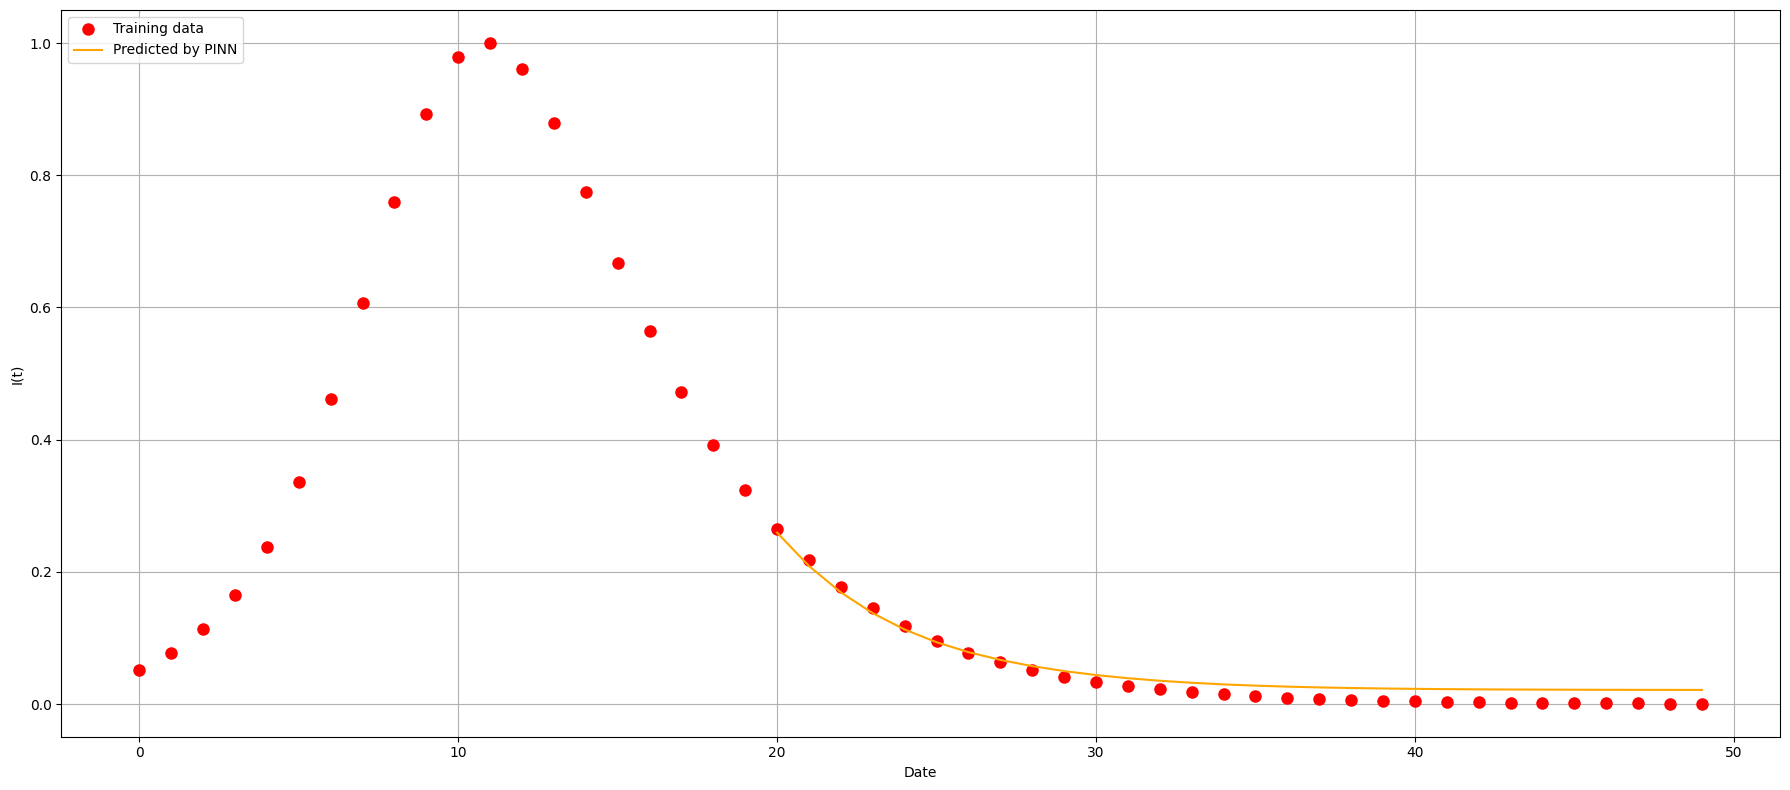

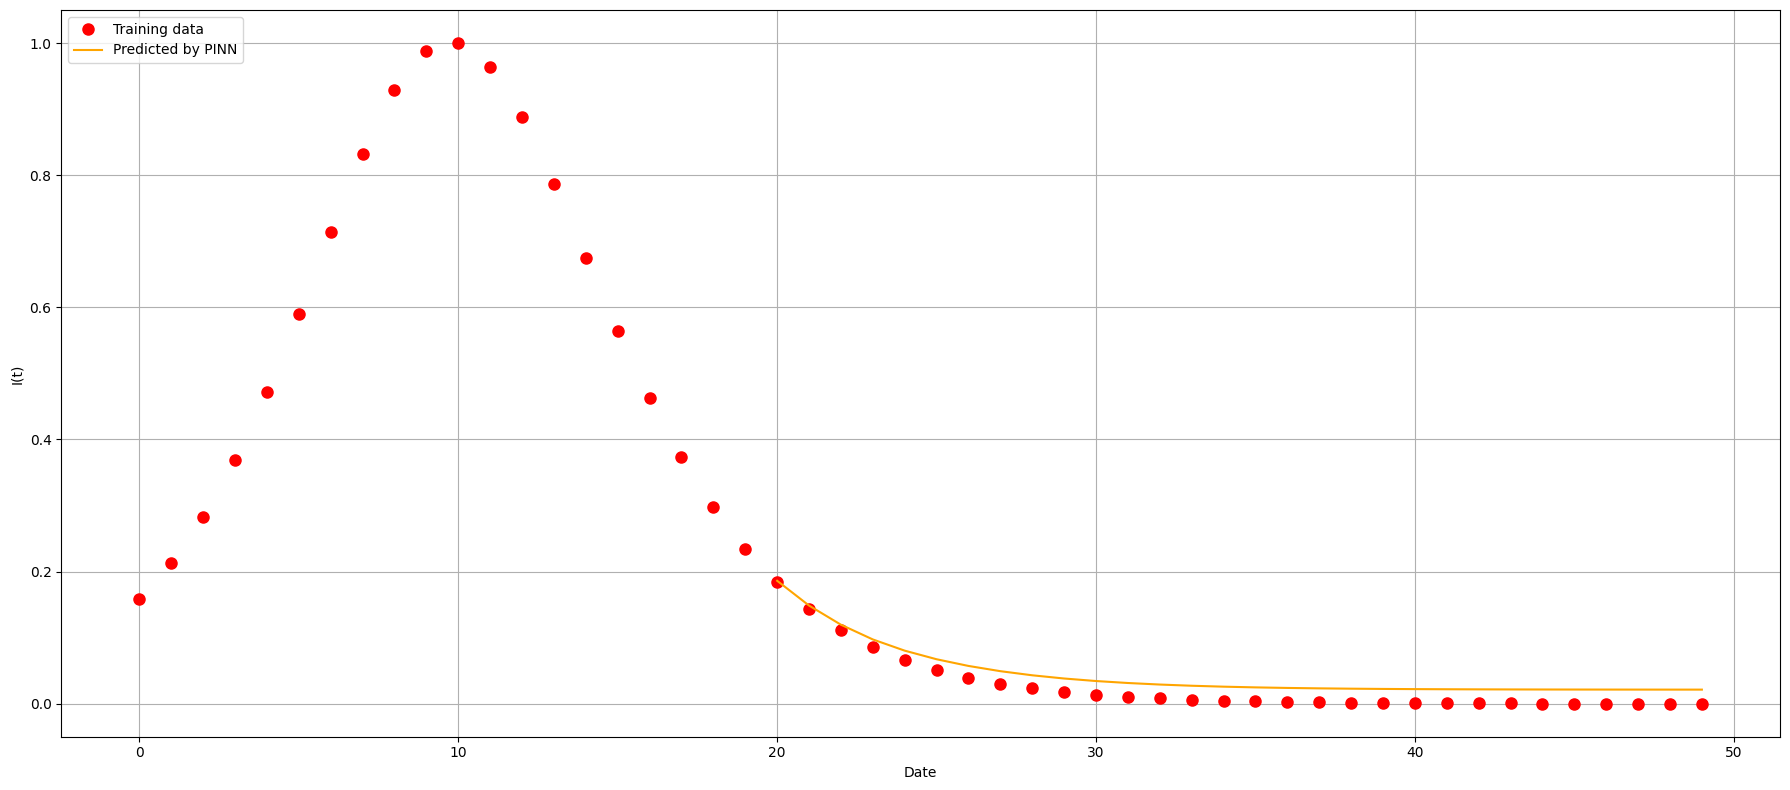

Epoch 700, Total Loss: 0.0399, SIR Loss: 0.03268823230249362, MSE Loss: 0.007204211397199858, Beta: 0.0033, Gamma: -0.0084
Epoch 710, Total Loss: 0.0437, SIR Loss: 0.0326485024444848, MSE Loss: 0.011084180865189853, Beta: 0.0022, Gamma: -0.0084
Epoch 720, Total Loss: 0.0353, SIR Loss: 0.03264101880876152, MSE Loss: 0.002616735534441579, Beta: 0.0032, Gamma: -0.0085
Epoch 730, Total Loss: 0.0358, SIR Loss: 0.03263407575509969, MSE Loss: 0.003179178193200982, Beta: 0.0030, Gamma: -0.0085
Epoch 740, Total Loss: 0.0399, SIR Loss: 0.0325948088289907, MSE Loss: 0.007272253019201408, Beta: 0.0017, Gamma: -0.0089


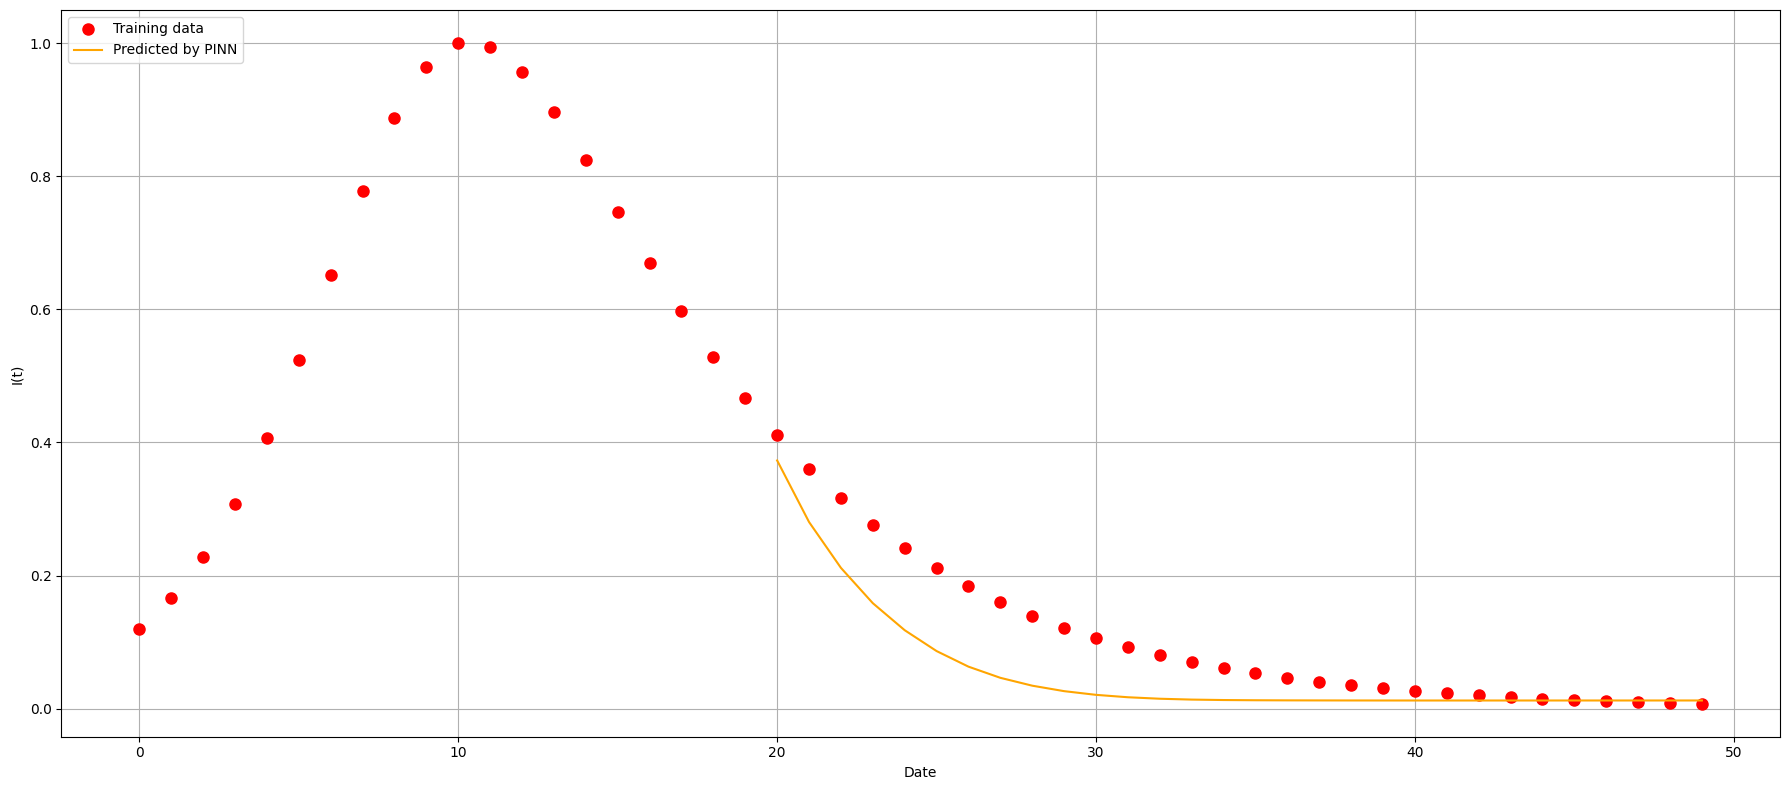

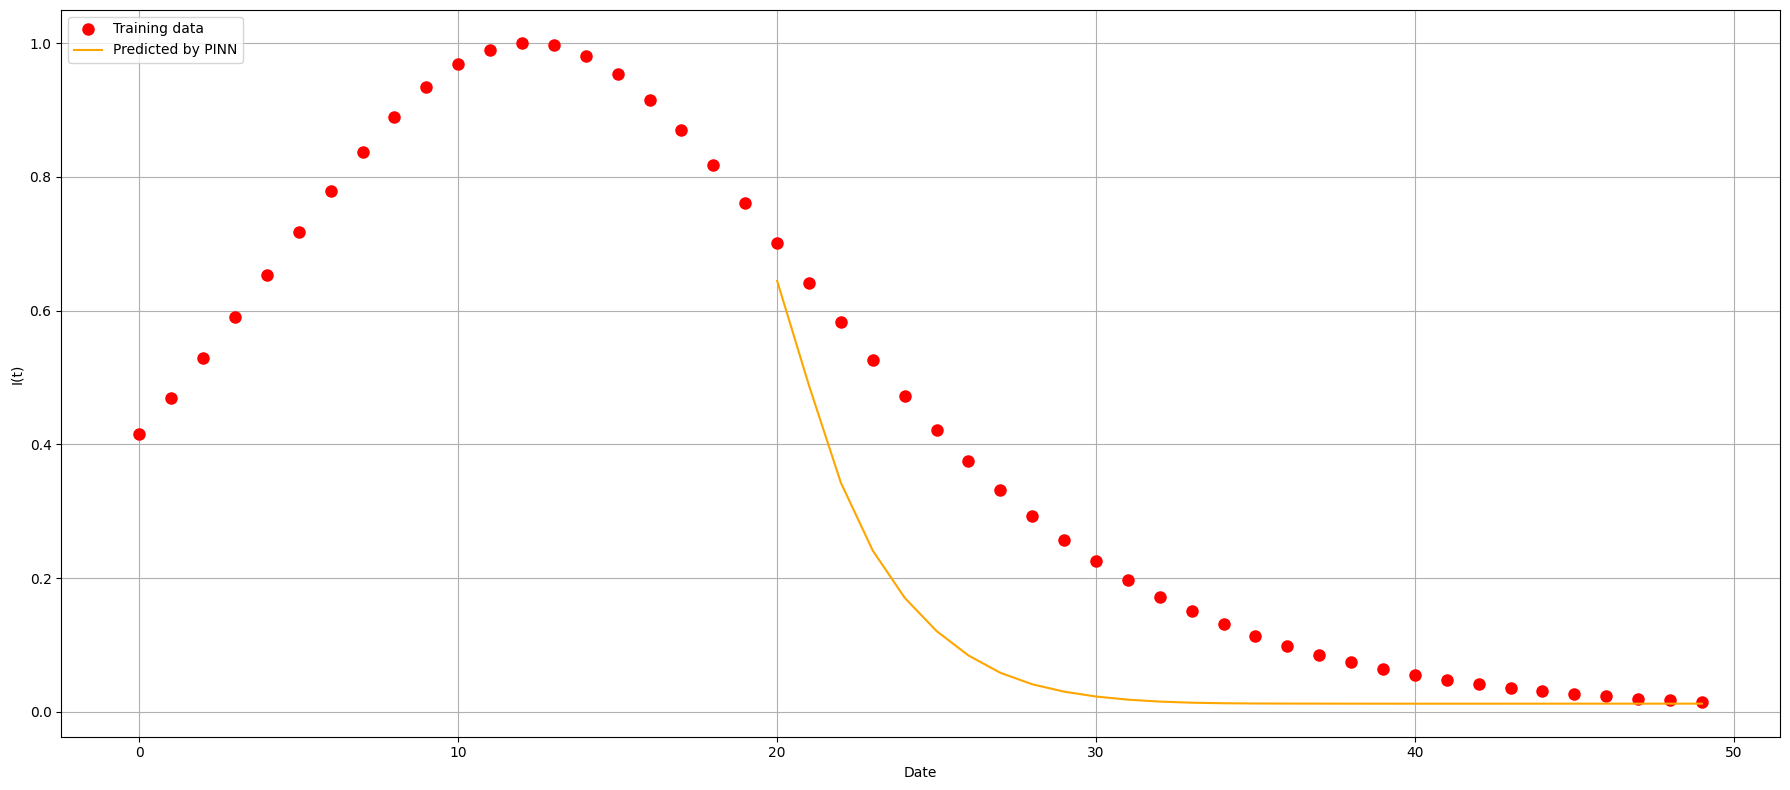

Epoch 750, Total Loss: 0.0374, SIR Loss: 0.032628830768348764, MSE Loss: 0.004796344358057536, Beta: 0.0023, Gamma: -0.0088
Epoch 760, Total Loss: 0.0386, SIR Loss: 0.03260799517052196, MSE Loss: 0.005987086519999213, Beta: 0.0024, Gamma: -0.0086
Epoch 770, Total Loss: 0.0436, SIR Loss: 0.03264970836362018, MSE Loss: 0.010935632857025996, Beta: 0.0025, Gamma: -0.0083
Epoch 780, Total Loss: 0.0366, SIR Loss: 0.03266926892604277, MSE Loss: 0.003900471056207902, Beta: 0.0028, Gamma: -0.0085
Epoch 790, Total Loss: 0.0368, SIR Loss: 0.03266056552744848, MSE Loss: 0.004152876488186341, Beta: 0.0032, Gamma: -0.0085


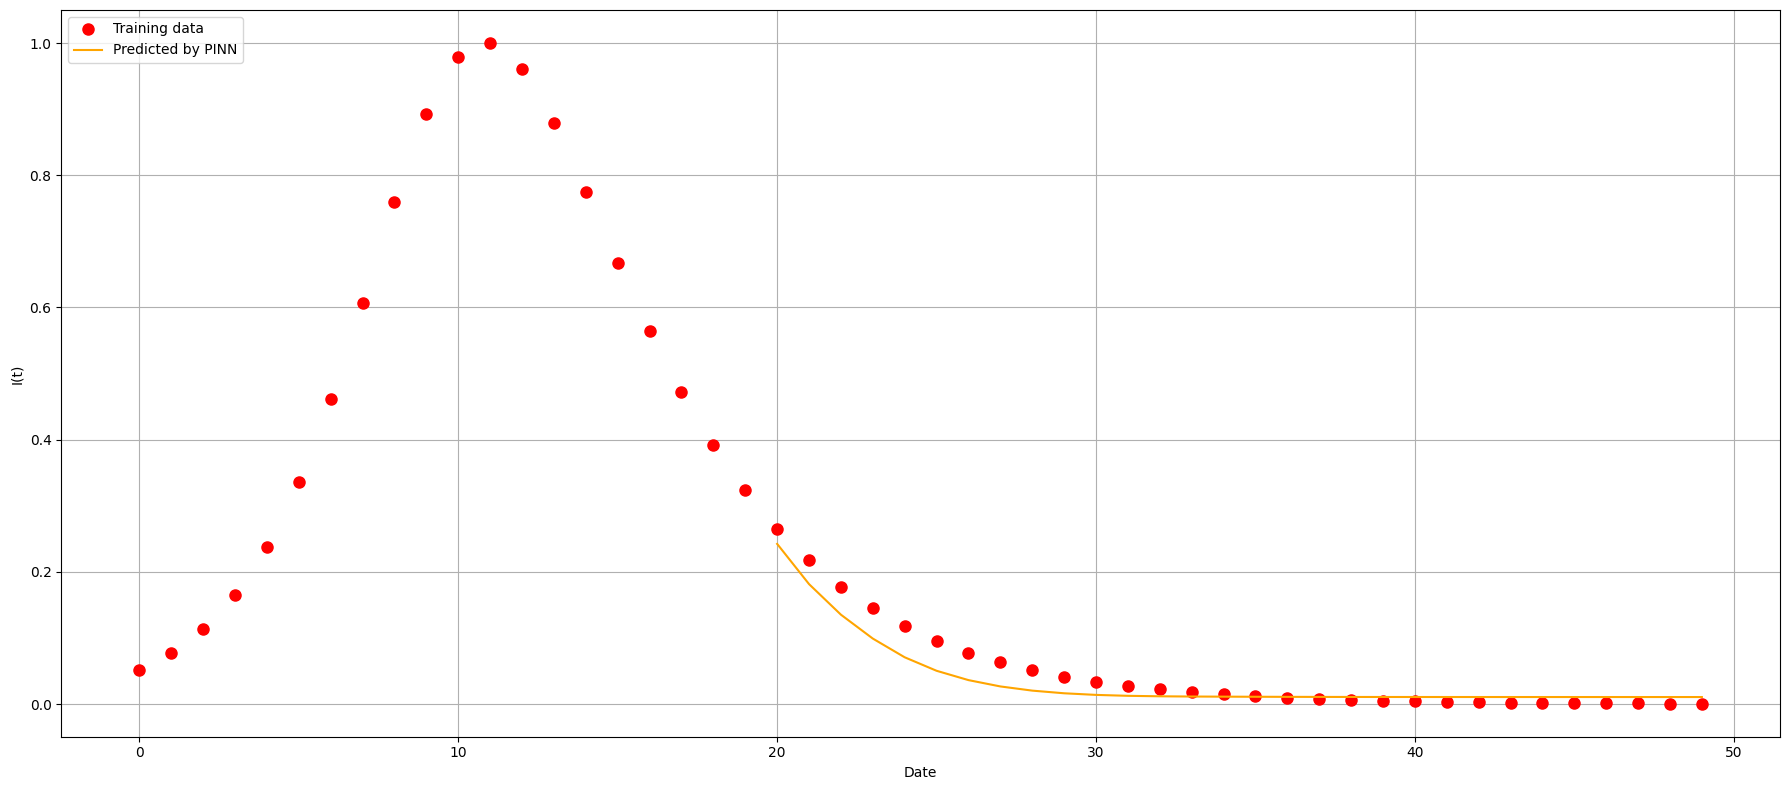

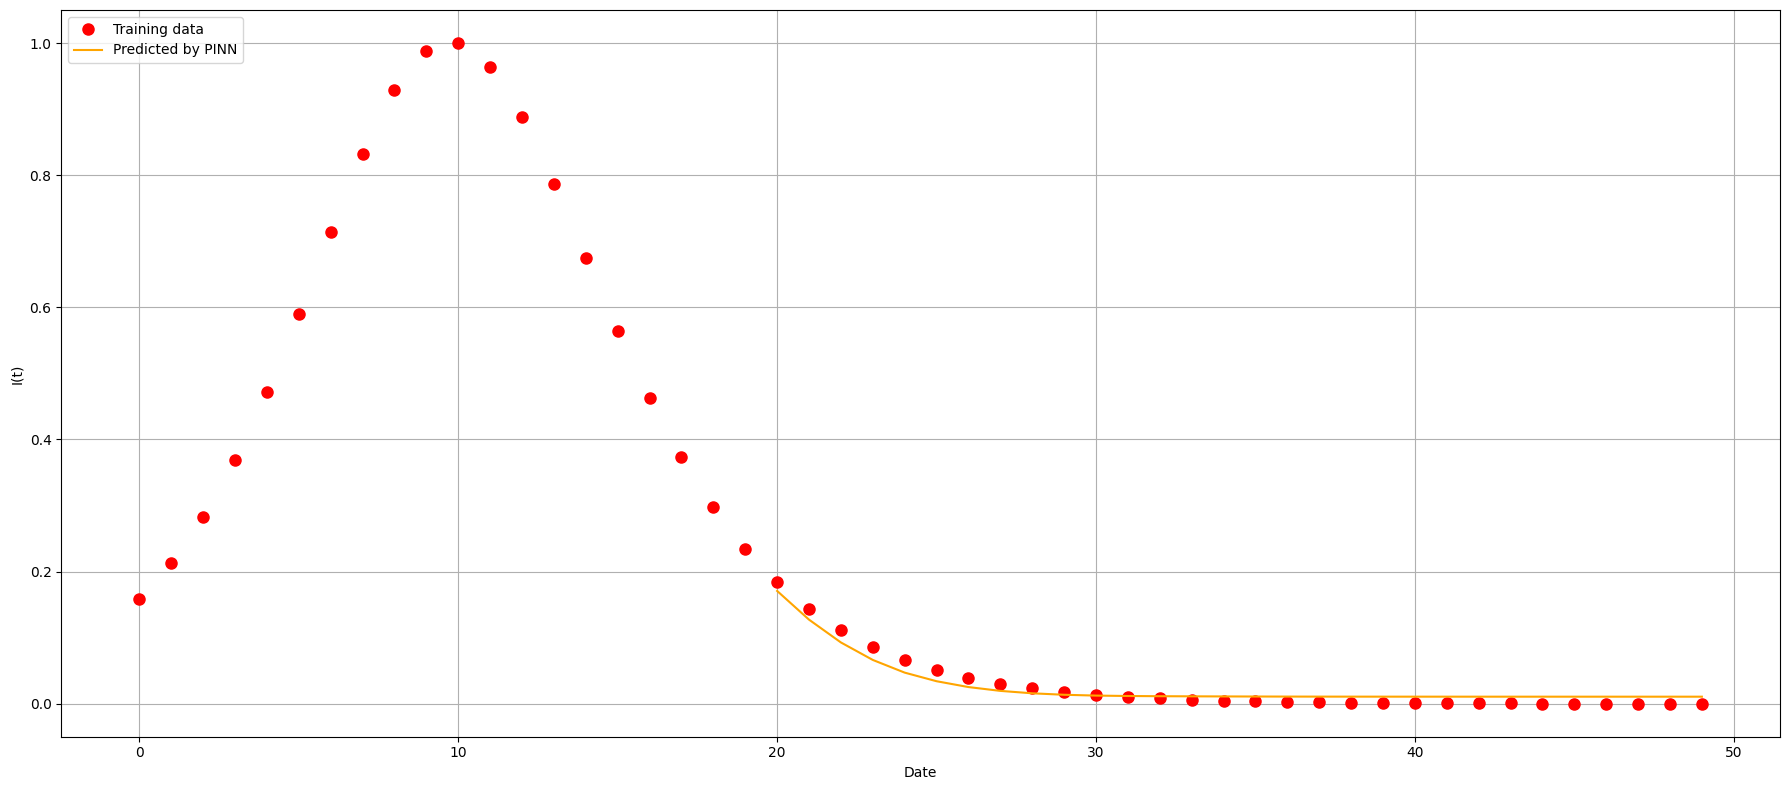

Epoch 800, Total Loss: 0.0392, SIR Loss: 0.032635599854842275, MSE Loss: 0.006593868706552292, Beta: 0.0016, Gamma: -0.0086
Epoch 810, Total Loss: 0.0370, SIR Loss: 0.032627404601509744, MSE Loss: 0.0043961221383393536, Beta: 0.0032, Gamma: -0.0085
Epoch 820, Total Loss: 0.0411, SIR Loss: 0.0326515572870239, MSE Loss: 0.008498303720762745, Beta: 0.0026, Gamma: -0.0084
Epoch 830, Total Loss: 0.0356, SIR Loss: 0.03261495149327474, MSE Loss: 0.0029863428838719465, Beta: 0.0022, Gamma: -0.0087
Epoch 840, Total Loss: 0.0358, SIR Loss: 0.032617597443582905, MSE Loss: 0.0031898681073492473, Beta: 0.0030, Gamma: -0.0086


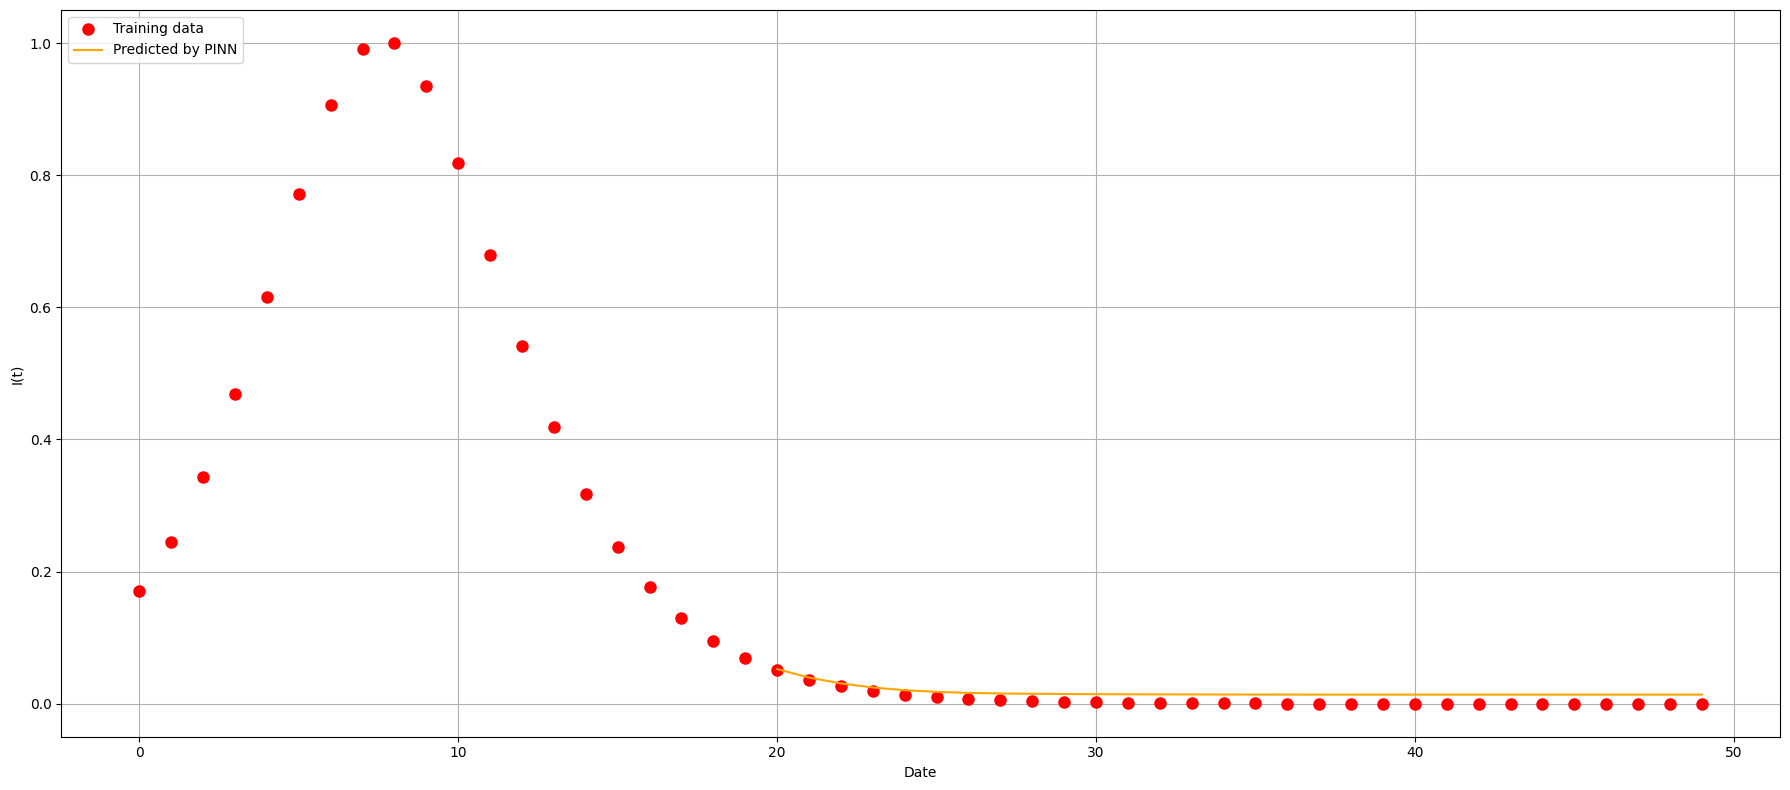

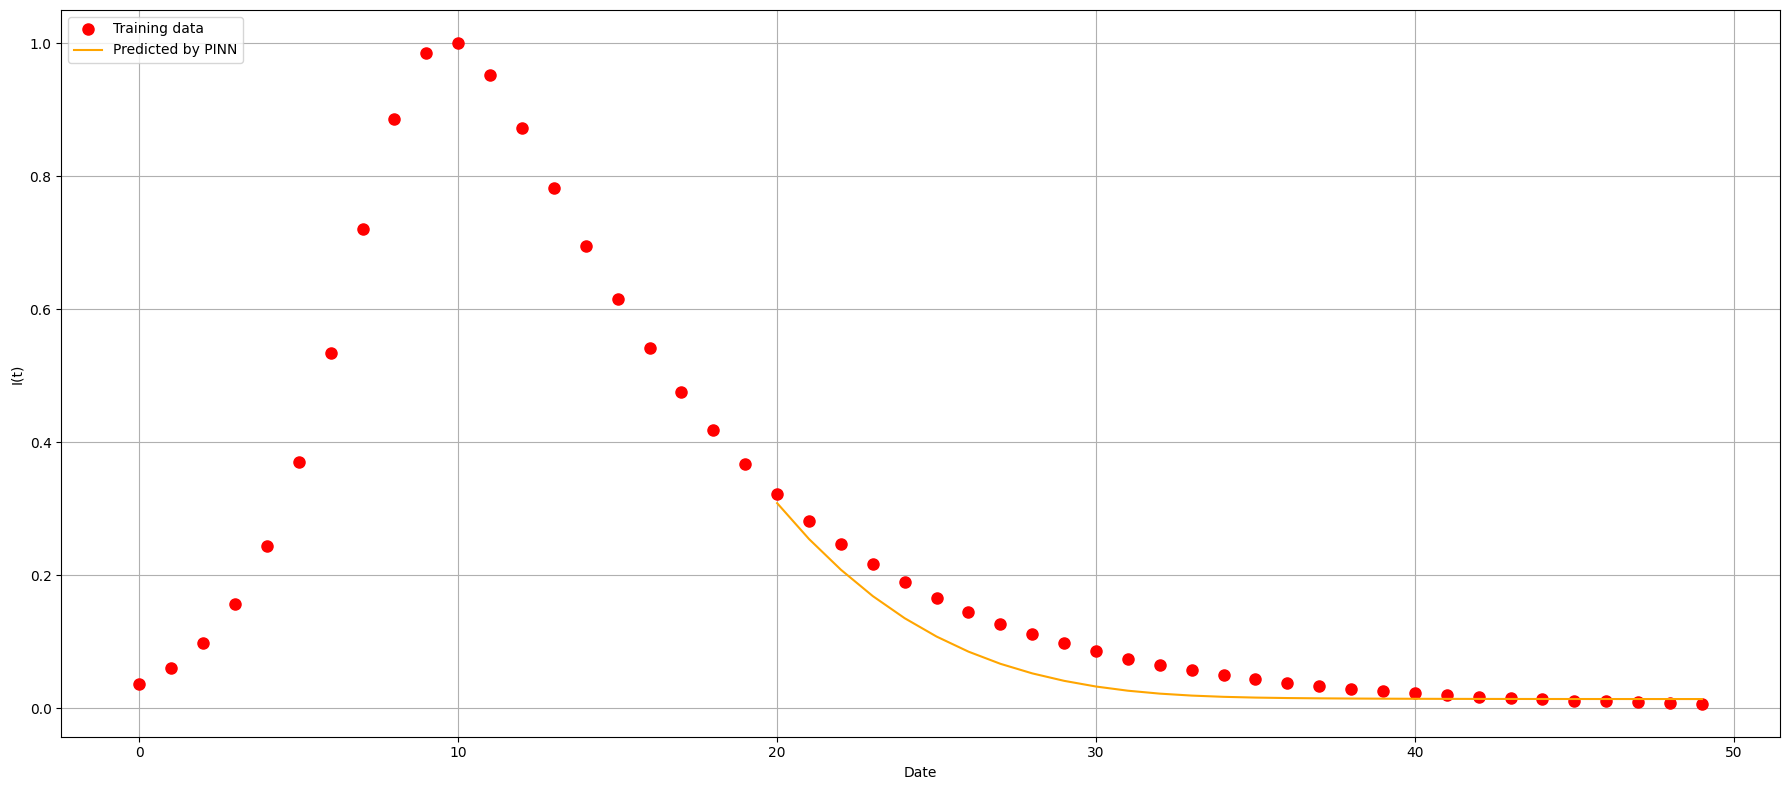

Epoch 850, Total Loss: 0.0358, SIR Loss: 0.032669955112586746, MSE Loss: 0.0031797406941005356, Beta: 0.0029, Gamma: -0.0084
Epoch 860, Total Loss: 0.0365, SIR Loss: 0.032625024031109694, MSE Loss: 0.003826942720895149, Beta: 0.0026, Gamma: -0.0086
Epoch 870, Total Loss: 0.0376, SIR Loss: 0.03261483843770334, MSE Loss: 0.00496335822860452, Beta: 0.0025, Gamma: -0.0088
Epoch 880, Total Loss: 0.0360, SIR Loss: 0.032620087602626295, MSE Loss: 0.0033583557227028133, Beta: 0.0027, Gamma: -0.0086
Epoch 890, Total Loss: 0.0367, SIR Loss: 0.0326364842401623, MSE Loss: 0.004073435490021589, Beta: 0.0029, Gamma: -0.0085


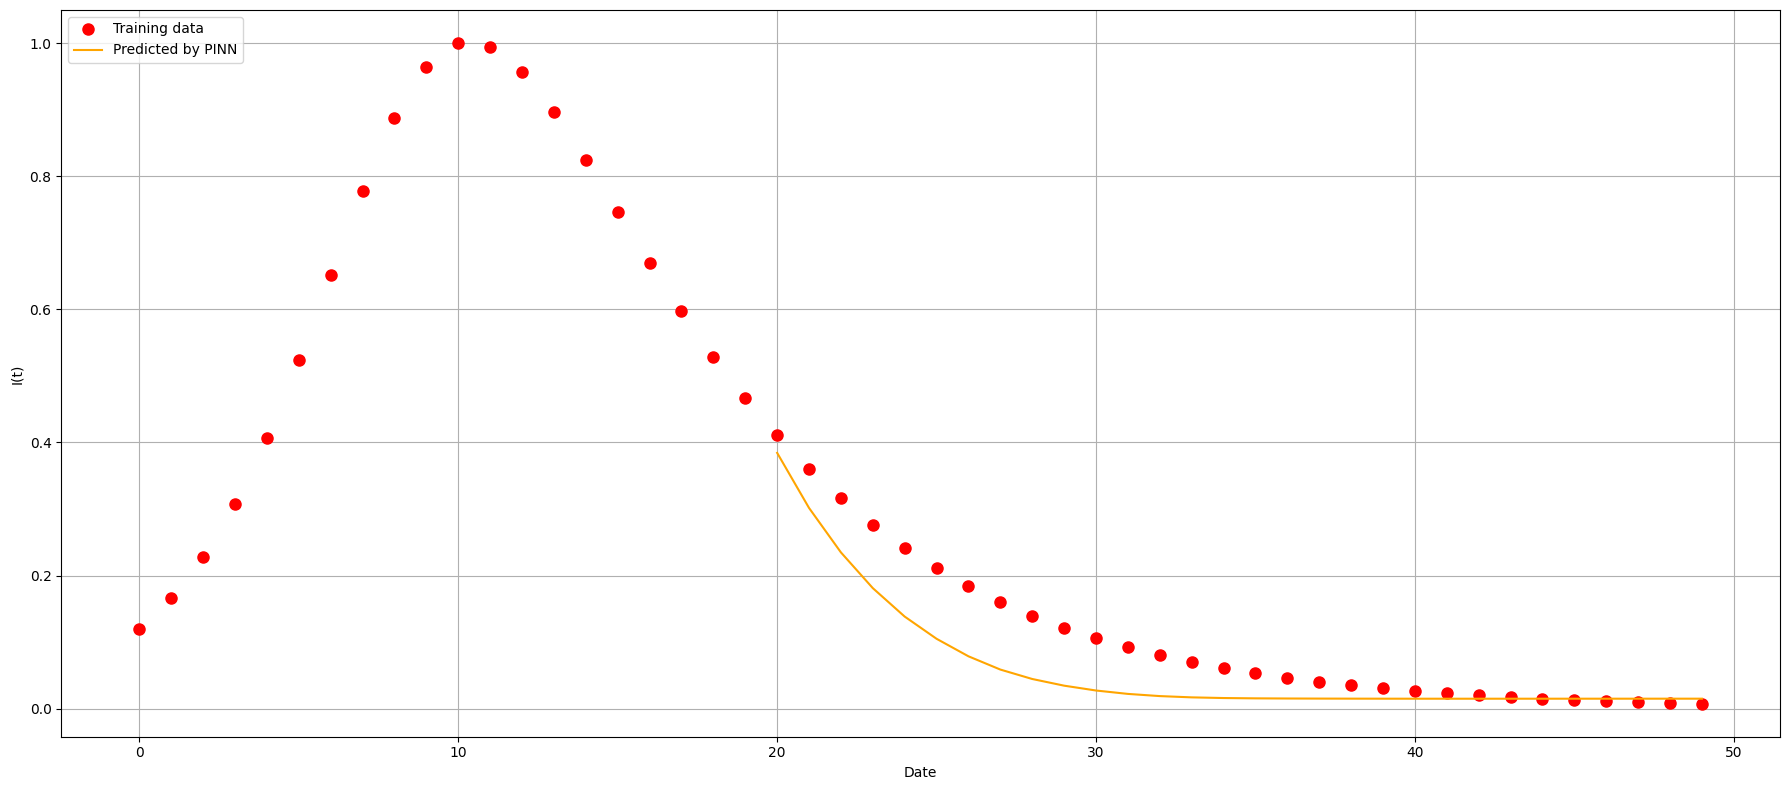

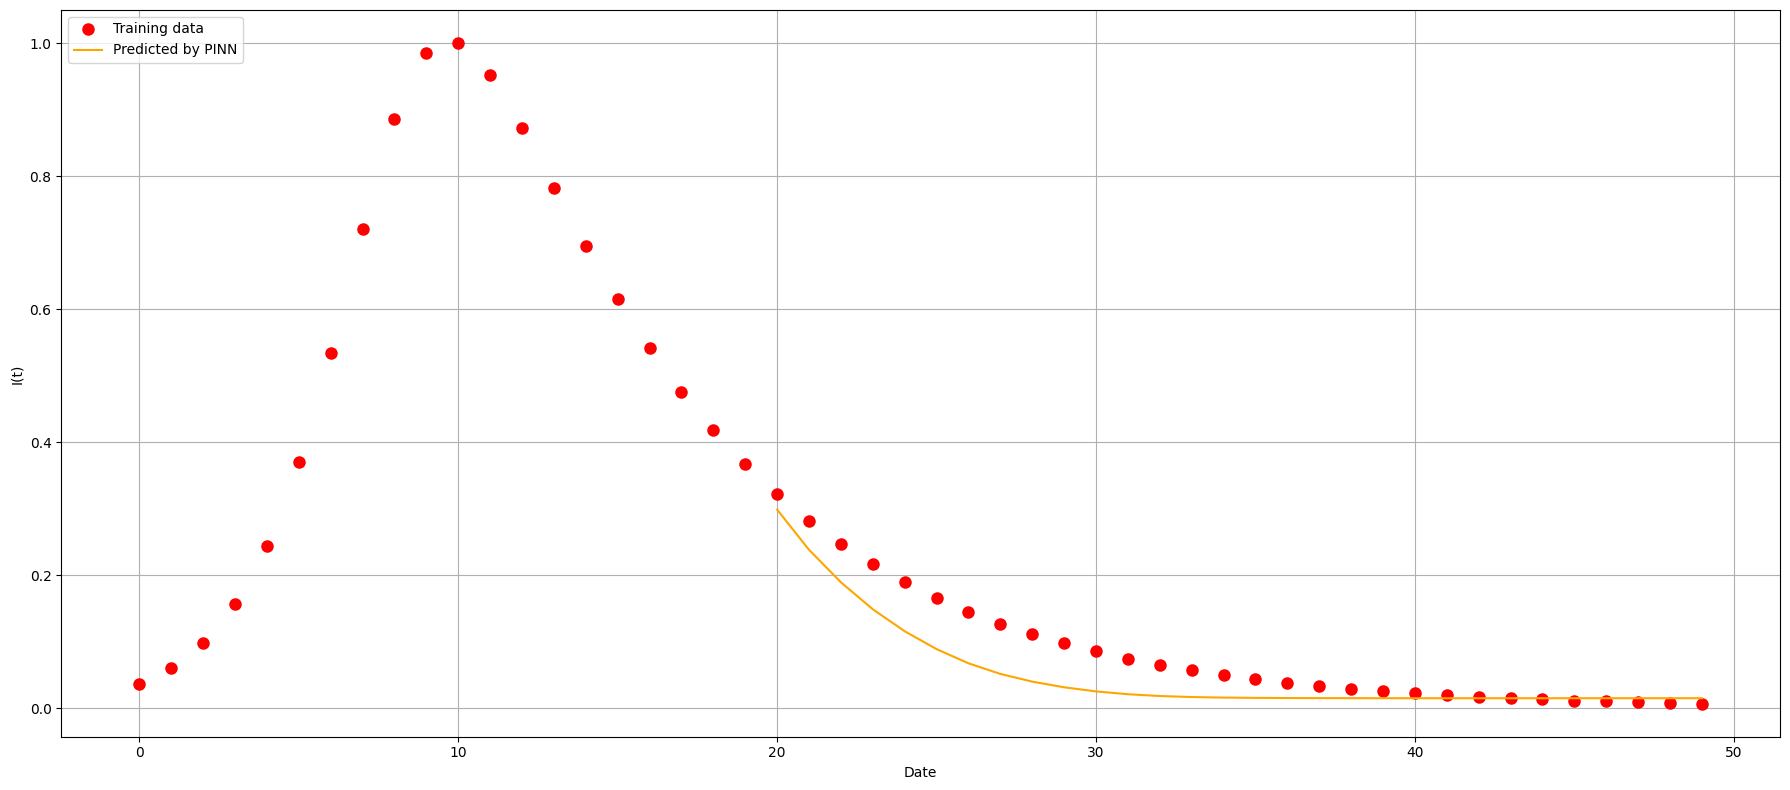

Epoch 900, Total Loss: 0.0353, SIR Loss: 0.03262448895173566, MSE Loss: 0.002648296461704182, Beta: 0.0031, Gamma: -0.0087
Early stopping at epoch 902.


In [173]:
# Trainable parameters for beta and gamma
beta = torch.tensor(0.5, requires_grad=True, dtype=torch.float32)
gamma = torch.tensor(0.3, requires_grad=True, dtype=torch.float32)

model = PINN().to(device)
optimizer = torch.optim.Adam(
    list(model.parameters()) + [beta, gamma], lr=0.001
)

start_point = 7
epochs = 3000
display_step = 50

patience = 200
early_stopping = EarlyStopping(model, patience, beta, gamma)

for epoch in range(epochs):
    total_loss, res_loss_total, data_loss_total = 0, 0, 0
    for data in datasets:
        t, target_data = data
        t = torch.tensor(t, dtype=torch.float32, requires_grad=True).unsqueeze(1).to(device)
        target_data = torch.tensor(target_data, dtype=torch.float32).unsqueeze(1).to(device)

        # Initialize input sequence
        input_sequence = target_data[:start_point].unsqueeze(0)
        predictions = []

        # Start autoregressive prediction
        for i in range(start_point, len(t) - 1):
            optimizer.zero_grad()
            # Predict the next value
            next_value = model(input_sequence)  # Input sequence predicts one step ahead
            predictions.append(next_value)

            res_loss_sequence = (input_sequence + next_value).squeeze()

            # Add the real next value to the sequence (teacher forcing)
            real_next_value = target_data[i].unsqueeze(0).unsqueeze(0)
            input_sequence = torch.cat([input_sequence, real_next_value], dim=1)

            # Keep input sequence length manageable
            input_sequence = input_sequence[:, -start_point:]
            input_sequence = input_sequence.clone().detach().requires_grad_(True)  # Reset gradient tracking

            # Residual loss for this step
            res_loss = residual_loss(res_loss_sequence, beta, gamma, t[:i+1], N=1.0)
            data_loss_value = data_loss(next_value, real_next_value)

            step_loss = data_loss_value + res_loss

            step_loss.backward()
            optimizer.step()

            total_loss += step_loss.item()
            res_loss_total += res_loss.item()
            data_loss_total += data_loss_value.item()

    # Plot predictions
    test_start_point = int(len(t) * 0.4)
    if epoch % display_step == 0:
        t, test_data = datasets[np.random.randint(0, 4)]
        test_data = torch.tensor(test_data, dtype=torch.float32).unsqueeze(1).to(device)
        predicted_values = autoregressive_predict(model, test_data[:test_start_point], len(t) - test_start_point)
        plot_predictions(test_data, test_start_point, predicted_values)
        t, test_data = datasets[np.random.randint(5, 9)]
        test_data = torch.tensor(test_data, dtype=torch.float32).unsqueeze(1).to(device)
        predicted_values = autoregressive_predict(model, test_data[:test_start_point], len(t) - test_start_point)
        plot_predictions(test_data, test_start_point, predicted_values)
    
    avg_loss = total_loss / len(datasets)
    avg_res_loss = res_loss_total / len(datasets)
    avg_data_loss = data_loss_total / len(datasets)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Total Loss: {avg_loss:.4f}, SIR Loss: {avg_res_loss}, MSE Loss: {avg_data_loss}, Beta: {beta.item():.4f}, Gamma: {gamma.item():.4f}")
    
    if early_stopping.check_early_stopping(avg_loss, epoch):
        break

### Saving model

In [276]:
torch.save(model.state_dict(), f"models/pre-trained_model_0.pt")

### Setting actual datasets

In [281]:
# Load the CSV file
path = "data/COVID_data.csv"
df = pd.read_csv(path)  # Replace with your file path

country_waves = {"Republic of Korea": {1: [15, 123],
                                   2: [206, 288],
                                   #3: [289, 419],
                                   #4: [533, 652], #좀 애매함
                                   5: [736, 897],
                                   #6: [897, 1010],
                                   #7: [1010, 1164] #wave가 애매하게 2개임
                                   },
            "China": {#1: [0, 74],
                      #2: [66, 119],
                      3: [180, 266],
                      #4: [316, 413], #wave가 살짝 2개에 가까움
                      5: [484, 561],
                      6: [1065, 1119],
                      },
            "United Kingdom of Great Britain and Northern Ireland": {#1: [52, 184],
                                                                     #2: [192, 486], #wave가 2개라서 아래의 3,4번에서 2개로 나눠도 봄.
                                                                     #3: [192, 330], #2번의 앞쪽 wave
                                                                     #4: [331, 486], #2번의 뒤쪽 wave
                                                                     #5: [772, 871],
                                                                     6: [869, 983]
                   }
            }

using_coutries = ["Republic of Korea", "China", "United Kingdom of Great Britain and Northern Ireland"]
kind = 'New_cases' #[New_cases, Cumulative_cases, New_deaths, Cumulative_deaths]

time_data = {"Republic of Korea": {}, "China": {}, "United Kingdom of Great Britain and Northern Ireland": {}}
real_time_data = {"Republic of Korea": {}, "China": {}, "United Kingdom of Great Britain and Northern Ireland": {}}
wave_data = {"Republic of Korea": {}, "China": {}, "United Kingdom of Great Britain and Northern Ireland": {}}

for country in using_coutries:
    country_data = df[df["Country"] == country]
    country_data["Real_date"] = pd.to_datetime(country_data["Date_reported"]) # save the real date for plotting
    country_data["Date_reported"] = pd.to_datetime(country_data["Date_reported"])
    country_data["Date_reported"] = (country_data["Date_reported"] - country_data["Date_reported"].iloc[0]).dt.days
    new_cases = country_data[kind].values
    new_cases[new_cases < 1] = 1

    for wave in country_waves[country]:
        start, end = country_waves[country][wave]
        time_data[country][wave] = country_data["Date_reported"].values[start:end]
        real_time_data[country][wave] = country_data["Real_date"].values[start:end]
        wave_data[country][wave] = new_cases[start:end]

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_17844\3448156637.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data["Real_date"] = pd.to_datetime(country_data["Date_reported"]) # save the real date for plotting
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_17844\3448156637.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data["Date_reported"] = pd.to_datetime(country_data["Date_reported"])
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_17844\3448156637.py:40: SettingWithCopyWarnin

### Moving average

In [282]:
# Define a function to calculate the 7-number moving average
def moving_average(data, window_size=7):
    half_window = window_size // 2
    smoothed = []
    
    for i in range(len(data)):
        # Handle edge cases
        start = max(0, i - half_window)
        end = min(len(data), i + half_window + 1)
        
        # Calculate the average of the current window
        smoothed.append(np.mean(data[start:end]))
    
    return smoothed

data = {} # smoothed data

for country in wave_data:
    data[country] = {}
    for wave in wave_data[country]:
        data[country][wave] = moving_average(wave_data[country][wave])

# which countries, which waves to use for training
training_coutries = ["Republic of Korea", "China", "United Kingdom of Great Britain and Northern Ireland"]
test_coutries = ["United Kingdom of Great Britain and Northern Ireland"]

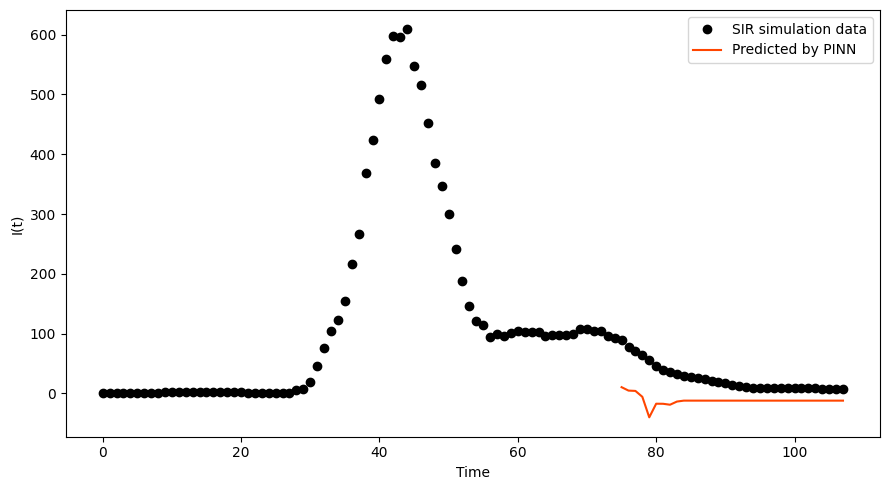

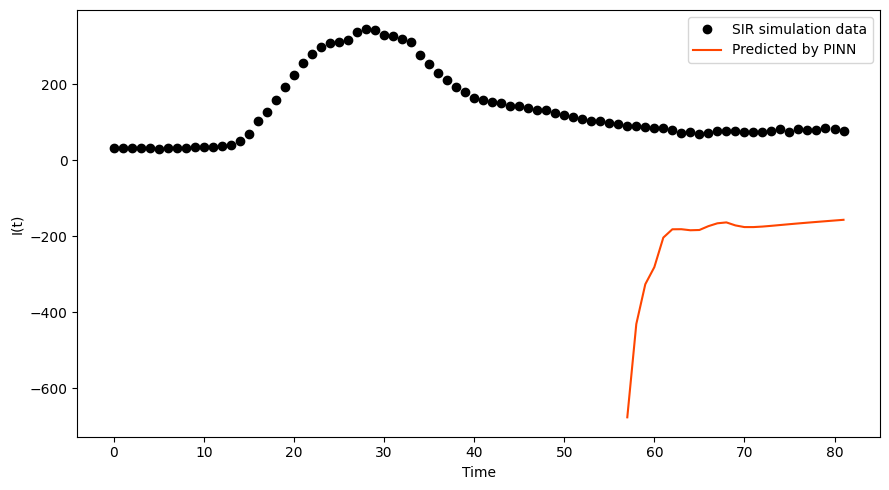

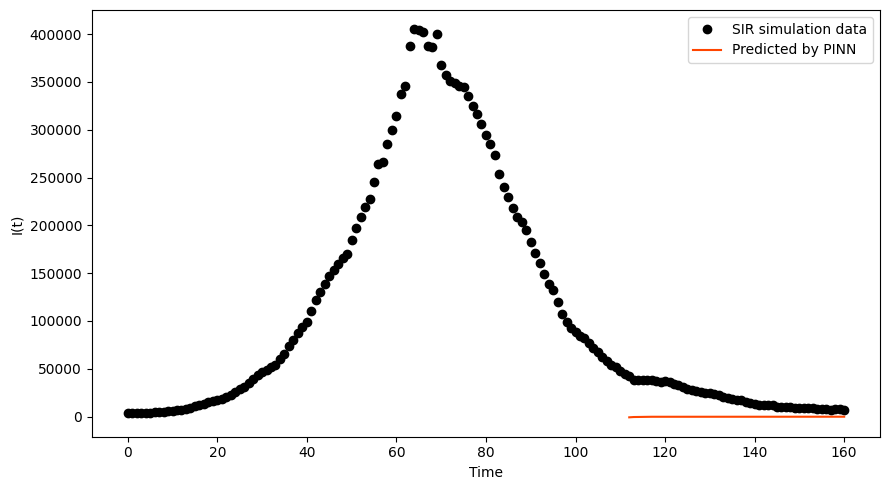

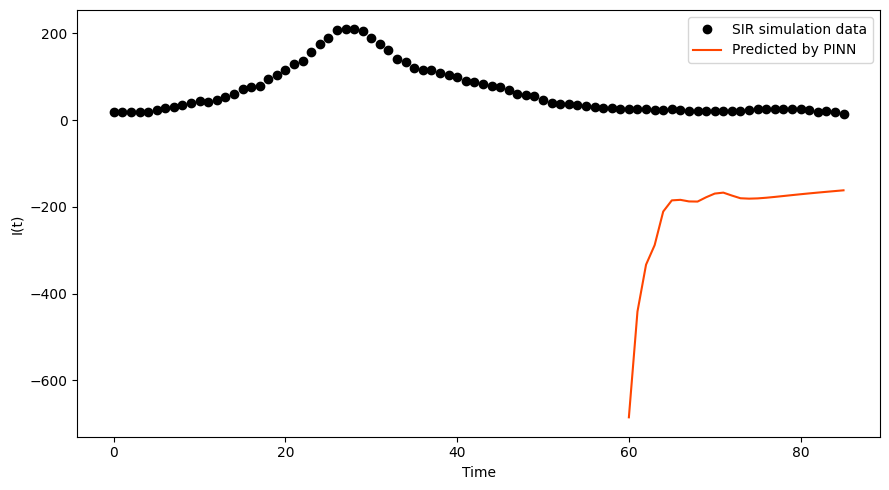

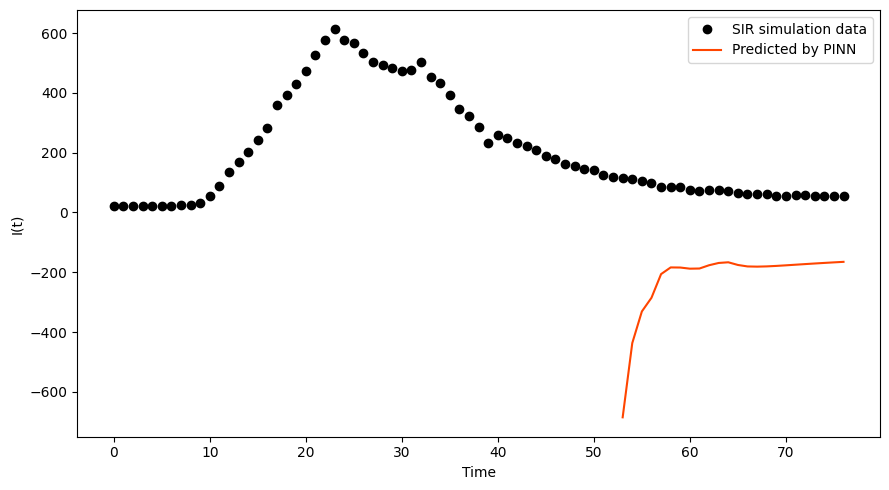

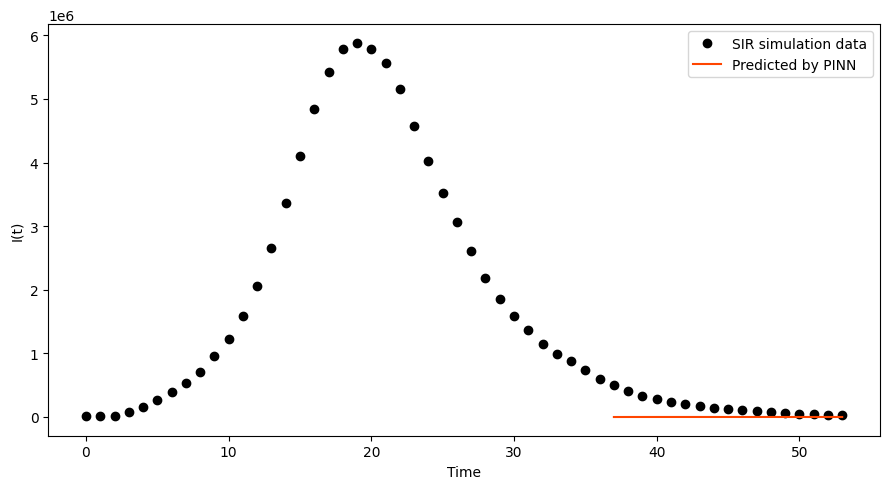

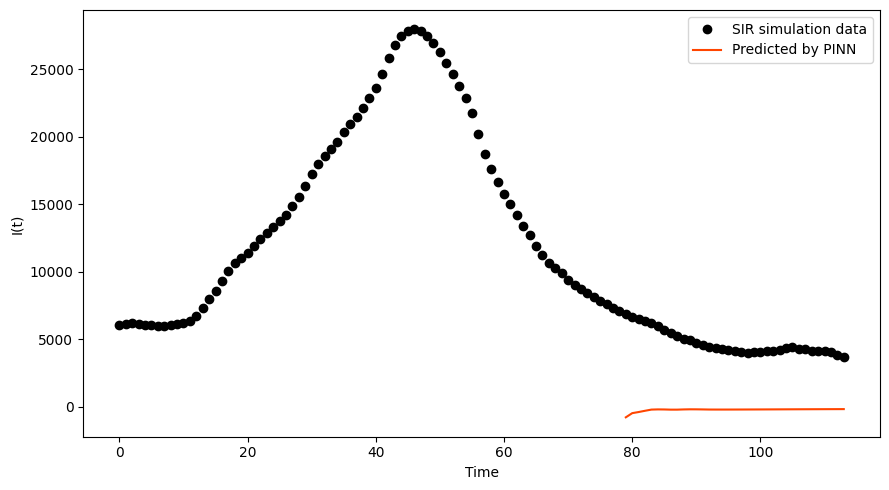

Epoch 0, Total Loss: 88790768836944691200.0000, SIR Loss: 8.879073416653752e+19, MSE Loss: 34473428630472.25, Beta: -0.0008, Gamma: -0.2157
Epoch 10, Total Loss: 88341028489141944320.0000, SIR Loss: 8.83409938194741e+19, MSE Loss: 34474508548727.758, Beta: -0.0008, Gamma: -0.2157
Epoch 20, Total Loss: 88337279527930019840.0000, SIR Loss: 8.833724485783183e+19, MSE Loss: 34475568088611.188, Beta: -0.0008, Gamma: -0.2157
Epoch 30, Total Loss: 88333525837934559232.0000, SIR Loss: 8.83334911675906e+19, MSE Loss: 34476632284420.586, Beta: -0.0008, Gamma: -0.2157
Epoch 40, Total Loss: 88329770540157468672.0000, SIR Loss: 8.832973586962502e+19, MSE Loss: 34477690884580.855, Beta: -0.0008, Gamma: -0.2157


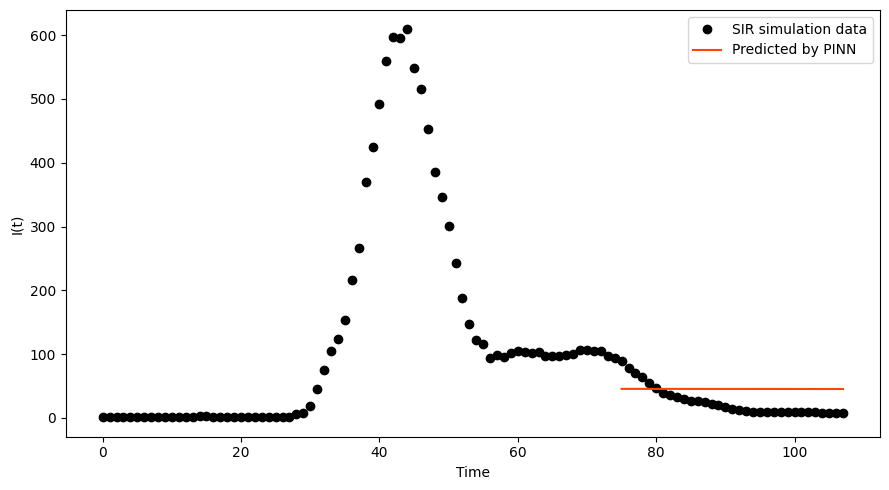

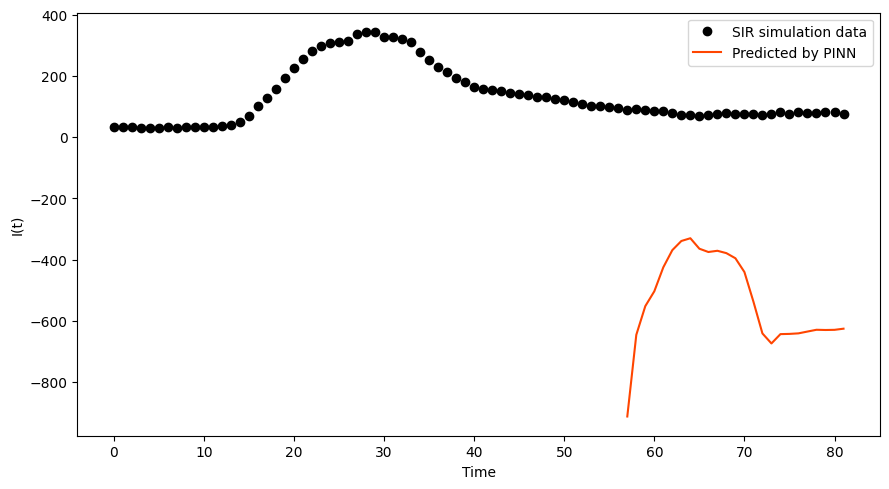

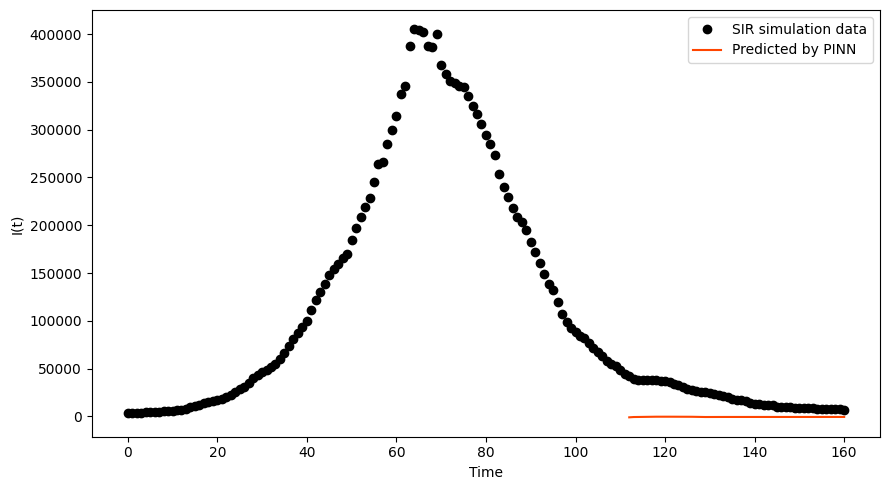

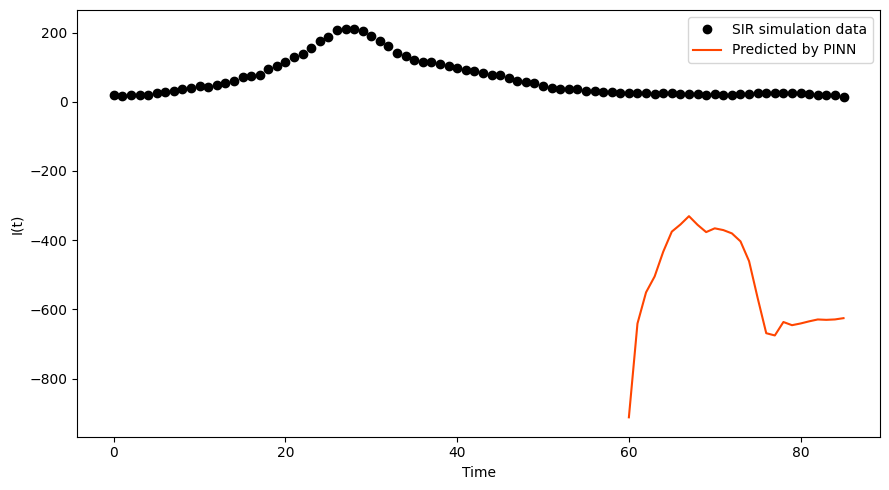

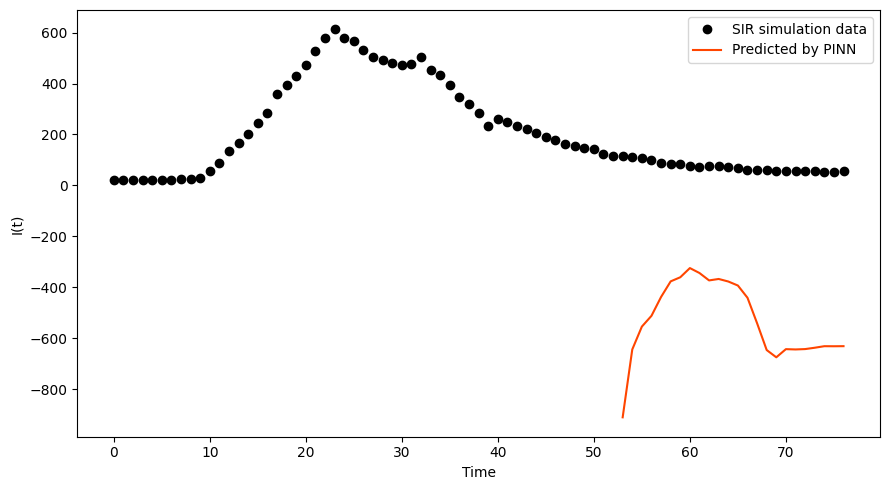

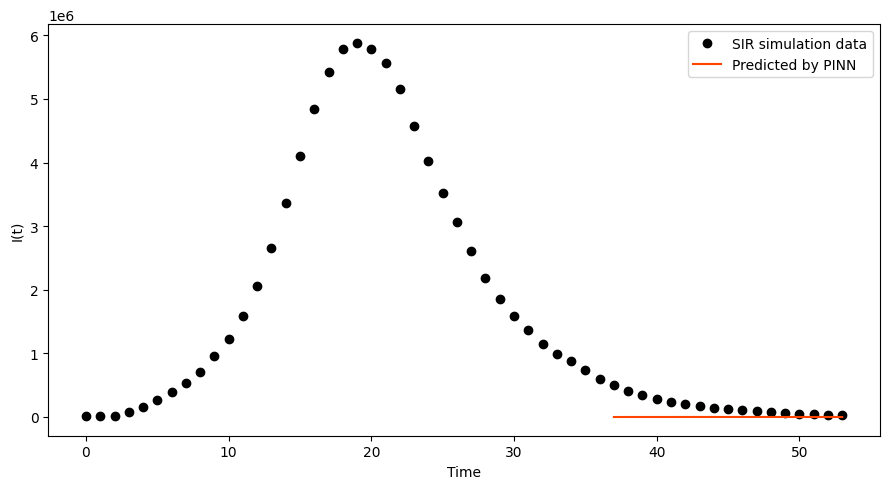

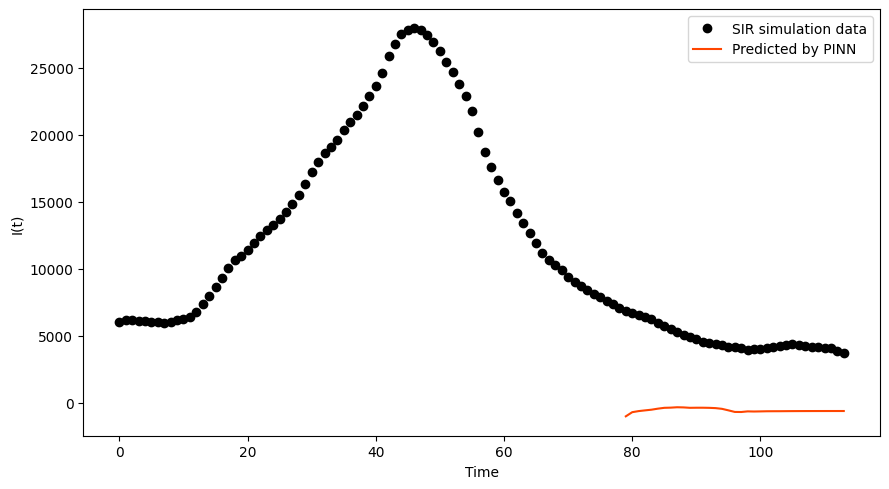

Epoch 50, Total Loss: 88326026267590475776.0000, SIR Loss: 8.832599159682451e+19, MSE Loss: 34478751677770.637, Beta: -0.0008, Gamma: -0.2157
Epoch 60, Total Loss: 88322267316341374976.0000, SIR Loss: 8.832223264529179e+19, MSE Loss: 34479817963403.79, Beta: -0.0008, Gamma: -0.2157
Epoch 70, Total Loss: 88318514664595947520.0000, SIR Loss: 8.831847999335743e+19, MSE Loss: 34480878813790.926, Beta: -0.0008, Gamma: -0.2157
Epoch 80, Total Loss: 88314775028330889216.0000, SIR Loss: 8.831474035677266e+19, MSE Loss: 34481942315884.29, Beta: -0.0008, Gamma: -0.2157
Epoch 90, Total Loss: 88311015588458774528.0000, SIR Loss: 8.831098091673199e+19, MSE Loss: 34483004154817.27, Beta: -0.0008, Gamma: -0.2157


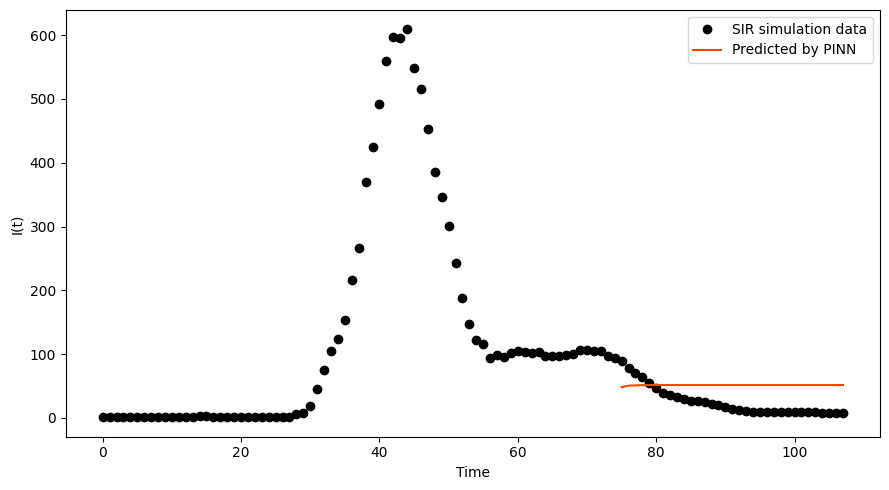

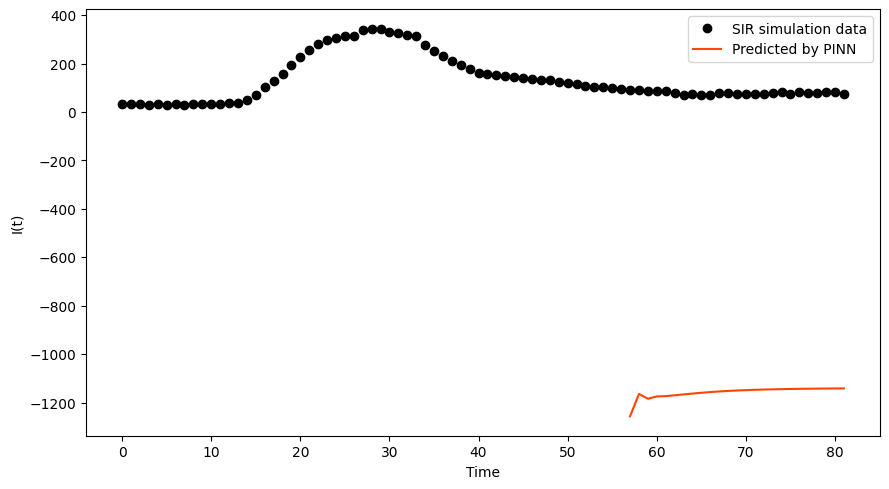

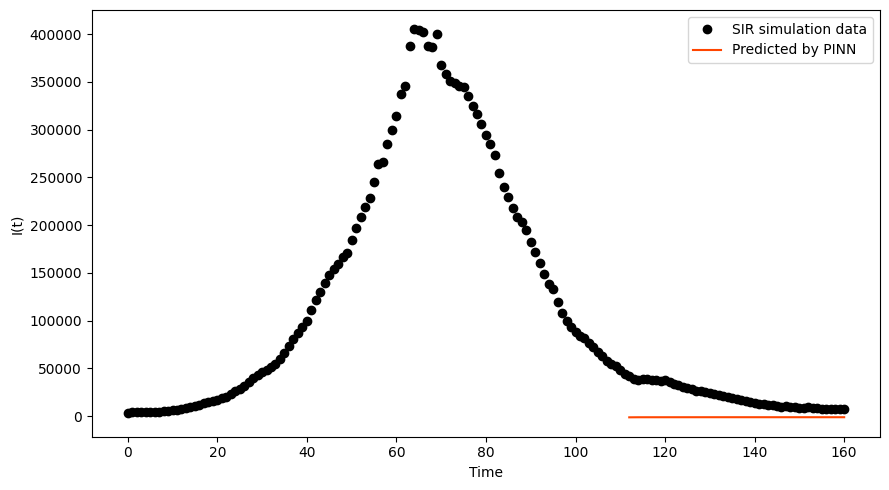

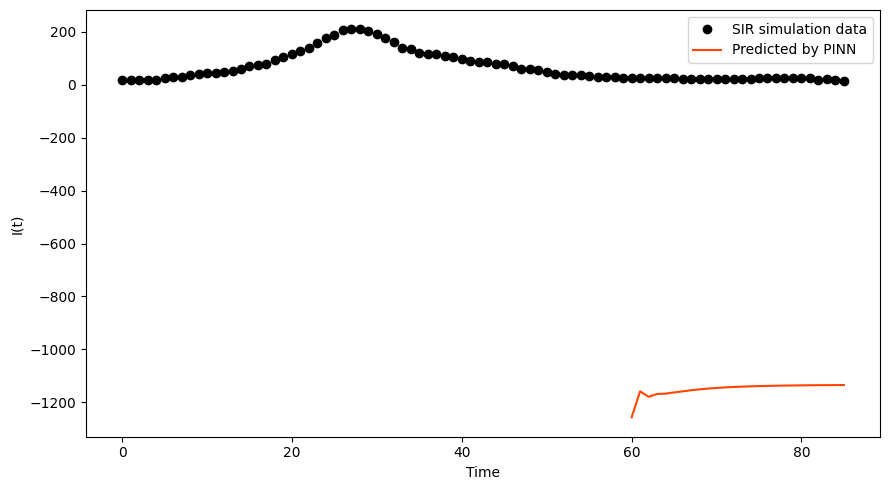

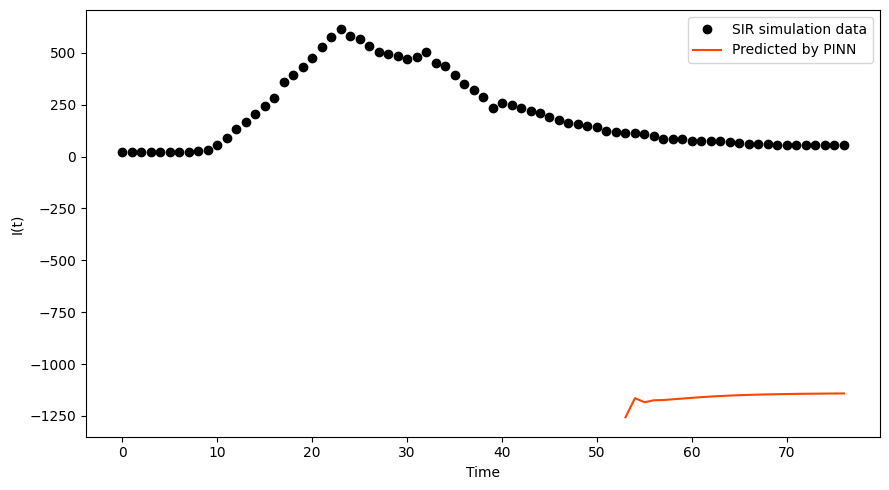

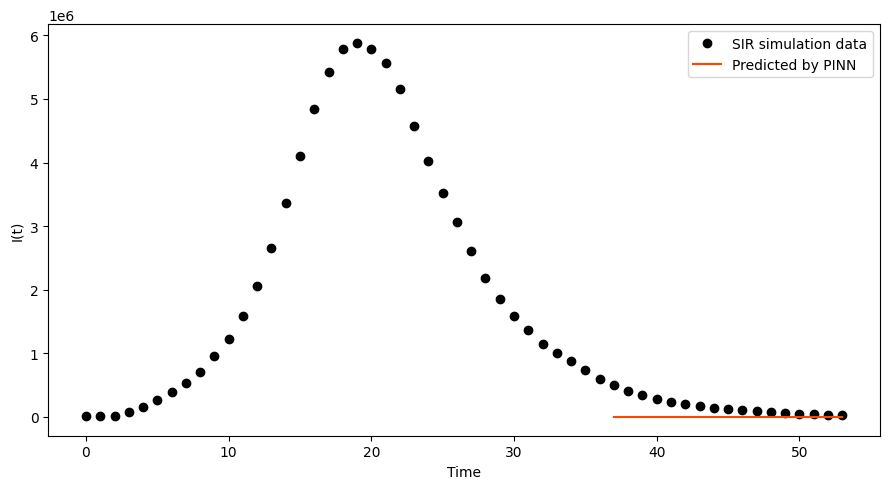

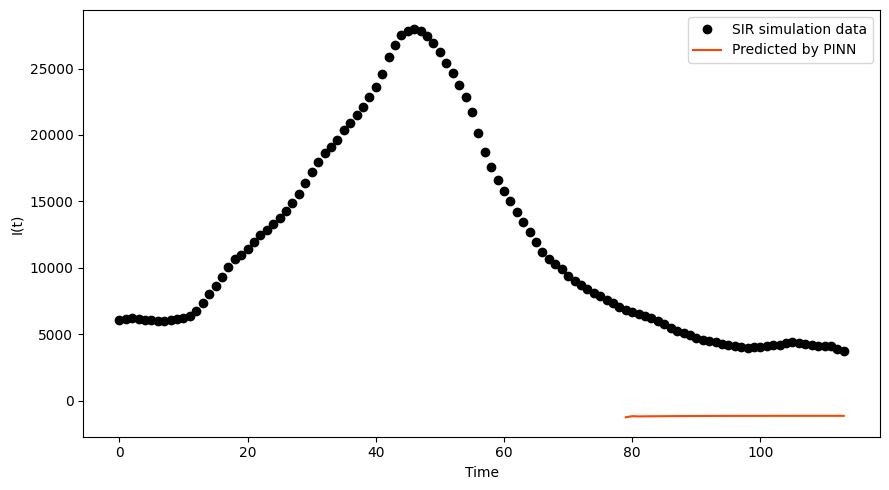

Epoch 100, Total Loss: 88307262014116888576.0000, SIR Loss: 8.83072273420624e+19, MSE Loss: 34484068602573.363, Beta: -0.0008, Gamma: -0.2157
Epoch 110, Total Loss: 88303514825189130240.0000, SIR Loss: 8.830348015296147e+19, MSE Loss: 34485131591481.523, Beta: -0.0008, Gamma: -0.2157
Epoch 120, Total Loss: 88299756428101337088.0000, SIR Loss: 8.82997217556806e+19, MSE Loss: 34486194501654.945, Beta: -0.0008, Gamma: -0.2157
Epoch 130, Total Loss: 88296012376761991168.0000, SIR Loss: 8.829597770410633e+19, MSE Loss: 34487257480842.1, Beta: -0.0008, Gamma: -0.2157
Epoch 140, Total Loss: 88292267396995481600.0000, SIR Loss: 8.829223272396708e+19, MSE Loss: 34488321543849.395, Beta: -0.0008, Gamma: -0.2157


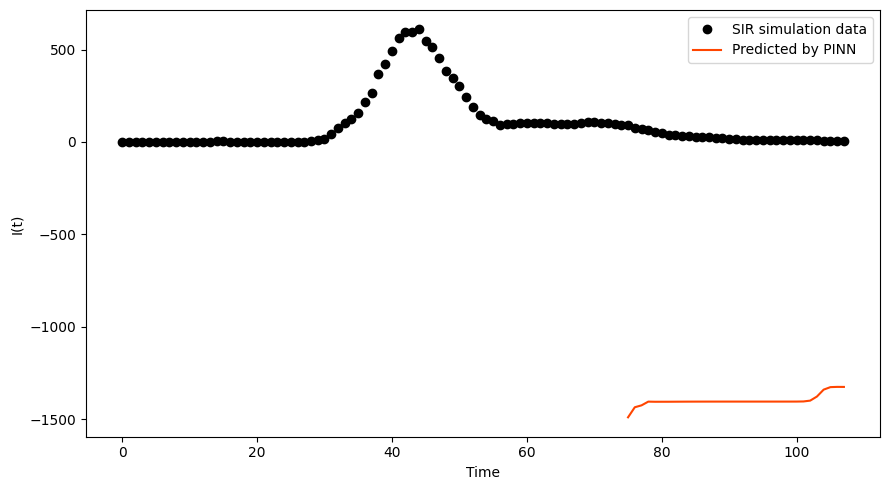

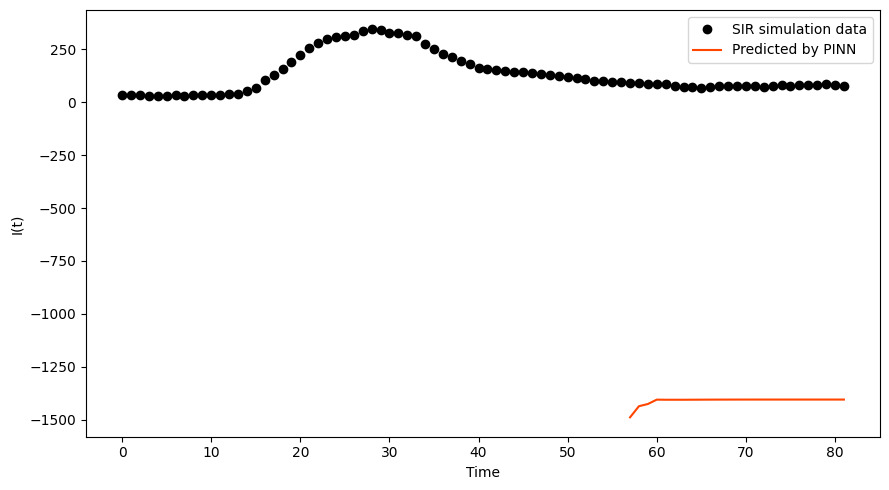

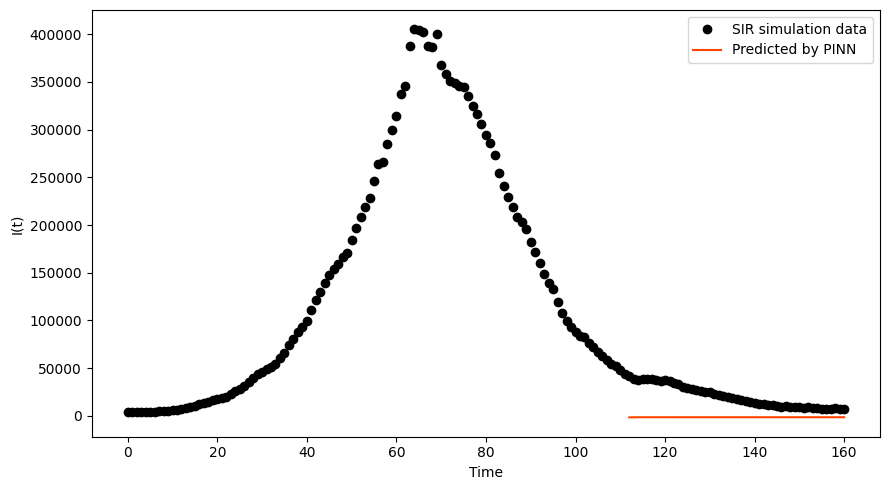

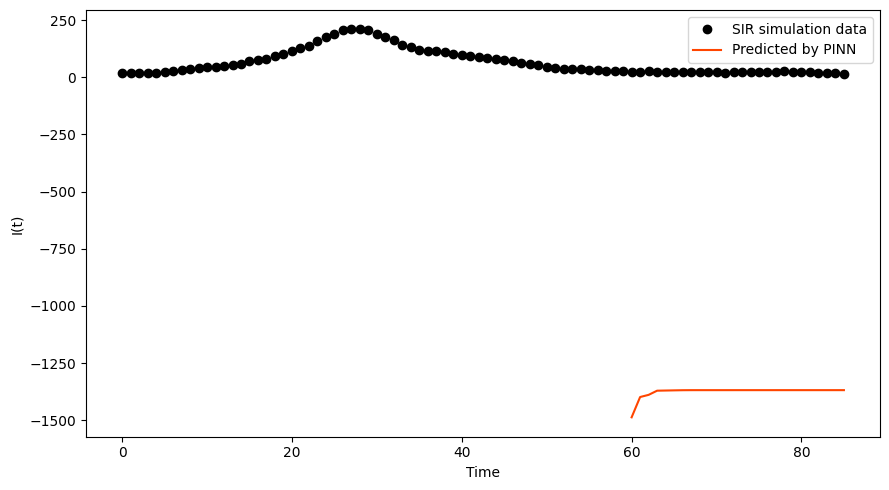

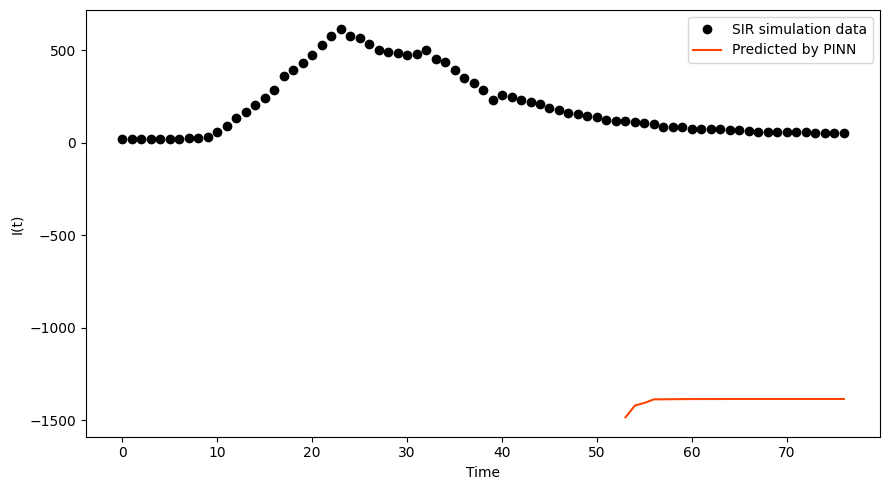

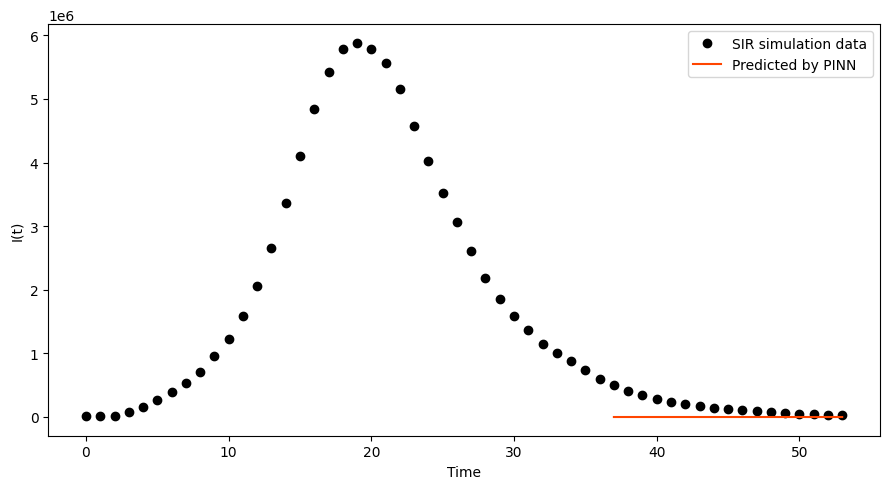

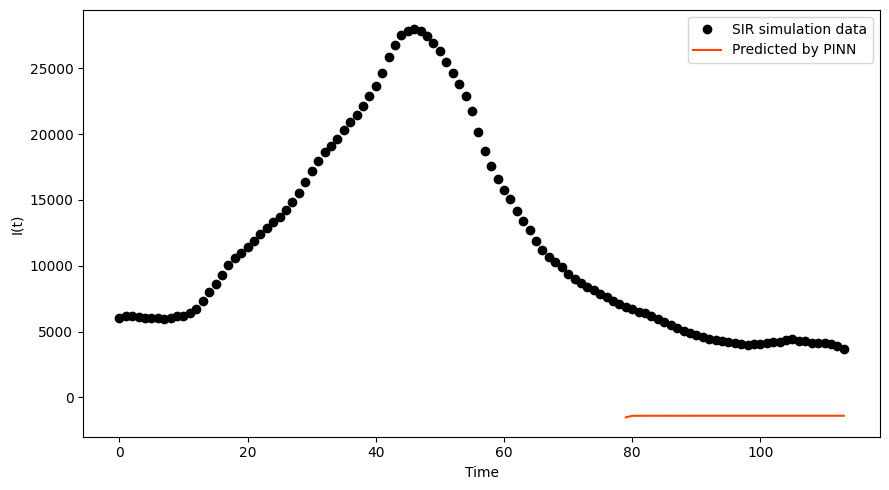

Epoch 150, Total Loss: 88288513587513098240.0000, SIR Loss: 8.828847891431581e+19, MSE Loss: 34489383592998.023, Beta: -0.0008, Gamma: -0.2157
Epoch 160, Total Loss: 88284766934545154048.0000, SIR Loss: 8.828473226120518e+19, MSE Loss: 34490444767498.363, Beta: -0.0008, Gamma: -0.2157
Epoch 170, Total Loss: 88281015778891300864.0000, SIR Loss: 8.828098110485786e+19, MSE Loss: 34491514530758.344, Beta: -0.0008, Gamma: -0.2157
Epoch 180, Total Loss: 88277261015011328000.0000, SIR Loss: 8.82772263403105e+19, MSE Loss: 34492579350534.273, Beta: -0.0008, Gamma: -0.2157
Epoch 190, Total Loss: 88273520190587797504.0000, SIR Loss: 8.827348551560135e+19, MSE Loss: 34493644949156.363, Beta: -0.0008, Gamma: -0.2157


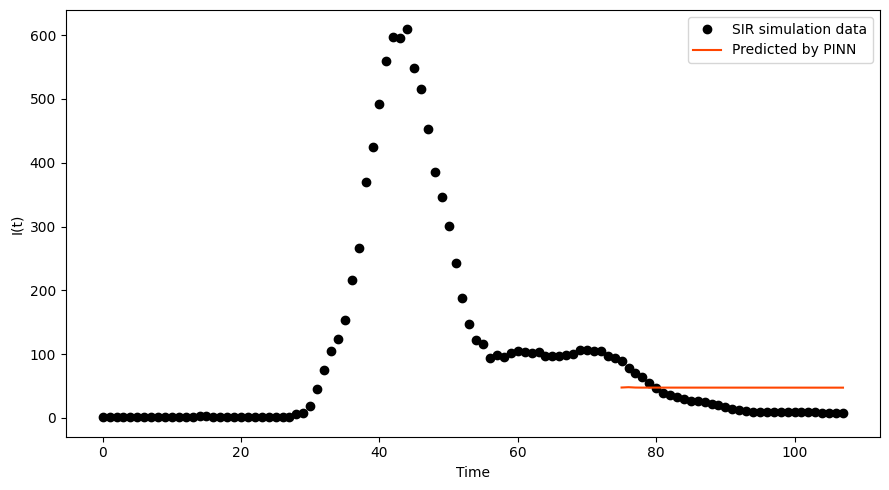

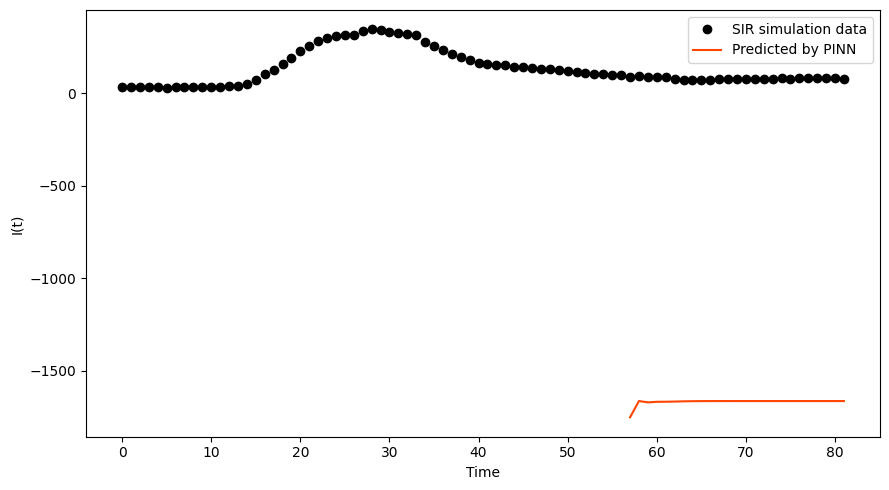

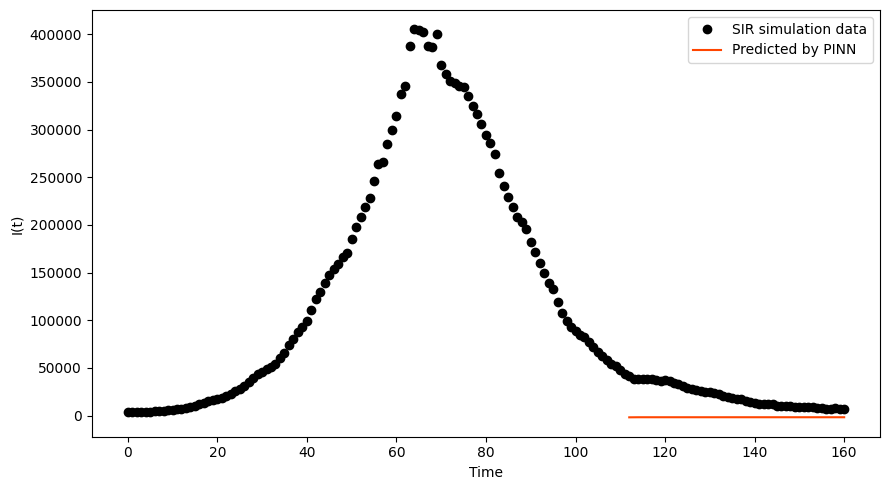

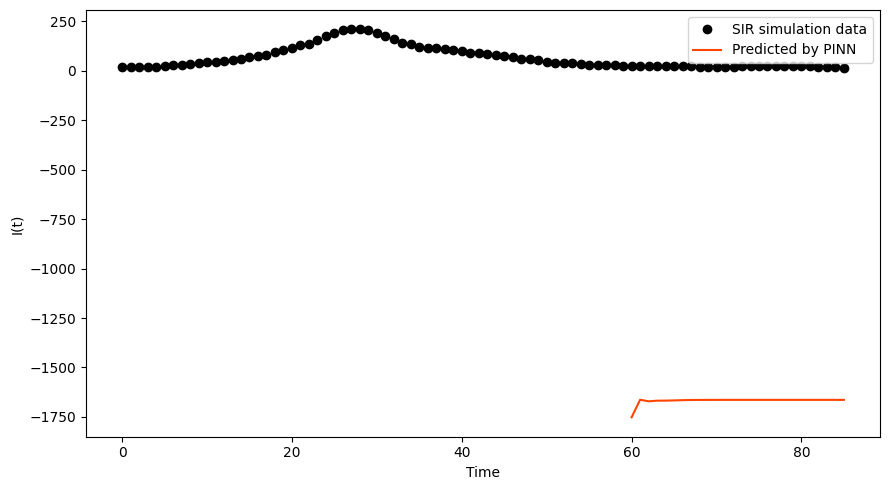

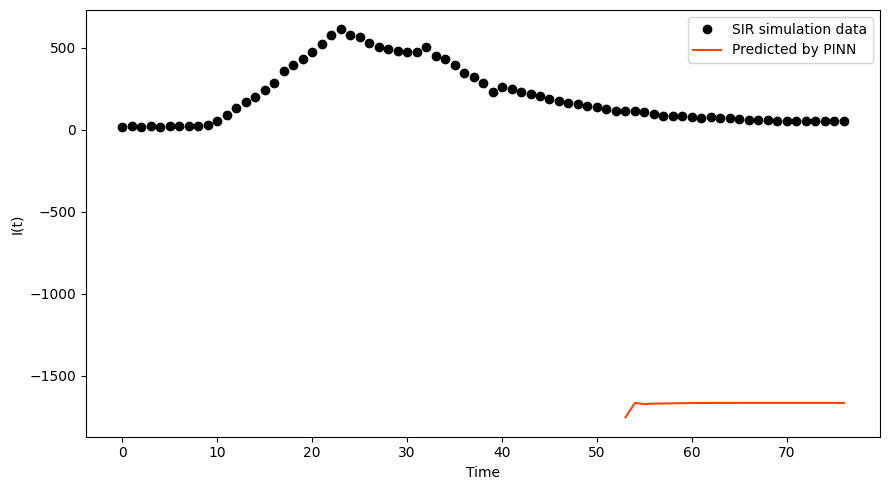

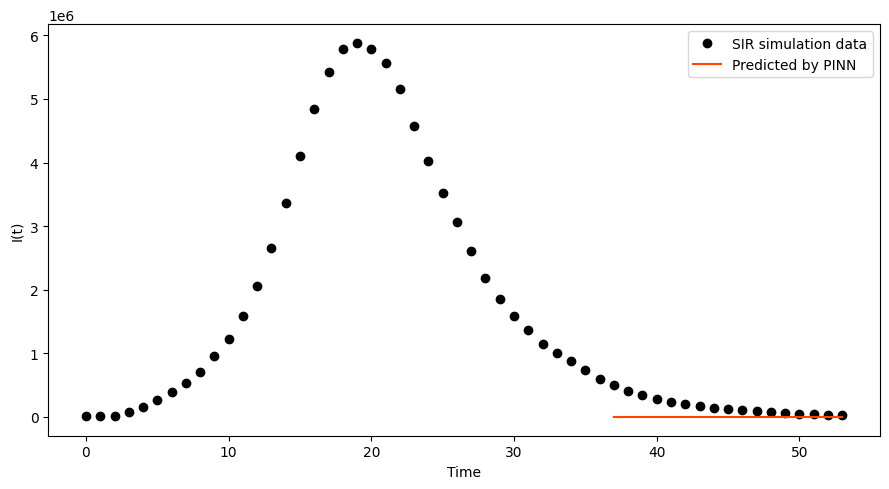

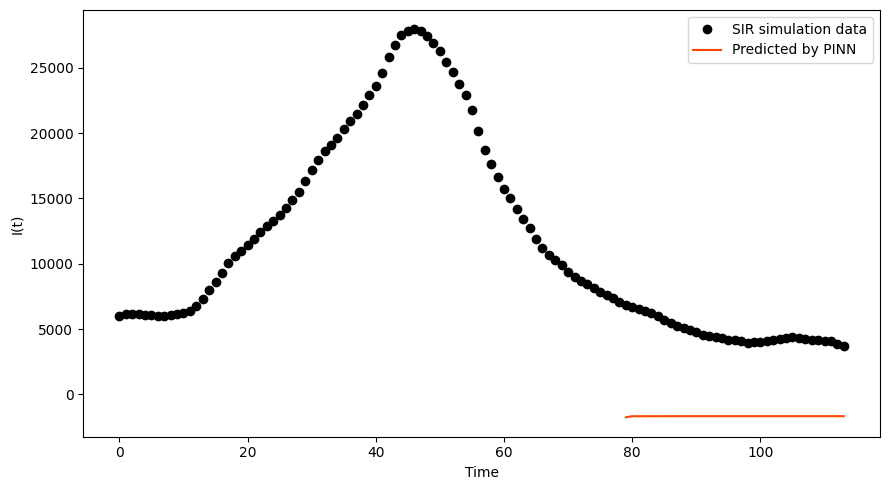

Epoch 200, Total Loss: 88269770048731561984.0000, SIR Loss: 8.826973537323791e+19, MSE Loss: 34494709725543.35, Beta: -0.0008, Gamma: -0.2157
Epoch 210, Total Loss: 88266019929307496448.0000, SIR Loss: 8.82659852535968e+19, MSE Loss: 34495775319701.8, Beta: -0.0008, Gamma: -0.2157
Epoch 220, Total Loss: 88262280108037865472.0000, SIR Loss: 8.826224543216974e+19, MSE Loss: 34496841087424.875, Beta: -0.0008, Gamma: -0.2157


KeyboardInterrupt: 

In [283]:
# Trainable parameters for beta and gamma
beta = torch.tensor(0.1, requires_grad=True, dtype=torch.float32)
gamma = torch.tensor(0.05, requires_grad=True, dtype=torch.float32)

model1 = model
#optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)
optimizer = torch.optim.Adam(
    list(model1.parameters()) + [beta, gamma], lr=0.001
)

start_point = 7
epochs = 3000
patience = 200
display_step = 50

early_stopping = EarlyStopping(model1, patience, beta, gamma)
losses = []

for epoch in range(epochs):
    total_loss, res_loss_total, data_loss_total = 0, 0, 0
    for country in training_coutries:
        for wave in data[country]:
            t = torch.tensor(time_data[country][wave], dtype=torch.float32).view(-1, 1).to(device)
            target_data = torch.tensor(data[country][wave], dtype=torch.float32).view(-1, 1).to(device)
            real_t = real_time_data[country][wave] # Real time data for plotting

            # Initialize input sequence
            input_sequence = target_data[:start_point].unsqueeze(0)
            predictions = []

            # Start autoregressive prediction
            for i in range(start_point, len(t) - 1):
                optimizer.zero_grad()
                # Predict the next value
                next_value = model1(input_sequence)  # Input sequence predicts one step ahead
                predictions.append(next_value)

                res_loss_sequence = (input_sequence + next_value).squeeze()

                # Add the real next value to the sequence (teacher forcing)
                real_next_value = target_data[i].unsqueeze(0).unsqueeze(0)
                input_sequence = torch.cat([input_sequence, real_next_value], dim=1)

                # Keep input sequence length manageable
                input_sequence = input_sequence[:, -start_point:]
                input_sequence = input_sequence.clone().detach().requires_grad_(True)  # Reset gradient tracking

                # Residual loss for this step
                res_loss = residual_loss(res_loss_sequence, beta, gamma, t[:i+1], N=1.0)
                data_loss_value = data_loss(next_value, real_next_value)

                step_loss = data_loss_value + res_loss

                step_loss.backward()
                optimizer.step()

                total_loss += step_loss.item()
                res_loss_total += res_loss.item()
                data_loss_total += data_loss_value.item()

            # Plot predictions
            test_start_point = int(len(t) * 0.7)
            if epoch % display_step == 0:
                with torch.no_grad():
                    predicted_values = autoregressive_predict(model1, target_data[:test_start_point], len(t) - test_start_point)
                    plot_predictions(target_data, test_start_point, predicted_values)
    
    avg_loss = total_loss / len(datasets)
    avg_res_loss = res_loss_total / len(datasets)
    avg_data_loss = data_loss_total / len(datasets)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Total Loss: {avg_loss:.4f}, SIR Loss: {avg_res_loss}, MSE Loss: {avg_data_loss}, Beta: {beta.item():.4f}, Gamma: {gamma.item():.4f}")
    
    if early_stopping.check_early_stopping(avg_loss, epoch):
        break